10 Compare PRS OR

compare the performance of the adjusted PRSs for CRC case and screened control data. Not looking at AUC in this notebook because it takes 45 minutes to install the RISCA library

Also looking at the actual and expected percentiles

Adding in code for response to reviewers

Creating functions and figuring out how to paste together the tables with results from different ancestries. 

use standard VM

# Load libraries

In [1]:
rm(list=ls())

In [2]:
my.packages <- c('data.table','Hmisc','tidyverse','bigrquery','lubridate','pROC')
lapply(my.packages,
       function(pkg) { if(! pkg %in% installed.packages()) { install.packages(pkg)} } )
lapply(my.packages,library,character.only = TRUE)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::

[[1]]
[1] "data.table" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"      

[[2]]
[1] "Hmisc"      "data.table" "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[3]]
 [1] "lubridate"  "forcats"    "stringr"    "dplyr"      "purrr"     
 [6] "readr"      "tidyr"      "tibble"     "ggplot2"    "tidyverse" 
[11] "Hmisc"      "data.table" "stats"      "graphics"   "grDevices" 
[16] "utils"      "datasets"   "methods"    "base"      

[[4]]
 [1] "bigrquery"  "lubridate"  "forcats"    "stringr"    "dplyr"     
 [6] "purrr"      "readr"      "tidyr"      "tibble"     "ggplot2"   
[11] "tidyverse"  "Hmisc"      "data.table" "stats"      "graphics"  
[16] "grDevices"  "utils"      "datasets"   "methods"    "base"      

[[5]]
 [1] "bigrquery"  "lubridate"  "forcats"    "stringr"    "dplyr"     
 [6] "purrr"      "readr"      "tidyr"      "tibble"     "ggplot2"   
[11] "tidyverse"  "Hmisc"      "data.table" "stats"      "graphics"  
[16] "grDevices"  "utils"      "datasets"   "methods"    "base"      

[[6]]
 [1] "pROC"       "bigrquery"  "lubridate"  "forcats"    "stringr"   
 [6] "dplyr"      "purrr"      "readr"      "tidyr"      "tibble"    
[11] "ggplot2"    "tidyverse"  "Hmisc"      "data.table" "stats"     
[16] "graphics"   "grDevices"  "utils"      "datasets"   "methods"   
[21] "base"

In [3]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pROC_1.18.2       bigrquery_1.4.2   lubridate_1.9.3   forcats_1.0.0    
 [5] stringr_1.5.0     dplyr_1.1.2       purrr_1.0.1       readr_2.1.4      
 [9] tidyr_1.3.0       tib

# Functions used in this notebook

In [4]:
# Functions that are used in this notebook
# need to add in UC1 or UC2. Need to check the OR analysis firt to decide which to use. 
# It doesn't look like either UC1 or UC2 is significant, so may be best to ignore
# the data set must contain variables named my.PRS, CRC.status, sex and censored.age

addparentheses <- function(x){paste0("(", x, ")")}

# function to get the ORs and CIs for one s.d. change in PRS
get.sex.age.pvalue <- function(subset.dt)
    {
    glm2 <- summary(glm(CRC.status ~ my.PRS + sex + censored.age, data=subset.dt,family="binomial"))
    (p.sex <- formatC((glm2$coef["sex",4]), format="e", digits=2))
    (p.age <- round((glm2$coef["censored.age",4]), 2))
    c(p.sex,p.age)
}

get.OR.round <- function(subset.dt)
    {
    glm1 <- summary(glm(CRC.status ~ my.PRS, data=subset.dt,family="binomial"))
    glm2 <- summary(glm(CRC.status ~ my.PRS + sex + censored.age, data=subset.dt,family="binomial"))
    beta1 <-  (glm1$coef["my.PRS",1])
    beta2 <- (glm2$coef["my.PRS",1])
    OR1 <- round(exp(glm1$coef["my.PRS",1]), 2)
    OR2 <- round(exp(glm2$coef["my.PRS",1]), 2)
    SD1 <- glm1$coef["my.PRS",2]
    SD2 <- glm2$coef["my.PRS",2]
    CI1 <- round(exp(beta1 + (SD1* qnorm(c(0.025,0.975)))), 2) 
    CI2 <- round(exp(beta2 + (SD2* qnorm(c(0.025,0.975)))), 2)
    rbind( c(OR1,paste(CI1[1],CI1[2],sep=",")), c(OR2, paste(CI2[1],CI2[2],sep=",")))
}
get.OR <- function(subset.dt)
    {
    glm1 <- summary(glm(CRC.status ~ my.PRS, data=subset.dt,family="binomial"))
    glm2 <- summary(glm(CRC.status ~ my.PRS + sex + censored.age, data=subset.dt,family="binomial"))
    beta1 <-  (glm1$coef["my.PRS",1])
    beta2 <- (glm2$coef["my.PRS",1])
    OR1 <- exp(glm1$coef["my.PRS",1])
    OR2 <- exp(glm2$coef["my.PRS",1])
    SD1 <- glm1$coef["my.PRS",2]
    SD2 <- glm2$coef["my.PRS",2]
    CI1 <- exp(beta1 + (SD1* qnorm(c(0.025,0.975))))
    CI2 <- exp(beta2 + (SD2* qnorm(c(0.025,0.975))))
    rbind( c(OR1,paste(CI1[1],CI1[2],sep=",")), c(OR2, paste(CI2[1],CI2[2],sep=",")))
}

# function to get the ORs and CIs for comparing top group to middle group
get.OR.group.round <- function(subset.dt)
    {
    glm1 <- summary(glm(CRC.status ~ my.group, data=subset.dt,family="binomial"))
    glm2 <- summary(glm(CRC.status ~ my.group + sex + censored.age, data=subset.dt,family="binomial"))
    beta1 <-  (glm1$coef["my.group",1])
    beta2 <- (glm2$coef["my.group",1])
    OR1 <- round(exp(glm1$coef["my.group",1]), 2)
    OR2 <- round(exp(glm2$coef["my.group",1]), 2)
    SD1 <- glm1$coef["my.group",2]
    SD2 <- glm2$coef["my.group",2]
    CI1 <- round(exp(beta1 + (SD1* qnorm(c(0.025,0.975)))), 2) 
    CI2 <- round(exp(beta2 + (SD2* qnorm(c(0.025,0.975)))), 2)
    rbind( c(OR1,paste(CI1[1],CI1[2],sep=",")), c(OR2, paste(CI2[1],CI2[2],sep=",")))
}

get.OR.quants <- function(subset.dt)
    {
    glm1 <- summary(glm(CRC.status ~ T1 + T2 + T4 + T5, data=subset.dt,family="binomial"))
    glm2 <- summary(glm(CRC.status ~ T1 + T2 + T4 + T5 + sex + censored.age, data=subset.dt,family="binomial"))
    beta1 <-  c(glm1$coef["T1",1],glm1$coef["T2",1],0,glm1$coef["T4",1],glm1$coef["T5",1])
    beta2 <- c(glm2$coef["T1",1],glm2$coef["T2",1],0,glm2$coef["T4",1],glm2$coef["T5",1])
    OR1 <- exp(beta1)
    OR2 <- exp(beta2)
    SD1 <- c(glm1$coef["T1",2],glm1$coef["T2",2],0, glm1$coef["T4",2],glm1$coef["T5",2]) 
    SD2 <- c(glm2$coef["T1",2],glm2$coef["T2",2],0, glm2$coef["T4",2],glm2$coef["T5",2])
    CI1.low <- (exp(beta1 + (SD1* qnorm(0.025)))) 
    CI1.upp <- (exp(beta1 + (SD1* qnorm(0.975))))
    CI2.low <- (exp(beta2 + (SD2* qnorm(0.025)))) 
    CI2.upp <- (exp(beta2 + (SD2* qnorm(0.975))))
    
    cbind(OR1,CI1.low,CI1.upp, OR2,CI2.low,CI2.upp)
    
}
#need to deal with inf and -inf
plot.quant.OR <- function(df.raw,df.pc,df.anc,df.broad,df.branc,main.title="",color="black"){
    mid.quant <- c(10,30,50,70,90)
    min.check <- c(df.raw[,2], df.pc[,2], df.anc[,2], df.broad[,2],df.branc[,2])
    max.check <- c(df.raw[,3], df.pc[,3], df.anc[,3], df.broad[,3],df.branc[,3])
    min.y <- min(min.check[is.finite(min.check)])
    max.y <- max(max.check[is.finite(max.check)])
#    min.y <- min(df.raw[,2], df.pc[,2], df.anc[,2], df.broad[,2],df.branc[,2])
#    max.y <- max(df.raw[,3], df.pc[,3], df.anc[,3], df.broad[,3],df.branc[,3])
    par(mfrow=c(6,1), mar= c(0.4, 4.1,1, 2.1))
    plot(mid.quant,df.raw[,1],type="p", ylim=c(min.y, max.y), main=main.title, xlab="", ylab="PRS.RAW",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=df.raw[,2],x1=mid.quant,y1=df.raw[,3],col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=1, lty=2, col="gray")
    plot(mid.quant,df.pc[,1],type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="PRS.PC",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=df.pc[,2],x1=mid.quant,y1=df.pc[,3],col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=1, lty=2, col="gray")
    plot(mid.quant,df.anc[,1],type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="PRS.ANC",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=df.anc[,2],x1=mid.quant,y1=df.anc[,3],col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=1, lty=2, col="gray")
    plot(mid.quant,df.broad[,1],type="p", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="BROAD.PRS",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=df.broad[,2],x1=mid.quant,y1=df.broad[,3],col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=1, lty=2, col="gray")
    plot(mid.quant,df.branc[,1],type="p", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="BRANC.PRS",col=color)
    arrows(x0=mid.quant,y0=df.branc[,2],x1=mid.quant,y1=df.broad[,3],col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=1, lty=2, col="gray")

}


plot.quant.logOR <- function(df.raw,df.pc,df.anc,df.broad,df.branc,main.title="",color="black"){
    mid.quant <- c(10,30,50,70,90)
    min.check <- c(df.raw[,2], df.pc[,2], df.anc[,2], df.broad[,2],df.branc[,2])
    max.check <- c(df.raw[,3], df.pc[,3], df.anc[,3], df.broad[,3],df.branc[,3])
    min.y <- log(min(min.check[is.finite(min.check) & min.check>0]))
    max.y <- log(max(max.check[is.finite(max.check) & max.check>0]))
    letter.at <- max.y - 0.15 * (max.y-min.y)
    par(mfrow=c(6,1), mar= c(0.4, 4.1,1, 2.1))
    plot(mid.quant,log(df.raw[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=log(df.raw[,2]),x1=mid.quant,y1=log(df.raw[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=0, lty=2, col="gray")
    mtext("A", 2, adj=1, padj=0, line=3, las=2,at=letter.at)
    plot(mid.quant,log(df.pc[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=log(df.pc[,2]),x1=mid.quant,y1=log(df.pc[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=0, lty=2, col="gray")
    mtext("B", 2, adj=1, padj=0, line=3, las=2,at=letter.at)
    plot(mid.quant,log(df.anc[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=log(df.anc[,2]),x1=mid.quant,y1=log(df.anc[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=0, lty=2, col="gray")
    mtext("C", 2, adj=1, padj=0, line=3, las=2,at=letter.at)
    plot(mid.quant,log(df.broad[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="",xaxt='n',col=color)
    arrows(x0=mid.quant,y0=log(df.broad[,2]),x1=mid.quant,y1=log(df.broad[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=0, lty=2, col="gray")
    mtext("D", 2, adj=1, padj=0, line=3, las=2,at=letter.at)
    plot(mid.quant,log(df.branc[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="",col=color)
    arrows(x0=mid.quant,y0=log(df.branc[,2]),x1=mid.quant,y1=log(df.branc[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
    abline(h=0, lty=2, col="gray")
    mtext("E", 2, adj=1, padj=0, line=3, las=2,at=letter.at)

}

get.observed.freq <- function(subset.dt, cutoff)
    {
    #cutoff <- 0.9
    (total <- length(subset.dt$my.prs))
    (count <- length(subset.dt$my.prs[subset.dt$my.prs > qnorm(cutoff)]))
    (prop <- 1 - cutoff)
    obs.freq <- round(100*binom.test(x=count,n=total,p=prop)$estimate,2)
    ci.freq <- round(100*binom.test(x=count,n=total,p=prop)$conf.int,2)
    c(obs.freq, ci.freq)
    }

plot.obs.exp.ci <- function(horiz.axis=c(1:5), actuals.mat, lower.mat, upper.mat, my.ancestry="", col="black")
{
    matplot(horiz.axis,t(actuals.mat), type="n", main=my.ancestry, xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
    axis(1, at=1:5, labels=c("RAW", "PC","BR.AOU","ANC","BR.ANC"))
    matpoints(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col=col, pch=1)
    matlines(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col=col)
    arrows(x0=1,y0=lower.mat[,1],x1=1,y1=upper.mat[,1],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=2,y0=lower.mat[,2],x1=2,y1=upper.mat[,2],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=3,y0=lower.mat[,3],x1=3,y1=upper.mat[,3],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=4,y0=lower.mat[,4],x1=4,y1=upper.mat[,4],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=5,y0=lower.mat[,5],x1=5,y1=upper.mat[,5],col=col,lwd=2,code=3,angle=90,length=1/10)
    abline(h=5,lwd=2,lty=3)
    abline(h=7.5,lwd=3, lty=2)
    abline(h=10,lwd=4,lty=1)
}

# Prepare the data

In [5]:
# copy over the output file from 25 Adjust alpha3 PRS by WG PCs or admixture
#infile <- "CRC-Nov2021-PRS-adjustments-2023-03-02.tsv"
#(cp.command <- paste0("gsutil -m cp -r  gs://fc-secure-30fdbdfd-a46b-406d-9617-1bc69ae1da9d/alpha3/",infile," ."))
infile <- "CRC-PRS-adjustments-2023-03-02.tsv"
(cp.command <- paste0("gsutil -m cp -r   gs://fc-secure-91b7b957-58d8-4142-b93b-c3a2635f2d78/alpha3/",infile," ."))
system(cp.command)

[1] "gsutil -m cp -r  gs://fc-secure-30fdbdfd-a46b-406d-9617-1bc69ae1da9d/alpha3/CRC-Nov2021-PRS-adjustments-2023-03-02.tsv ."

In [ ]:
merge.dt <- fread(infile)
str(merge.dt)

In [7]:
# standardise raw PRS, PC adjusted PRS and ANC adjusted PRS  for the OR calculations
# standardization needs to happen before reducing to the cleaned cases and screened controls
merge.dt[,norm.PRS := (PRS-mean(PRS))/sd(PRS)]
merge.dt[,norm.PRS.ADJ.PC := (PRS.ADJ.PC)/sd(PRS.ADJ.PC)]
merge.dt[,norm.PRS.ADJ.ANC := (PRS.ADJ.ANC)/sd(PRS.ADJ.ANC)]
# The broad adjustments don't need to be standardized because theoretically, they already do this
#merge.dt[,norm.BROAD.PRS := BROAD.PRS] 

In [8]:
# need to have sex be numeric
#merge.dt <- merge.dt[][!is.na(merge.dt$sex_at_birth)]
merge.dt[,sex:=ifelse(sex_at_birth=="Male",1,NA)] #since there are fewer males than females, males are 1 and females are 0
merge.dt[,sex:=ifelse(sex_at_birth=="Female",0,sex)]

In [ ]:
describe(merge.dt$sex_at_birth)
describe(merge.dt$sex)

In [10]:
# get percentiles for comparisons. Does it make sense to just look at the middle and top percentiles for now? 
# T1 bottom 20%
# T2 20-40%
# T3 40-60%
# T4 60-80%
# T5 80-100%
# Below are used for specific comparisons with the T3 group
# T6 90-100%
# T7 92.5-100%
# T8 95-100%
merge.dt[,T1.PRS:=ifelse(norm.PRS <= qnorm(.20),1,0)]
merge.dt[,T2.PRS:=ifelse(norm.PRS <= qnorm(.40) & norm.PRS > qnorm(.20),1,0)]
merge.dt[,T3.PRS:=ifelse(norm.PRS <= qnorm(.60) & norm.PRS > qnorm(.40),1,0)]
merge.dt[,T4.PRS:=ifelse(norm.PRS <= qnorm(.80) & norm.PRS > qnorm(.60),1,0)]
merge.dt[,T5.PRS:=ifelse(norm.PRS > qnorm(.80),1,0)]

merge.dt[,T6.PRS:=ifelse(norm.PRS > qnorm(.90),1,0)]
merge.dt[,T7.PRS:=ifelse(norm.PRS > qnorm(.925),1,0)]
merge.dt[,T8.PRS:=ifelse(norm.PRS > qnorm(.95),1,0)]

In [11]:
merge.dt[,T1.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC <= qnorm(.20),1,0)]
merge.dt[,T2.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC <= qnorm(.40) & norm.PRS.ADJ.PC > qnorm(.20),1,0)]
merge.dt[,T3.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC <= qnorm(.60) & norm.PRS.ADJ.PC > qnorm(.40),1,0)]
merge.dt[,T4.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC <= qnorm(.80) & norm.PRS.ADJ.PC > qnorm(.60),1,0)]
merge.dt[,T5.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC > qnorm(.80),1,0)]

merge.dt[,T6.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC > qnorm(.90),1,0)]
merge.dt[,T7.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC > qnorm(.925),1,0)]
merge.dt[,T8.PRS.ADJ.PC:=ifelse(norm.PRS.ADJ.PC > qnorm(.95),1,0)]

In [12]:
merge.dt[,T1.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC <= qnorm(.20),1,0)]
merge.dt[,T2.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC <= qnorm(.40) & norm.PRS.ADJ.ANC > qnorm(.20),1,0)]
merge.dt[,T3.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC <= qnorm(.60) & norm.PRS.ADJ.ANC > qnorm(.40),1,0)]
merge.dt[,T4.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC <= qnorm(.80) & norm.PRS.ADJ.ANC > qnorm(.60),1,0)]
merge.dt[,T5.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC > qnorm(.80),1,0)]

merge.dt[,T6.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC > qnorm(.90),1,0)]
merge.dt[,T7.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC > qnorm(.925),1,0)]
merge.dt[,T8.PRS.ADJ.ANC:=ifelse(norm.PRS.ADJ.ANC > qnorm(.95),1,0)]

In [13]:
merge.dt[,T1.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 <= qnorm(.20),1,0)]
merge.dt[,T2.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 <= qnorm(.40) & PRS.BR.AOU1 > qnorm(.20),1,0)]
merge.dt[,T3.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 <= qnorm(.60) & PRS.BR.AOU1 > qnorm(.40),1,0)]
merge.dt[,T4.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 <= qnorm(.80) & PRS.BR.AOU1 > qnorm(.60),1,0)]
merge.dt[,T5.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 > qnorm(.80),1,0)]

merge.dt[,T6.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 > qnorm(.90),1,0)]
merge.dt[,T7.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 > qnorm(.925),1,0)]
merge.dt[,T8.PRS.BR.AOU1:=ifelse(PRS.BR.AOU1 > qnorm(.95),1,0)]

In [14]:
merge.dt[,T1.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 <= qnorm(.20),1,0)]
merge.dt[,T2.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 <= qnorm(.40) & PRS.BR.ANC.AOU1 > qnorm(.20),1,0)]
merge.dt[,T3.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 <= qnorm(.60) & PRS.BR.ANC.AOU1 > qnorm(.40),1,0)]
merge.dt[,T4.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 <= qnorm(.80) & PRS.BR.ANC.AOU1 > qnorm(.60),1,0)]
merge.dt[,T5.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 > qnorm(.80),1,0)]

merge.dt[,T6.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 > qnorm(.90),1,0)]
merge.dt[,T7.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 > qnorm(.925),1,0)]
merge.dt[,T8.PRS.BR.ANC.AOU1:=ifelse(PRS.BR.ANC.AOU1 > qnorm(.95),1,0)]

In [15]:
# get participants who are less than 50% any ancestry
merge.dt[, is.admixed:=ifelse(AFR < 0.5 & AMR < 0.5 & EUR < 0.5 & EAS < 0.5 & MID < 0.5 & SAS < 0.5, 1, 0)]
describe(merge.dt$is.admixed)

merge.dt$is.admixed 
       n  missing distinct     Info      Sum     Mean      Gmd 
   98256        0        2    0.183     6421  0.06535   0.1222 


In [16]:
# Get subset with just cleaned cases and screened controls
merge2.dt <- merge.dt[][(merge.dt$CSET3==1 | merge.dt$SCREENED==1) ]
as.data.frame(merge2.dt) %>%
    count(CRC.status,CSET1, CSET3, SCREENED)

CRC.status,CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>,<int>
0,0,0,1,12378
1,1,1,0,348


# Plot densities in the entire data set

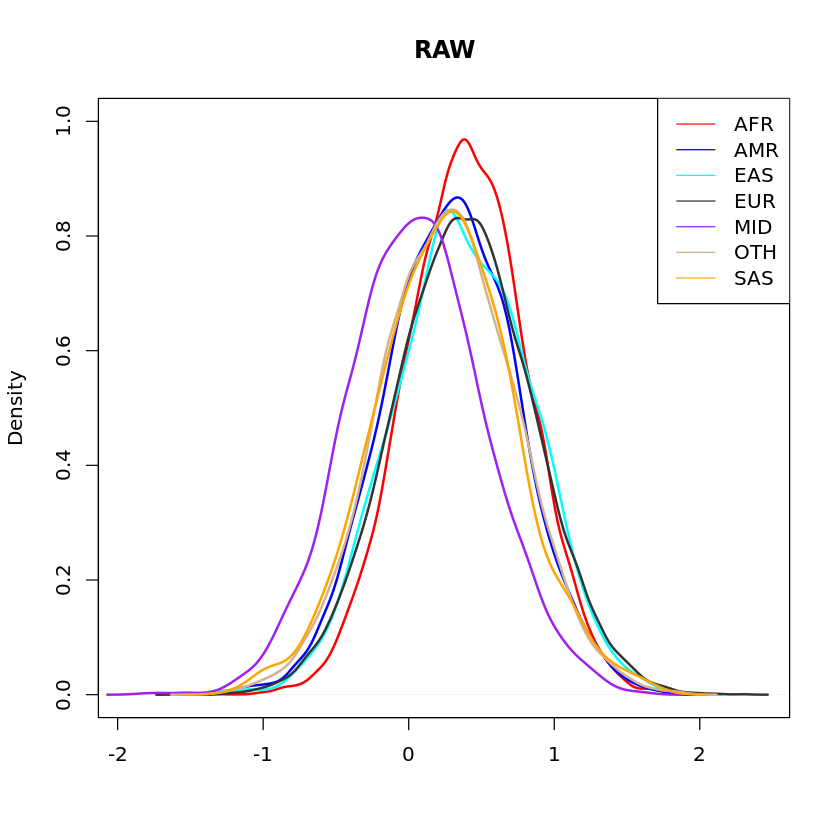

In [33]:
prs.density.all <- density(merge.dt$PRS)
prs.density.afr <- density(merge.dt$PRS[merge.dt$my.ancestry=="AFR"])
prs.density.amr <- density(merge.dt$PRS[merge.dt$my.ancestry=="AMR"])
prs.density.eas <- density(merge.dt$PRS[merge.dt$my.ancestry=="EAS"])
prs.density.eur <- density(merge.dt$PRS[merge.dt$my.ancestry=="EUR"])
prs.density.mid <- density(merge.dt$PRS[merge.dt$my.ancestry=="MID"])
prs.density.oth <- density(merge.dt$PRS[merge.dt$my.ancestry=="OTH"])
prs.density.sas <- density(merge.dt$PRS[merge.dt$my.ancestry=="SAS"])
plot(prs.density.all, main="RAW",ylim=c(0,1),type="n",xlab="")
lines(prs.density.afr, col="red",lwd=2)
lines(prs.density.amr, col="blue",lwd=2)
lines(prs.density.eas, col="cyan",lwd=2)
lines(prs.density.eur, col="gray20",lwd=2)
lines(prs.density.mid, col="purple",lwd=2)
lines(prs.density.oth, col="tan",lwd=2)
lines(prs.density.sas, col="orange",lwd=2)
#legend("topright",legend=c("All","AFR","AMR","EAS","EUR","MID","OTH","SAS"),
#       col=c("black","red","blue","cyan","gray20","purple","tan","orange"),lty=1)
legend("topright",legend=c("AFR","AMR","EAS","EUR","MID","OTH","SAS"),
       col=c("red","blue","cyan","gray20","purple","tan","orange"),lty=1)

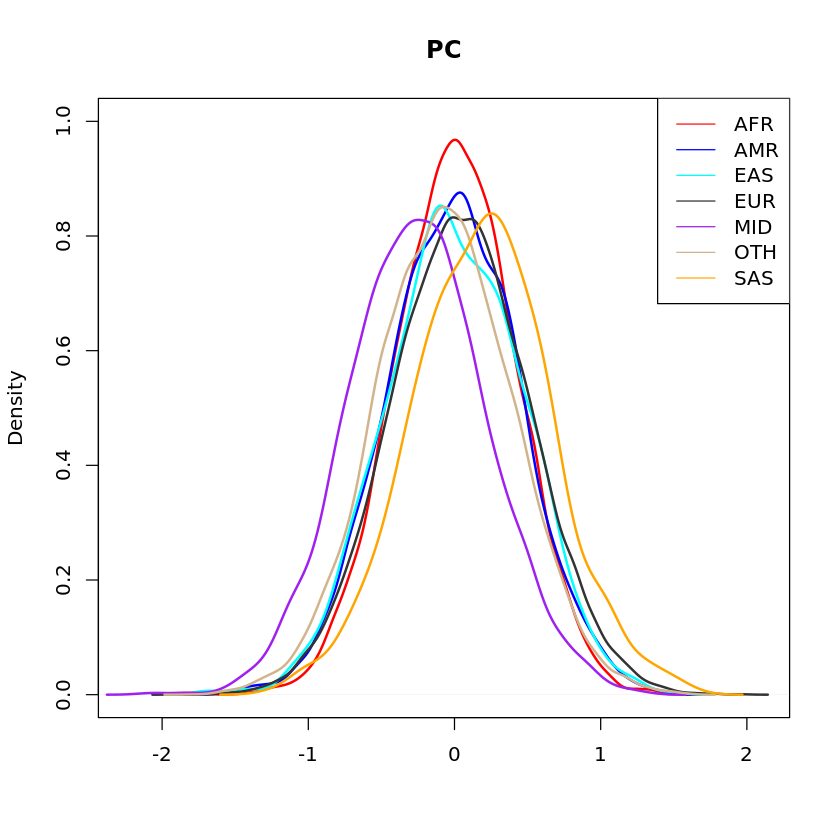

In [32]:
prs.density.all <- density(merge.dt$PRS.ADJ.PC)
prs.density.afr <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="AFR"])
prs.density.amr <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="AMR"])
prs.density.eas <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="EAS"])
prs.density.eur <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="EUR"])
prs.density.mid <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="MID"])
prs.density.oth <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="OTH"])
prs.density.sas <- density(merge.dt$PRS.ADJ.PC[merge.dt$my.ancestry=="SAS"])
plot(prs.density.all, main="PC",ylim=c(0,1),type="n",xlab="")
lines(prs.density.afr, col="red",lwd=2)
lines(prs.density.amr, col="blue",lwd=2)
lines(prs.density.eas, col="cyan",lwd=2)
lines(prs.density.eur, col="gray20",lwd=2)
lines(prs.density.mid, col="purple",lwd=2)
lines(prs.density.oth, col="tan",lwd=2)
lines(prs.density.sas, col="orange",lwd=2)
#legend("topright",legend=c("All","AFR","AMR","EAS","EUR","MID","OTH","SAS"),
#       col=c("black","red","blue","cyan","gray20","purple","tan","orange"),lty=1)
legend("topright",legend=c("AFR","AMR","EAS","EUR","MID","OTH","SAS"),
       col=c("red","blue","cyan","gray20","purple","tan","orange"),lty=1)

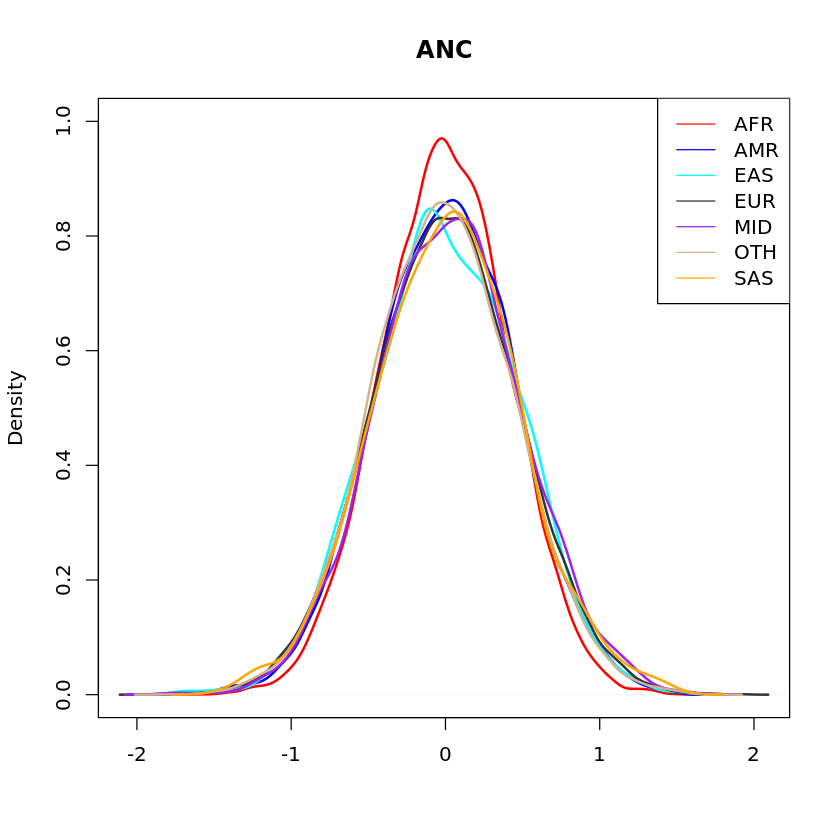

In [31]:
prs.density.all <- density(merge.dt$PRS.ADJ.ANC)
prs.density.afr <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="AFR"])
prs.density.amr <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="AMR"])
prs.density.eas <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="EAS"])
prs.density.eur <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="EUR"])
prs.density.mid <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="MID"])
prs.density.oth <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="OTH"])
prs.density.sas <- density(merge.dt$PRS.ADJ.ANC[merge.dt$my.ancestry=="SAS"])
plot(prs.density.all, main="ANC",ylim=c(0,1),type="n",xlab="")
lines(prs.density.afr, col="red",lwd=2)
lines(prs.density.amr, col="blue",lwd=2)
lines(prs.density.eas, col="cyan",lwd=2)
lines(prs.density.eur, col="gray20",lwd=2)
lines(prs.density.mid, col="purple",lwd=2)
lines(prs.density.oth, col="tan",lwd=2)
lines(prs.density.sas, col="orange",lwd=2)
#legend("topright",legend=c("All","AFR","AMR","EAS","EUR","MID","OTH","SAS"),
#       col=c("black","red","blue","cyan","gray20","purple","tan","orange"),lty=1)
legend("topright",legend=c("AFR","AMR","EAS","EUR","MID","OTH","SAS"),
       col=c("red","blue","cyan","gray20","purple","tan","orange"),lty=1)

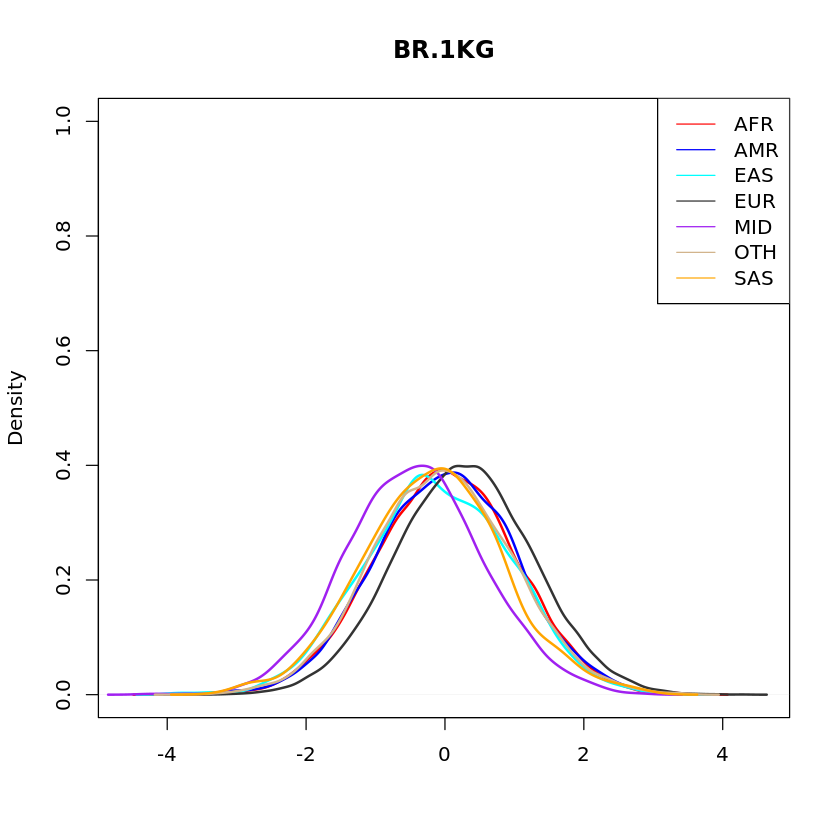

In [30]:
prs.density.all <- density(merge.dt$PRS.BR.REF)
prs.density.afr <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="AFR"])
prs.density.amr <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="AMR"])
prs.density.eas <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="EAS"])
prs.density.eur <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="EUR"])
prs.density.mid <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="MID"])
prs.density.oth <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="OTH"])
prs.density.sas <- density(merge.dt$PRS.BR.REF[merge.dt$my.ancestry=="SAS"])
plot(prs.density.all, main="BR.1KG",ylim=c(0,1),type="n",xlab="")
lines(prs.density.afr, col="red",lwd=2)
lines(prs.density.amr, col="blue",lwd=2)
lines(prs.density.eas, col="cyan",lwd=2)
lines(prs.density.eur, col="gray20",lwd=2)
lines(prs.density.mid, col="purple",lwd=2)
lines(prs.density.oth, col="tan",lwd=2)
lines(prs.density.sas, col="orange",lwd=2)
#legend("topright",legend=c("All","AFR","AMR","EAS","EUR","MID","OTH","SAS"),
#       col=c("black","red","blue","cyan","gray20","purple","tan","orange"),lty=1)
legend("topright",legend=c("AFR","AMR","EAS","EUR","MID","OTH","SAS"),
       col=c("red","blue","cyan","gray20","purple","tan","orange"),lty=1)

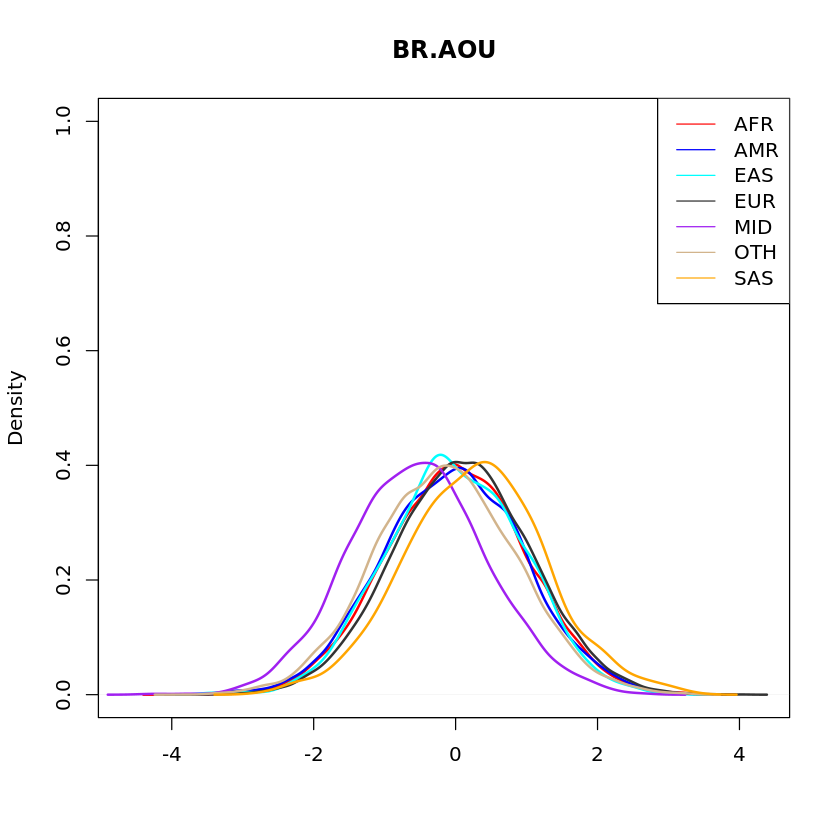

In [29]:
prs.density.all <- density(merge.dt$PRS.BR.AOU1)
prs.density.afr <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="AFR"])
prs.density.amr <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="AMR"])
prs.density.eas <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="EAS"])
prs.density.eur <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="EUR"])
prs.density.mid <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="MID"])
prs.density.oth <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="OTH"])
prs.density.sas <- density(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry=="SAS"])
plot(prs.density.all, main="BR.AOU",ylim=c(0,1),type="n",xlab="")
lines(prs.density.afr, col="red",lwd=2)
lines(prs.density.amr, col="blue",lwd=2)
lines(prs.density.eas, col="cyan",lwd=2)
lines(prs.density.eur, col="gray20",lwd=2)
lines(prs.density.mid, col="purple",lwd=2)
lines(prs.density.oth, col="tan",lwd=2)
lines(prs.density.sas, col="orange",lwd=2)
#legend("topright",legend=c("All","AFR","AMR","EAS","EUR","MID","OTH","SAS"),
#       col=c("black","red","blue","cyan","gray20","purple","tan","orange"),lty=1)
legend("topright",legend=c("AFR","AMR","EAS","EUR","MID","OTH","SAS"),
       col=c("red","blue","cyan","gray20","purple","tan","orange"),lty=1)

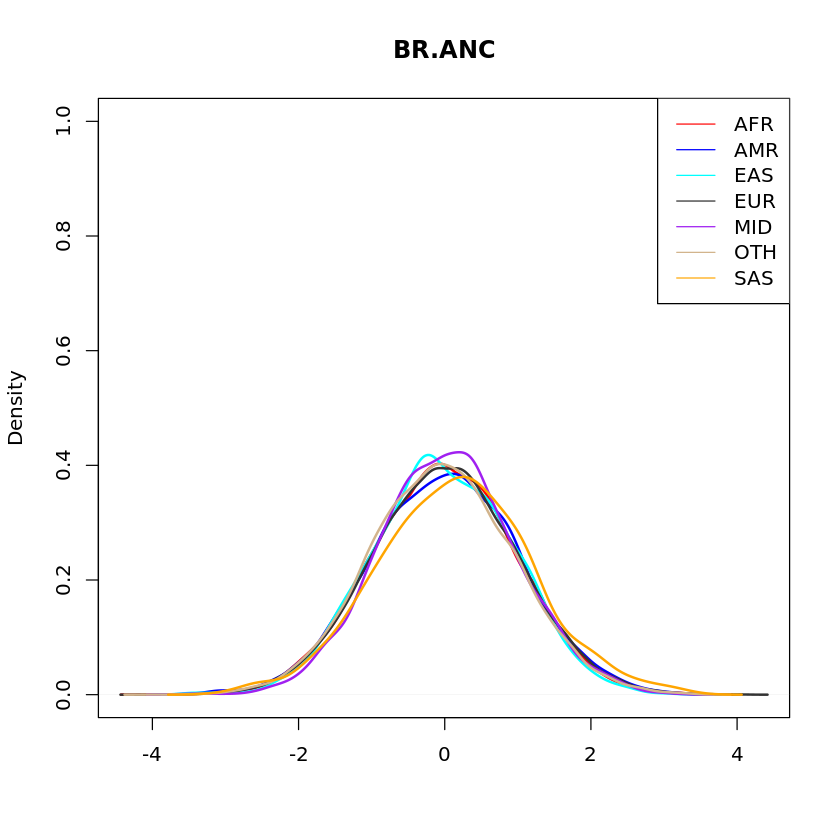

In [28]:
prs.density.all <- density(merge.dt$PRS.BR.ANC.AOU1)
prs.density.afr <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="AFR"])
prs.density.amr <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="AMR"])
prs.density.eas <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="EAS"])
prs.density.eur <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="EUR"])
prs.density.mid <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="MID"])
prs.density.oth <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="OTH"])
prs.density.sas <- density(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry=="SAS"])
plot(prs.density.all, main="BR.ANC",ylim=c(0,1),type="n",xlab="")
lines(prs.density.afr, col="red",lwd=2)
lines(prs.density.amr, col="blue",lwd=2)
lines(prs.density.eas, col="cyan",lwd=2)
lines(prs.density.eur, col="gray20",lwd=2)
lines(prs.density.mid, col="purple",lwd=2)
lines(prs.density.oth, col="tan",lwd=2)
lines(prs.density.sas, col="orange",lwd=2)
#legend("topright",legend=c("All","AFR","AMR","EAS","EUR","MID","OTH","SAS"),
#       col=c("black","red","blue","cyan","gray20","purple","tan","orange"),lty=1)
legend("topright",legend=c("AFR","AMR","EAS","EUR","MID","OTH","SAS"),
       col=c("red","blue","cyan","gray20","purple","tan","orange"),lty=1)

# Check if we need to adjust for UC

In [21]:
# check if UC1 or UC2 needs to be included in the model
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=merge.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=merge.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4191  -0.1385  -0.1097  -0.0842   3.6418  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.958708   0.162476 -42.829  < 2e-16 ***
norm.PRS      0.339487   0.039006   8.704  < 2e-16 ***
sex           0.214158   0.078511   2.728  0.00638 ** 
censored.age  0.033908   0.002606  13.009  < 2e-16 ***
UC1           1.156380   0.196320   5.890 3.86e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7547.4  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7557.4

Number of Fisher Scoring iterations: 8



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4127  -0.1389  -0.1101  -0.0845   3.6402  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.956368   0.162386 -42.838  < 2e-16 ***
norm.PRS      0.339548   0.039008   8.705  < 2e-16 ***
sex           0.213342   0.078502   2.718  0.00657 ** 
censored.age  0.034058   0.002604  13.077  < 2e-16 ***
UC2           1.110916   0.242706   4.577 4.71e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7557.4  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7567.4

Number of Fisher Scoring iterations: 8


In [22]:
my.model <- glm(CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + UC1, data=merge.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + UC2, data=merge.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + 
    UC1, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4224  -0.1383  -0.1094  -0.0840   3.6462  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.957478   0.162218 -42.890  < 2e-16 ***
norm.PRS.ADJ.PC  0.349081   0.038898   8.974  < 2e-16 ***
sex              0.214883   0.078521   2.737  0.00621 ** 
censored.age     0.033829   0.002603  12.998  < 2e-16 ***
UC1              1.152349   0.196329   5.869 4.37e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7542.8  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7552.8

Number of Fisher Scoring iterations: 8



Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + 
    UC2, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4158  -0.1387  -0.1097  -0.0843   3.6446  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.95513    0.16213 -42.899  < 2e-16 ***
norm.PRS.ADJ.PC  0.34920    0.03890   8.978  < 2e-16 ***
sex              0.21412    0.07851   2.727  0.00639 ** 
censored.age     0.03398    0.00260  13.066  < 2e-16 ***
UC2              1.10611    0.24271   4.557 5.18e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7552.7  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7562.7

Number of Fisher Scoring iterations: 8


In [23]:
my.model <- glm(CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + UC1, data=merge.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + UC2, data=merge.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + 
    UC1, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4291  -0.1379  -0.1086  -0.0834   3.6710  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.953953   0.161913 -42.949  < 2e-16 ***
norm.PRS.ADJ.ANC  0.378829   0.038899   9.739  < 2e-16 ***
sex               0.213640   0.078537   2.720  0.00652 ** 
censored.age      0.033592   0.002598  12.929  < 2e-16 ***
UC1               1.145430   0.196391   5.832 5.46e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7528.5  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7538.5

Number of Fisher Scoring iterations: 8



Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + 
    UC2, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4223  -0.1383  -0.1089  -0.0837   3.6694  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.951682   0.161825 -42.958  < 2e-16 ***
norm.PRS.ADJ.ANC  0.379072   0.038897   9.746  < 2e-16 ***
sex               0.212866   0.078528   2.711  0.00671 ** 
censored.age      0.033742   0.002596  12.997  < 2e-16 ***
UC2               1.098094   0.242778   4.523  6.1e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7538.4  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7548.4

Number of Fisher Scoring iterations: 8


In [24]:
my.model <- glm(CRC.status ~ PRS.BR.AOU1 + sex + censored.age + UC1, data=merge.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ PRS.BR.AOU1 + sex + censored.age + UC2, data=merge.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ PRS.BR.AOU1 + sex + censored.age + 
    UC1, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4218  -0.1386  -0.1095  -0.0840   3.6356  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.956664   0.162321 -42.857  < 2e-16 ***
PRS.BR.AOU1   0.347880   0.039498   8.807  < 2e-16 ***
sex           0.214691   0.078517   2.734  0.00625 ** 
censored.age  0.033835   0.002603  12.997  < 2e-16 ***
UC1           1.152267   0.196313   5.870 4.37e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7545.6  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7555.6

Number of Fisher Scoring iterations: 8



Call:
glm(formula = CRC.status ~ PRS.BR.AOU1 + sex + censored.age + 
    UC2, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4153  -0.1391  -0.1098  -0.0843   3.6339  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -6.954344   0.162231 -42.867  < 2e-16 ***
PRS.BR.AOU1   0.348022   0.039499   8.811  < 2e-16 ***
sex           0.213912   0.078508   2.725  0.00644 ** 
censored.age  0.033984   0.002601  13.065  < 2e-16 ***
UC2           1.106318   0.242693   4.558 5.15e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7555.6  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7565.6

Number of Fisher Scoring iterations: 8


In [25]:
my.model <- glm(CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + UC1, data=merge.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + UC2, data=merge.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + 
    UC1, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4335  -0.1382  -0.1088  -0.0834   3.6625  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.95815    0.16211 -42.922  < 2e-16 ***
PRS.BR.ANC.AOU1  0.37629    0.03947   9.533  < 2e-16 ***
sex              0.21341    0.07853   2.718  0.00658 ** 
censored.age     0.03371    0.00260  12.967  < 2e-16 ***
UC1              1.14621    0.19637   5.837 5.31e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7532.4  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7542.4

Number of Fisher Scoring iterations: 8



Call:
glm(formula = CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + 
    UC2, family = "binomial", data = merge.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4267  -0.1387  -0.1092  -0.0837   3.6610  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -6.955932   0.162023 -42.932  < 2e-16 ***
PRS.BR.ANC.AOU1  0.376529   0.039470   9.540  < 2e-16 ***
sex              0.212633   0.078522   2.708  0.00677 ** 
censored.age     0.033859   0.002598  13.035  < 2e-16 ***
UC2              1.099215   0.242750   4.528 5.95e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7846.4  on 89592  degrees of freedom
Residual deviance: 7542.3  on 89588  degrees of freedom
  (8663 observations deleted due to missingness)
AIC: 7552.3

Number of Fisher Scoring iterations: 8


In [ ]:
# Using the whole data set, CRC.status is associated with UC1 and UC2
# What about in the cleaned data?

In [26]:

my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=merge2.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=merge2.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5373  -0.2618  -0.2196  -0.1847   3.1241  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.745508   0.286125 -13.090  < 2e-16 ***
norm.PRS      0.450943   0.054486   8.276  < 2e-16 ***
sex           0.385779   0.110590   3.488 0.000486 ***
censored.age -0.001654   0.004684  -0.353 0.724033    
UC1           0.287867   0.243081   1.184 0.236316    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3086.8  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3096.8

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5265  -0.2617  -0.2197  -0.1849   3.1218  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.728412   0.286819 -12.999  < 2e-16 ***
norm.PRS      0.450693   0.054470   8.274  < 2e-16 ***
sex           0.386770   0.110588   3.497  0.00047 ***
censored.age -0.001831   0.004701  -0.389  0.69692    
UC2           0.223193   0.302875   0.737  0.46117    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3087.6  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3097.6

Number of Fisher Scoring iterations: 6


In [27]:

my.model <- glm(CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + UC1, data=merge2.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + UC2, data=merge2.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + 
    UC1, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5397  -0.2616  -0.2193  -0.1843   3.1197  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.737339   0.285709 -13.081  < 2e-16 ***
norm.PRS.ADJ.PC  0.455665   0.054317   8.389  < 2e-16 ***
sex              0.383429   0.110617   3.466 0.000528 ***
censored.age    -0.001829   0.004679  -0.391 0.695838    
UC1              0.283954   0.243120   1.168 0.242824    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3085.1  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3095.1

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.PC + sex + censored.age + 
    UC2, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5315  -0.2613  -0.2192  -0.1844   3.1174  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.719826   0.286392 -12.989  < 2e-16 ***
norm.PRS.ADJ.PC  0.455420   0.054299   8.387  < 2e-16 ***
sex              0.384398   0.110615   3.475 0.000511 ***
censored.age    -0.002013   0.004696  -0.429 0.668185    
UC2              0.216843   0.302918   0.716 0.474085    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3085.9  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3095.9

Number of Fisher Scoring iterations: 6


In [28]:

my.model <- glm(CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + UC1, data=merge2.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + UC2, data=merge2.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + 
    UC1, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5343  -0.2617  -0.2190  -0.1838   3.0427  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.726670   0.284922 -13.080  < 2e-16 ***
norm.PRS.ADJ.ANC  0.461775   0.054572   8.462  < 2e-16 ***
sex               0.379067   0.110618   3.427 0.000611 ***
censored.age     -0.002120   0.004667  -0.454 0.649553    
UC1               0.274544   0.243150   1.129 0.258850    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3083.9  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3093.9

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ norm.PRS.ADJ.ANC + sex + censored.age + 
    UC2, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5304  -0.2621  -0.2190  -0.1840   3.0413  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.709279   0.285548 -12.990  < 2e-16 ***
norm.PRS.ADJ.ANC  0.461686   0.054559   8.462  < 2e-16 ***
sex               0.380054   0.110616   3.436 0.000591 ***
censored.age     -0.002306   0.004682  -0.492 0.622428    
UC2               0.208080   0.302888   0.687 0.492092    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3084.6  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3094.6

Number of Fisher Scoring iterations: 6


In [29]:
my.model <- glm(CRC.status ~ PRS.BR.AOU1 + sex + censored.age + UC1, data=merge2.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ PRS.BR.AOU1 + sex + censored.age + UC2, data=merge2.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ PRS.BR.AOU1 + sex + censored.age + 
    UC1, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5440  -0.2618  -0.2197  -0.1841   3.1092  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.743311   0.285917 -13.092  < 2e-16 ***
PRS.BR.AOU1   0.464019   0.055752   8.323  < 2e-16 ***
sex           0.382600   0.110602   3.459 0.000542 ***
censored.age -0.001741   0.004680  -0.372 0.709878    
UC1           0.282898   0.243097   1.164 0.244535    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3086.0  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3096

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ PRS.BR.AOU1 + sex + censored.age + 
    UC2, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5191  -0.2618  -0.2196  -0.1844   3.1069  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.726208   0.286609 -13.001  < 2e-16 ***
PRS.BR.AOU1   0.463840   0.055739   8.322  < 2e-16 ***
sex           0.383589   0.110600   3.468 0.000524 ***
censored.age -0.001919   0.004696  -0.409 0.682768    
UC2           0.217392   0.302868   0.718 0.472894    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3086.8  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3096.8

Number of Fisher Scoring iterations: 6


In [30]:
my.model <- glm(CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + UC1, data=merge2.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + UC2, data=merge2.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + 
    UC1, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5431  -0.2620  -0.2192  -0.1836   3.0372  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.736161   0.285249 -13.098  < 2e-16 ***
PRS.BR.ANC.AOU1  0.472662   0.055952   8.448  < 2e-16 ***
sex              0.379253   0.110609   3.429 0.000606 ***
censored.age    -0.001962   0.004669  -0.420 0.674319    
UC1              0.273426   0.243136   1.125 0.260767    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3084.0  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3094

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ PRS.BR.ANC.AOU1 + sex + censored.age + 
    UC2, family = "binomial", data = merge2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5238  -0.2622  -0.2192  -0.1838   3.0360  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.718997   0.285890 -13.008  < 2e-16 ***
PRS.BR.ANC.AOU1  0.472607   0.055942   8.448  < 2e-16 ***
sex              0.380251   0.110607   3.438 0.000586 ***
censored.age    -0.002144   0.004685  -0.458 0.647157    
UC2              0.207355   0.302857   0.685 0.493557    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3169.3  on 12583  degrees of freedom
Residual deviance: 3084.7  on 12579  degrees of freedom
  (142 observations deleted due to missingness)
AIC: 3094.7

Number of Fisher Scoring iterations: 6


In [ ]:
# there isn't enough power in the cleaned cases and screened controls to detect an effect of UC1 or UC2. 

In [33]:
keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][merge2.dt$my.ancestry == keep.ancestry]
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=subset.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=subset.dt,family="binomial")
summary(my.model)



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5132  -0.2340  -0.1793  -0.1529   3.0826  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.55691    0.86596  -5.262 1.42e-07 ***
norm.PRS      0.34469    0.18214   1.892  0.05843 .  
sex           0.89380    0.31668   2.822  0.00477 ** 
censored.age  0.00334    0.01440   0.232  0.81658    
UC1           0.57174    0.62054   0.921  0.35686    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 408.22  on 2013  degrees of freedom
Residual deviance: 394.86  on 2009  degrees of freedom
  (40 observations deleted due to missingness)
AIC: 404.86

Number of Fisher Scoring iterations: 7



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3982  -0.2338  -0.1797  -0.1539   3.0675  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.428049   0.871733  -5.080 3.78e-07 ***
norm.PRS      0.346833   0.182341   1.902  0.05716 .  
sex           0.901686   0.316332   2.850  0.00437 ** 
censored.age  0.001597   0.014566   0.110  0.91270    
UC2          -0.123115   1.033808  -0.119  0.90521    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 408.22  on 2013  degrees of freedom
Residual deviance: 395.59  on 2009  degrees of freedom
  (40 observations deleted due to missingness)
AIC: 405.59

Number of Fisher Scoring iterations: 7


In [34]:
keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][merge2.dt$my.ancestry == keep.ancestry]
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=subset.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=subset.dt,family="binomial")
summary(my.model)



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6440  -0.2537  -0.1890  -0.1449   3.0320  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)    -2.60891    1.15767  -2.254  0.02422 * 
norm.PRS        0.76632    0.28047   2.732  0.00629 **
sex             0.38219    0.51927   0.736  0.46173   
censored.age   -0.02334    0.02090  -1.117  0.26399   
UC1           -15.09306 1305.55464  -0.012  0.99078   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 148.56  on 618  degrees of freedom
Residual deviance: 137.49  on 614  degrees of freedom
  (2 observations deleted due to missingness)
AIC: 147.49

Number of Fisher Scoring iterations: 17



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6281  -0.2522  -0.1922  -0.1463   3.0368  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)    -2.65863    1.15832  -2.295  0.02172 * 
norm.PRS        0.76170    0.28214   2.700  0.00694 **
sex             0.36330    0.51862   0.701  0.48361   
censored.age   -0.02274    0.02088  -1.089  0.27605   
UC2           -13.88412 1137.70824  -0.012  0.99026   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 148.56  on 618  degrees of freedom
Residual deviance: 138.37  on 614  degrees of freedom
  (2 observations deleted due to missingness)
AIC: 148.37

Number of Fisher Scoring iterations: 16


In [35]:
keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][merge2.dt$my.ancestry == keep.ancestry]
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=subset.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=subset.dt,family="binomial")
summary(my.model)



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6413  -0.2731  -0.2262  -0.1857   3.1044  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.144325   0.403239 -10.278  < 2e-16 ***
norm.PRS      0.505906   0.070548   7.171 7.44e-13 ***
sex           0.190554   0.146135   1.304   0.1922    
censored.age  0.006071   0.006417   0.946   0.3441    
UC1           0.626521   0.297597   2.105   0.0353 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1816.1  on 6759  degrees of freedom
Residual deviance: 1758.0  on 6755  degrees of freedom
  (69 observations deleted due to missingness)
AIC: 1768

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6429  -0.2730  -0.2265  -0.1863   3.1004  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.134675   0.404994 -10.209  < 2e-16 ***
norm.PRS      0.504317   0.070451   7.158 8.16e-13 ***
sex           0.191105   0.146081   1.308   0.1908    
censored.age  0.006080   0.006446   0.943   0.3456    
UC2           0.625830   0.355032   1.763   0.0779 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1816.1  on 6759  degrees of freedom
Residual deviance: 1759.2  on 6755  degrees of freedom
  (69 observations deleted due to missingness)
AIC: 1769.2

Number of Fisher Scoring iterations: 6


In [36]:
keep.ancestry <- "MID"
subset.dt <- merge2.dt[][merge2.dt$my.ancestry == keep.ancestry]
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=subset.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=subset.dt,family="binomial")
summary(my.model)


Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3139  -0.2860  -0.1844  -0.1723   3.0440  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.018172   1.215971  -3.304 0.000951 ***
norm.PRS      0.050037   0.211343   0.237 0.812846    
sex           1.021787   0.484734   2.108 0.035037 *  
censored.age -0.002208   0.017988  -0.123 0.902316    
UC1          -0.333512   1.054997  -0.316 0.751907    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 210.65  on 835  degrees of freedom
Residual deviance: 205.37  on 831  degrees of freedom
  (8 observations deleted due to missingness)
AIC: 215.37

Number of Fisher Scoring iterations: 7



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3112  -0.2845  -0.1821  -0.1716   2.9495  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.100554   1.207606  -3.396 0.000685 ***
norm.PRS      0.053000   0.211962   0.250 0.802551    
sex           1.017276   0.484392   2.100 0.035719 *  
censored.age -0.001108   0.017834  -0.062 0.950449    
UC2          -0.027762   1.058738  -0.026 0.979081    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 210.65  on 835  degrees of freedom
Residual deviance: 205.48  on 831  degrees of freedom
  (8 observations deleted due to missingness)
AIC: 215.48

Number of Fisher Scoring iterations: 7


In [37]:
keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][merge2.dt$my.ancestry == keep.ancestry]
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC1, data=subset.dt,family="binomial")
summary(my.model)
my.model <- glm(CRC.status ~ norm.PRS + sex + censored.age + UC2, data=subset.dt,family="binomial")
summary(my.model)



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC1, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5470  -0.2603  -0.2154  -0.1707   3.0492  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.28649    0.63425  -3.605 0.000312 ***
norm.PRS       0.43870    0.13595   3.227 0.001251 ** 
sex            0.52595    0.27388   1.920 0.054809 .  
censored.age  -0.02570    0.01122  -2.291 0.021963 *  
UC1          -15.23875  600.11844  -0.025 0.979742    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 524.69  on 2119  degrees of freedom
Residual deviance: 500.17  on 2115  degrees of freedom
  (22 observations deleted due to missingness)
AIC: 510.17

Number of Fisher Scoring iterations: 17



Call:
glm(formula = CRC.status ~ norm.PRS + sex + censored.age + UC2, 
    family = "binomial", data = subset.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5393  -0.2590  -0.2150  -0.1726   3.0492  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -2.30564    0.63123  -3.653  0.00026 ***
norm.PRS       0.43189    0.13587   3.179  0.00148 ** 
sex            0.52801    0.27384   1.928  0.05383 .  
censored.age  -0.02572    0.01116  -2.305  0.02116 *  
UC2          -15.28230  733.01221  -0.021  0.98337    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 524.69  on 2119  degrees of freedom
Residual deviance: 502.52  on 2115  degrees of freedom
  (22 observations deleted due to missingness)
AIC: 512.52

Number of Fisher Scoring iterations: 17


In [ ]:
# Only in the EUR subset is there enough power to detect an effect of UC1 or UC2. 
# For now, I think it is okay to disregard UC1 and UC2 since the smaller sample sizes of the other groups is an issue

# Get OR with and without adjusting for age, sex

# Set up lists for the OR

In [16]:
# making 5 comparisons where there is potentially enough data (AFR, AMR, EUR, MID, OTH)
OR.list <- vector(mode="list",length=5) # only 
p.sex.age.list <- vector(mode="list",length=5)

In [17]:
# set the iterator so that I can add to the list easily
ancestry.iter <- 0

# Calculate OR and CI, cleaned cases vs screened controls

In [18]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table
# all the OR (CI) are exactly the same for AFR (even without rounding)
OR.list[[ancestry.iter]] <- out.table
OR.list

# get sex and age p-values
covar <- c("Sex","Age")
out.table <- data.table(cbind(covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC))
col.names <- c("Covar","p.raw","p.PC","p.ANC","p.BROAD","p.BRANC")
setnames(out.table,col.names)
p.sex.age.list[[ancestry.iter]] <- out.table
p.sex.age.list


[1] 1

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2012
1,1,0,42


subset.dt$my.PRS 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    2054        0     2054        1  0.09859   0.9925  -1.3486  -1.0506 
     .25      .50      .75      .90      .95 
 -0.4892   0.1175   0.7213   1.2211   1.4692 

lowest : -2.93451 -2.7591  -2.48425 -2.41325 -2.34971
highest: 2.42103  2.50767  2.69652  2.72323  2.90705 

1.45,"1.02,2.08"
1.41,"0.99,2.02"


[1] "4.37e-03" "0.9"

[1] "4.30e-03" "0.9"

[1] "4.30e-03" "0.9"

 
NULL


1.4,"1.01,1.93"
1.36,"0.99,1.88"


[1] "4.35e-03" "0.9"

 
NULL


1.39,"1.01,1.91"
1.36,"0.98,1.87"


[1] "4.32e-03" "0.9"

OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"


OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"


Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.37e-03,4.30e-03,4.30e-03,4.35e-03,4.32e-03
Age,0.9,0.9,0.9,0.9,0.9


In [ ]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table
# all the OR (CI) are exactly the same for AFR (even without rounding)
OR.list[[ancestry.iter]] <- out.table
OR.list

# get sex and age p-values
covar <- c("Sex","Age")
out.table <- data.table(cbind(covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC))
col.names <- c("Covar","p.raw","p.PC","p.ANC","p.BROAD","p.BRANC")
setnames(out.table,col.names)
p.sex.age.list[[ancestry.iter]] <- out.table
p.sex.age.list


In [20]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table
# all the OR (CI) are exactly the same for AFR (even without rounding)
OR.list[[ancestry.iter]] <- out.table
OR.list

# get sex and age p-values
covar <- c("Sex","Age")
out.table <- data.table(cbind(covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC))
col.names <- c("Covar","p.raw","p.PC","p.ANC","p.BROAD","p.BRANC")
setnames(out.table,col.names)
p.sex.age.list[[ancestry.iter]] <- out.table
p.sex.age.list


[1] 3

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,6625
1,1,0,204


subset.dt$my.PRS 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    6829        0     6829        1  0.09254    1.162  -1.5774  -1.2078 
     .25      .50      .75      .90      .95 
 -0.6262   0.1056   0.7942   1.4122   1.7644 

lowest : -3.3558  -3.27094 -3.2407  -3.16718 -3.11922
highest: 3.37602  3.41237  3.44732  3.745    3.93115 

1.64,"1.43,1.89"
1.65,"1.44,1.9"


[1] "1.97e-01" "0.44"

[1] "1.96e-01" "0.44"

[1] "1.98e-01" "0.44"

 
NULL


1.69,"1.46,1.95"
1.7,"1.47,1.96"


[1] "1.96e-01" "0.44"

 
NULL


1.67,"1.45,1.92"
1.68,"1.46,1.93"


[1] "1.98e-01" "0.44"

OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"
1.65,"1.44,1.9",1.65,"1.44,1.9",1.64,"1.44,1.88",1.7,"1.47,1.96",1.68,"1.46,1.93"


OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.21,"1.27,3.85",2.19,"1.26,3.8",2.22,"1.29,3.84",2.17,"1.26,3.72",2.19,"1.28,3.72"
2.16,"1.24,3.75",2.13,"1.23,3.7",2.17,"1.26,3.74",2.11,"1.23,3.61",2.13,"1.25,3.63"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"


Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.37e-03,4.30e-03,4.30e-03,4.35e-03,4.32e-03
Age,0.9,0.9,0.9,0.9,0.9
Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.86e-01,4.82e-01,4.84e-01,4.84e-01,4.83e-01
Age,0.3,0.3,0.3,0.31,0.3
Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,1.97e-01,1.96e-01,1.98e-01,1.96e-01,1.98e-01


In [21]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table
# all the OR (CI) are exactly the same for AFR (even without rounding)
OR.list[[ancestry.iter]] <- out.table
OR.list

# get sex and age p-values
covar <- c("Sex","Age")
out.table <- data.table(cbind(covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC))
col.names <- c("Covar","p.raw","p.PC","p.ANC","p.BROAD","p.BRANC")
setnames(out.table,col.names)
p.sex.age.list[[ancestry.iter]] <- out.table
p.sex.age.list


[1] 4

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,821
1,1,0,23


subset.dt$my.PRS 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
     844        0      844        1  -0.5997     1.13 -2.26682 -1.82725 
     .25      .50      .75      .90      .95 
-1.29828 -0.61011  0.09169  0.68099  0.98652 

lowest : -4.68106 -4.08242 -3.57604 -3.23354 -3.16605
highest: 1.87758  2.00848  2.04814  2.1076   2.67928 

1.08,"0.71,1.63"
1.05,"0.7,1.6"


[1] "3.57e-02" "0.95"

[1] "3.57e-02" "0.95"

[1] "3.62e-02" "0.95"

 
NULL


1.08,"0.7,1.67"
1.05,"0.68,1.63"


[1] "3.57e-02" "0.95"

 
NULL


1.12,"0.71,1.77"
1.09,"0.69,1.73"


[1] "3.62e-02" "0.95"

OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.08,"0.71,1.63",1.08,"0.72,1.63",1.11,"0.74,1.67",1.08,"0.7,1.67",1.12,"0.71,1.77"
1.05,"0.7,1.6",1.05,"0.7,1.59",1.08,"0.72,1.63",1.05,"0.68,1.63",1.09,"0.69,1.73"


OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.21,"1.27,3.85",2.19,"1.26,3.8",2.22,"1.29,3.84",2.17,"1.26,3.72",2.19,"1.28,3.72"
2.16,"1.24,3.75",2.13,"1.23,3.7",2.17,"1.26,3.74",2.11,"1.23,3.61",2.13,"1.25,3.63"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"


Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.37e-03,4.30e-03,4.30e-03,4.35e-03,4.32e-03
Age,0.9,0.9,0.9,0.9,0.9
Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.86e-01,4.82e-01,4.84e-01,4.84e-01,4.83e-01
Age,0.3,0.3,0.3,0.31,0.3
Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,1.97e-01,1.96e-01,1.98e-01,1.96e-01,1.98e-01


In [22]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table
# all the OR (CI) are exactly the same for AFR (even without rounding)
OR.list[[ancestry.iter]] <- out.table
OR.list

# get sex and age p-values
covar <- c("Sex","Age")
out.table <- data.table(cbind(covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC))
col.names <- c("Covar","p.raw","p.PC","p.ANC","p.BROAD","p.BRANC")
setnames(out.table,col.names)
p.sex.age.list[[ancestry.iter]] <- out.table
p.sex.age.list


[1] 5

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2085
1,1,0,57


subset.dt$my.PRS 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    2142        0     2142        1  -0.1919    1.139  -1.8185  -1.4628 
     .25      .50      .75      .90      .95 
 -0.8513  -0.1912   0.4769   1.0891   1.4939 

lowest : -3.39778 -3.27785 -3.12361 -3.08894 -2.9777 
highest: 2.52228  2.57313  2.68368  2.95136  3.20206 

1.52,"1.17,1.98"
1.54,"1.18,2.01"


[1] "6.40e-02" "0.05"

[1] "6.92e-02" "0.05"

[1] "7.35e-02" "0.04"

 
NULL


1.52,"1.17,1.99"
1.55,"1.18,2.02"


[1] "6.79e-02" "0.05"

 
NULL


1.53,"1.17,2"
1.55,"1.18,2.04"


[1] "7.27e-02" "0.04"

OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.52,"1.17,1.98",1.51,"1.16,1.97",1.51,"1.16,1.97",1.52,"1.17,1.99",1.53,"1.17,2"
1.54,"1.18,2.01",1.53,"1.17,2",1.53,"1.18,2",1.55,"1.18,2.02",1.55,"1.18,2.04"


OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.21,"1.27,3.85",2.19,"1.26,3.8",2.22,"1.29,3.84",2.17,"1.26,3.72",2.19,"1.28,3.72"
2.16,"1.24,3.75",2.13,"1.23,3.7",2.17,"1.26,3.74",2.11,"1.23,3.61",2.13,"1.25,3.63"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"


Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.37e-03,4.30e-03,4.30e-03,4.35e-03,4.32e-03
Age,0.9,0.9,0.9,0.9,0.9
Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.86e-01,4.82e-01,4.84e-01,4.84e-01,4.83e-01
Age,0.3,0.3,0.3,0.31,0.3
Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,1.97e-01,1.96e-01,1.98e-01,1.96e-01,1.98e-01


In [23]:
# checkpoint

In [24]:
OR.list

OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.21,"1.27,3.85",2.19,"1.26,3.8",2.22,"1.29,3.84",2.17,"1.26,3.72",2.19,"1.28,3.72"
2.16,"1.24,3.75",2.13,"1.23,3.7",2.17,"1.26,3.74",2.11,"1.23,3.61",2.13,"1.25,3.63"
OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"


In [25]:
# put into a single table with do.call
# will need to fix the column names for ancestry
str(OR.list)
(out.table <- data.table(do.call("rbind", OR.list)))

#str(OR.list[[1]])
#OR.list[[1]]$OR.raw
#OR.list[[1]]$CI.raw
#OR.list[[1]][,list(OR.raw,CI.raw)]
#left.col <- c("Unadjusted","Adjusted")
#(out.table <- data.table(cbind(left.col,OR.list[[1]][,list(OR.raw,CI.raw)],OR.list[[2]][,list(OR.raw,CI.raw)],
#      OR.list[[3]][,list(OR.raw,CI.raw)],OR.list[[4]][,list(OR.raw,CI.raw)])) )



List of 5
 $ :Classes ‘data.table’ and 'data.frame':	2 obs. of  10 variables:
  ..$ OR.raw  : chr [1:2] "1.45" "1.41"
  ..$ CI.raw  : chr [1:2] "1.02,2.08" "0.99,2.02"
  ..$ OR.PC   : chr [1:2] "1.45" "1.42"
  ..$ CI.PC   : chr [1:2] "1.02,2.07" "0.99,2.02"
  ..$ OR.ANC  : chr [1:2] "1.44" "1.4"
  ..$ CI.ANC  : chr [1:2] "1.01,2.04" "0.98,1.99"
  ..$ OR.BROAD: chr [1:2] "1.4" "1.36"
  ..$ CI.BROAD: chr [1:2] "1.01,1.93" "0.99,1.88"
  ..$ OR.BRANC: chr [1:2] "1.39" "1.36"
  ..$ CI.BRANC: chr [1:2] "1.01,1.91" "0.98,1.87"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	2 obs. of  10 variables:
  ..$ OR.raw  : chr [1:2] "2.21" "2.16"
  ..$ CI.raw  : chr [1:2] "1.27,3.85" "1.24,3.75"
  ..$ OR.PC   : chr [1:2] "2.19" "2.13"
  ..$ CI.PC   : chr [1:2] "1.26,3.8" "1.23,3.7"
  ..$ OR.ANC  : chr [1:2] "2.22" "2.17"
  ..$ CI.ANC  : chr [1:2] "1.29,3.84" "1.26,3.74"
  ..$ OR.BROAD: chr [1:2] "2.17" "2.11"
  ..$ CI.BROAD: chr [1:2] "1.26,3.72" "1.23,3.61

OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"
2.21,"1.27,3.85",2.19,"1.26,3.8",2.22,"1.29,3.84",2.17,"1.26,3.72",2.19,"1.28,3.72"
2.16,"1.24,3.75",2.13,"1.23,3.7",2.17,"1.26,3.74",2.11,"1.23,3.61",2.13,"1.25,3.63"
1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"
1.65,"1.44,1.9",1.65,"1.44,1.9",1.64,"1.44,1.88",1.7,"1.47,1.96",1.68,"1.46,1.93"
1.08,"0.71,1.63",1.08,"0.72,1.63",1.11,"0.74,1.67",1.08,"0.7,1.67",1.12,"0.71,1.77"
1.05,"0.7,1.6",1.05,"0.7,1.59",1.08,"0.72,1.63",1.05,"0.68,1.63",1.09,"0.69,1.73"
1.52,"1.17,1.98",1.51,"1.16,1.97",1.51,"1.16,1.97",1.52,"1.17,1.99",1.53,"1.17,2"


In [26]:
ancestries <- c(rep("AFR",2),rep("AMR",2),rep("EUR",2),rep("MID",2),rep("OTH",2))
#keep.cols <- c("OR","CI")
#(new.cols <- paste(ancestries,keep.cols, sep="_"))
#(setnames(out.table,c("Model",new.cols)))
(out.table <- cbind(ancestries, out.table))


ancestries,OR.raw,CI.raw,OR.PC,CI.PC,OR.ANC,CI.ANC,OR.BROAD,CI.BROAD,OR.BRANC,CI.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,1.45,"1.02,2.08",1.45,"1.02,2.07",1.44,"1.01,2.04",1.4,"1.01,1.93",1.39,"1.01,1.91"
AFR,1.41,"0.99,2.02",1.42,"0.99,2.02",1.4,"0.98,1.99",1.36,"0.99,1.88",1.36,"0.98,1.87"
AMR,2.21,"1.27,3.85",2.19,"1.26,3.8",2.22,"1.29,3.84",2.17,"1.26,3.72",2.19,"1.28,3.72"
AMR,2.16,"1.24,3.75",2.13,"1.23,3.7",2.17,"1.26,3.74",2.11,"1.23,3.61",2.13,"1.25,3.63"
EUR,1.64,"1.43,1.89",1.64,"1.43,1.88",1.64,"1.43,1.87",1.69,"1.46,1.95",1.67,"1.45,1.92"
EUR,1.65,"1.44,1.9",1.65,"1.44,1.9",1.64,"1.44,1.88",1.7,"1.47,1.96",1.68,"1.46,1.93"
MID,1.08,"0.71,1.63",1.08,"0.72,1.63",1.11,"0.74,1.67",1.08,"0.7,1.67",1.12,"0.71,1.77"
MID,1.05,"0.7,1.6",1.05,"0.7,1.59",1.08,"0.72,1.63",1.05,"0.68,1.63",1.09,"0.69,1.73"
OTH,1.52,"1.17,1.98",1.51,"1.16,1.97",1.51,"1.16,1.97",1.52,"1.17,1.99",1.53,"1.17,2"


In [27]:
addparentheses <- function(x){paste0("(", x, ")")}
all.cols <- names(out.table)
(CI.cols <- all.cols[all.cols %like% "CI"])
out.table[,(CI.cols):=lapply(.SD, addparentheses), .SDcols=CI.cols]
as.data.frame(out.table) %>%
    unite(RAW,c(OR.raw,CI.raw),sep="") %>%
    unite(PC,c(OR.PC,CI.PC),sep="") %>%
    unite(ANC,c(OR.ANC,CI.ANC),sep="") %>%
    unite(BROAD,c(OR.BROAD,CI.BROAD),sep="") %>%
    unite(BRANC,c(OR.BRANC,CI.BRANC),sep="") 



[1] "CI.raw"   "CI.PC"    "CI.ANC"   "CI.BROAD" "CI.BRANC"

ancestries,RAW,PC,ANC,BROAD,BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,"1.45(1.02,2.08)","1.45(1.02,2.07)","1.44(1.01,2.04)","1.4(1.01,1.93)","1.39(1.01,1.91)"
AFR,"1.41(0.99,2.02)","1.42(0.99,2.02)","1.4(0.98,1.99)","1.36(0.99,1.88)","1.36(0.98,1.87)"
AMR,"2.21(1.27,3.85)","2.19(1.26,3.8)","2.22(1.29,3.84)","2.17(1.26,3.72)","2.19(1.28,3.72)"
AMR,"2.16(1.24,3.75)","2.13(1.23,3.7)","2.17(1.26,3.74)","2.11(1.23,3.61)","2.13(1.25,3.63)"
EUR,"1.64(1.43,1.89)","1.64(1.43,1.88)","1.64(1.43,1.87)","1.69(1.46,1.95)","1.67(1.45,1.92)"
EUR,"1.65(1.44,1.9)","1.65(1.44,1.9)","1.64(1.44,1.88)","1.7(1.47,1.96)","1.68(1.46,1.93)"
MID,"1.08(0.71,1.63)","1.08(0.72,1.63)","1.11(0.74,1.67)","1.08(0.7,1.67)","1.12(0.71,1.77)"
MID,"1.05(0.7,1.6)","1.05(0.7,1.59)","1.08(0.72,1.63)","1.05(0.68,1.63)","1.09(0.69,1.73)"
OTH,"1.52(1.17,1.98)","1.51(1.16,1.97)","1.51(1.16,1.97)","1.52(1.17,1.99)","1.53(1.17,2)"


In [28]:
str(p.sex.age.list)
(out.table <- data.table(do.call("rbind", p.sex.age.list)))
ancestries <- c(rep("AFR",2),rep("AMR",2),rep("EUR",2),rep("MID",2),rep("OTH",2))

(out.table <- cbind(ancestries, out.table))


List of 5
 $ :Classes ‘data.table’ and 'data.frame':	2 obs. of  6 variables:
  ..$ Covar  : chr [1:2] "Sex" "Age"
  ..$ p.raw  : chr [1:2] "4.37e-03" "0.9"
  ..$ p.PC   : chr [1:2] "4.30e-03" "0.9"
  ..$ p.ANC  : chr [1:2] "4.30e-03" "0.9"
  ..$ p.BROAD: chr [1:2] "4.35e-03" "0.9"
  ..$ p.BRANC: chr [1:2] "4.32e-03" "0.9"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	2 obs. of  6 variables:
  ..$ Covar  : chr [1:2] "Sex" "Age"
  ..$ p.raw  : chr [1:2] "4.86e-01" "0.3"
  ..$ p.PC   : chr [1:2] "4.82e-01" "0.3"
  ..$ p.ANC  : chr [1:2] "4.84e-01" "0.3"
  ..$ p.BROAD: chr [1:2] "4.84e-01" "0.31"
  ..$ p.BRANC: chr [1:2] "4.83e-01" "0.3"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	2 obs. of  6 variables:
  ..$ Covar  : chr [1:2] "Sex" "Age"
  ..$ p.raw  : chr [1:2] "1.97e-01" "0.44"
  ..$ p.PC   : chr [1:2] "1.96e-01" "0.44"
  ..$ p.ANC  : chr [1:2] "1.98e-01" "0.44"
  ..$ p.BROAD: chr [1:2] "1.

Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sex,4.37e-03,4.30e-03,4.30e-03,4.35e-03,4.32e-03
Age,0.9,0.9,0.9,0.9,0.9
Sex,4.86e-01,4.82e-01,4.84e-01,4.84e-01,4.83e-01
Age,0.3,0.3,0.3,0.31,0.3
Sex,1.97e-01,1.96e-01,1.98e-01,1.96e-01,1.98e-01
Age,0.44,0.44,0.44,0.44,0.44
Sex,3.57e-02,3.57e-02,3.62e-02,3.57e-02,3.62e-02
Age,0.95,0.95,0.95,0.95,0.95
Sex,6.40e-02,6.92e-02,7.35e-02,6.79e-02,7.27e-02


ancestries,Covar,p.raw,p.PC,p.ANC,p.BROAD,p.BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,Sex,4.37e-03,4.30e-03,4.30e-03,4.35e-03,4.32e-03
AFR,Age,0.9,0.9,0.9,0.9,0.9
AMR,Sex,4.86e-01,4.82e-01,4.84e-01,4.84e-01,4.83e-01
AMR,Age,0.3,0.3,0.3,0.31,0.3
EUR,Sex,1.97e-01,1.96e-01,1.98e-01,1.96e-01,1.98e-01
EUR,Age,0.44,0.44,0.44,0.44,0.44
MID,Sex,3.57e-02,3.57e-02,3.62e-02,3.57e-02,3.62e-02
MID,Age,0.95,0.95,0.95,0.95,0.95
OTH,Sex,6.40e-02,6.92e-02,7.35e-02,6.79e-02,7.27e-02


# Calculatre OR and CI, cleaned cases vs screened controls, AFR sex stratified

In [ ]:
#males
keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry & merge2.dt$sex==1)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
#(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
#(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
#(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
#(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
#(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table

In [ ]:
#females
keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry & merge2.dt$sex==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.PRS:=norm.PRS]
describe(subset.dt$my.PRS)
(OR.raw <-get.OR.round(subset.dt))
#(p.raw <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
OR.PC <- get.OR.round(subset.dt)
#(p.PC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
OR.ANC <- get.OR.round(subset.dt)
#(p.ANC <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BROAD <-get.OR.round(subset.dt))
#(p.BROAD <- get.sex.age.pvalue(subset.dt))
subset.dt[,my.PRS:=PRS.BR.ANC.AOU1] #change made here
describe(subset.dt$my.prs)
(OR.BRANC <-get.OR.round(subset.dt))
#(p.BRANC <- get.sex.age.pvalue(subset.dt))

out.table <- data.table(cbind(OR.raw,OR.PC,OR.ANC,OR.BROAD,OR.BRANC))
col.names <- c("OR.raw","CI.raw","OR.PC","CI.PC","OR.ANC","CI.ANC","OR.BROAD","CI.BROAD","OR.BRANC","CI.BRANC")
setnames(out.table,col.names)
out.table

# Set up lists for the OR comparing top percentile vs middle

In [58]:
OR.T6.list <- vector(mode="list",length=5)
OR.T7.list <- vector(mode="list",length=5)
OR.T8.list <- vector(mode="list",length=5)


# Calculate OR for top percentile (T6) vs middle

In [61]:
# set the iterator so that I can add to the list easily
ancestry.iter <- 0

In [62]:
# T6
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T6.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T6 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T6.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T6 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T6.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T6 <-get.OR.group.round(subset2.dt)

#BROAD PC
subset.dt[,my.group:=T6.PRS.BR.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.AOU1, my.group)
OR.BROAD.T6 <-get.OR.group.round(subset2.dt)

#BROAD ANC
subset.dt[,my.group:=T6.PRS.BR.ANC.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.ANC.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.ANC.AOU1, my.group)
OR.BRANC.T6 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T6,OR.PC.T6,OR.ANC.T6,OR.BROAD.T6,OR.BRANC.T6))
col.names <- c("OR.raw.T6","CI.raw.T6","OR.PC.T6","CI.PC.T6","OR.ANC.T6","CI.ANC.T6","OR.BROAD.T6","CI.BROAD.T6",
               "OR.BRANC.T6","CI.BRANC.T6")
setnames(out.table,col.names)
out.table

OR.T6.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2012
1,1,0,42


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,168
1,0,467


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,127
1,0,467


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,133
1,0,454


T3.PRS.BR.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,183
1,0,414


T3.PRS.BR.ANC.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,174
1,0,414


OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.56,"0.52,4.73",1.49,"0.46,4.82",1.38,"0.42,4.46",1.53,"0.53,4.35",1.33,"0.44,4.03"
1.44,"0.47,4.42",1.41,"0.43,4.61",1.34,"0.41,4.37",1.54,"0.54,4.45",1.32,"0.43,4.01"


In [ ]:
# T6
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T6.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T6 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T6.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T6 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T6.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T6 <-get.OR.group.round(subset2.dt)

#BROAD PC
subset.dt[,my.group:=T6.PRS.BR.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.AOU1, my.group)
OR.BROAD.T6 <-get.OR.group.round(subset2.dt)

#BROAD ANC
subset.dt[,my.group:=T6.PRS.BR.ANC.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.ANC.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.ANC.AOU1, my.group)
OR.BRANC.T6 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T6,OR.PC.T6,OR.ANC.T6,OR.BROAD.T6,OR.BRANC.T6))
col.names <- c("OR.raw.T6","CI.raw.T6","OR.PC.T6","CI.PC.T6","OR.ANC.T6","CI.ANC.T6","OR.BROAD.T6","CI.BROAD.T6",
               "OR.BRANC.T6","CI.BRANC.T6")
setnames(out.table,col.names)
out.table

OR.T6.list[[ancestry.iter]] <- out.table

In [64]:
# T6
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T6.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T6 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T6.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T6 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T6.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T6 <-get.OR.group.round(subset2.dt)

#BROAD PC
subset.dt[,my.group:=T6.PRS.BR.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.AOU1, my.group)
OR.BROAD.T6 <-get.OR.group.round(subset2.dt)

#BROAD ANC
subset.dt[,my.group:=T6.PRS.BR.ANC.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.ANC.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.ANC.AOU1, my.group)
OR.BRANC.T6 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T6,OR.PC.T6,OR.ANC.T6,OR.BROAD.T6,OR.BRANC.T6))
col.names <- c("OR.raw.T6","CI.raw.T6","OR.PC.T6","CI.PC.T6","OR.ANC.T6","CI.ANC.T6","OR.BROAD.T6","CI.BROAD.T6",
               "OR.BRANC.T6","CI.BRANC.T6")
setnames(out.table,col.names)
out.table

OR.T6.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,6625
1,1,0,204


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,861
1,0,1247


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,886
1,0,1237


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,777
1,0,1260


T3.PRS.BR.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,800
1,0,1299


T3.PRS.BR.ANC.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,719
1,0,1311


OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.66,"1.69,4.2",2.7,"1.71,4.28",2.5,"1.59,3.93",2.73,"1.73,4.31",2.63,"1.67,4.12"
2.68,"1.69,4.23",2.73,"1.72,4.33",2.51,"1.6,3.94",2.74,"1.73,4.33",2.64,"1.68,4.14"


In [65]:
# T6
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T6.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T6 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T6.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T6 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T6.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T6 <-get.OR.group.round(subset2.dt)

#BROAD PC
subset.dt[,my.group:=T6.PRS.BR.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.AOU1, my.group)
OR.BROAD.T6 <-get.OR.group.round(subset2.dt)

#BROAD ANC
subset.dt[,my.group:=T6.PRS.BR.ANC.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.ANC.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.ANC.AOU1, my.group)
OR.BRANC.T6 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T6,OR.PC.T6,OR.ANC.T6,OR.BROAD.T6,OR.BRANC.T6))
col.names <- c("OR.raw.T6","CI.raw.T6","OR.PC.T6","CI.PC.T6","OR.ANC.T6","CI.ANC.T6","OR.BROAD.T6","CI.BROAD.T6",
               "OR.BRANC.T6","CI.BRANC.T6")
setnames(out.table,col.names)
out.table

OR.T6.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,821
1,1,0,23


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,24
1,0,138


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,31
1,0,154


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,103
1,0,158


T3.PRS.BR.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,23
1,0,158


T3.PRS.BR.ANC.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,81
1,0,177


OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
3.05,"0.53,17.64",2.06,"0.38,11.11",2.09,"0.46,9.53",2.41,"0.46,12.74",2.23,"0.44,11.3"
2.87,"0.49,16.93",2.03,"0.37,10.96",1.92,"0.42,8.87",2.36,"0.45,12.5",2.15,"0.42,10.98"


In [66]:
# T6
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T6.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T6 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T6.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T6 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T6.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T6 <-get.OR.group.round(subset2.dt)

#BROAD PC
subset.dt[,my.group:=T6.PRS.BR.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.AOU1, my.group)
OR.BROAD.T6 <-get.OR.group.round(subset2.dt)

#BROAD ANC
subset.dt[,my.group:=T6.PRS.BR.ANC.AOU1]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.BR.ANC.AOU1==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.BR.ANC.AOU1, my.group)
OR.BRANC.T6 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T6,OR.PC.T6,OR.ANC.T6,OR.BROAD.T6,OR.BRANC.T6))
col.names <- c("OR.raw.T6","CI.raw.T6","OR.PC.T6","CI.PC.T6","OR.ANC.T6","CI.ANC.T6","OR.BROAD.T6","CI.BROAD.T6",
               "OR.BRANC.T6","CI.BRANC.T6")
setnames(out.table,col.names)
out.table

OR.T6.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2085
1,1,0,57


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,162
1,0,424


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,160
1,0,429


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,201
1,0,423


T3.PRS.BR.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,162
1,0,434


T3.PRS.BR.ANC.AOU1,my.group,n
<dbl>,<dbl>,<int>
0,1,185
1,0,435


OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.98,"0.38,2.55",1.08,"0.41,2.82",1.49,"0.56,3.97",0.94,"0.37,2.44",1.52,"0.58,3.97"
1.01,"0.39,2.63",1.1,"0.42,2.89",1.49,"0.56,3.99",0.96,"0.37,2.49",1.5,"0.57,3.93"


In [67]:
(out.table <- data.table(do.call("rbind", OR.T6.list)))

OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.56,"0.52,4.73",1.49,"0.46,4.82",1.38,"0.42,4.46",1.53,"0.53,4.35",1.33,"0.44,4.03"
1.44,"0.47,4.42",1.41,"0.43,4.61",1.34,"0.41,4.37",1.54,"0.54,4.45",1.32,"0.43,4.01"
6.46,"0.57,73.18",2.66,"0.52,13.62",2.54,"0.5,13.01",2.53,"0.49,12.95",2.29,"0.45,11.71"
5.75,"0.49,66.76",2.5,"0.48,13.13",2.31,"0.44,12.13",2.38,"0.45,12.46",2.15,"0.41,11.28"
2.66,"1.69,4.2",2.7,"1.71,4.28",2.5,"1.59,3.93",2.73,"1.73,4.31",2.63,"1.67,4.12"
2.68,"1.69,4.23",2.73,"1.72,4.33",2.51,"1.6,3.94",2.74,"1.73,4.33",2.64,"1.68,4.14"
3.05,"0.53,17.64",2.06,"0.38,11.11",2.09,"0.46,9.53",2.41,"0.46,12.74",2.23,"0.44,11.3"
2.87,"0.49,16.93",2.03,"0.37,10.96",1.92,"0.42,8.87",2.36,"0.45,12.5",2.15,"0.42,10.98"
0.98,"0.38,2.55",1.08,"0.41,2.82",1.49,"0.56,3.97",0.94,"0.37,2.44",1.52,"0.58,3.97"


In [68]:
(out.table <- data.table(do.call("rbind", OR.T6.list)))
ancestries <- c(rep("AFR",2),rep("AMR",2),rep("EUR",2),rep("MID",2),rep("OTH",2))
#keep.cols <- c("OR","CI")
#(new.cols <- paste(ancestries,keep.cols, sep="_"))
#(setnames(out.table,c("Model",new.cols)))
(out.table <- cbind(ancestries, out.table))
addparentheses <- function(x){paste0("(", x, ")")}
all.cols <- names(out.table)
(CI.cols <- all.cols[all.cols %like% "CI"])
out.table[,(CI.cols):=lapply(.SD, addparentheses), .SDcols=CI.cols]
as.data.frame(out.table) %>%
    unite(RAW,c(OR.raw.T6,CI.raw.T6),sep="") %>%
    unite(PC,c(OR.PC.T6,CI.PC.T6),sep="") %>%
    unite(ANC,c(OR.ANC.T6,CI.ANC.T6),sep="") %>%
    unite(BROAD,c(OR.BROAD.T6,CI.BROAD.T6),sep="") %>%
    unite(BRANC,c(OR.BRANC.T6,CI.BRANC.T6),sep="") 

OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.56,"0.52,4.73",1.49,"0.46,4.82",1.38,"0.42,4.46",1.53,"0.53,4.35",1.33,"0.44,4.03"
1.44,"0.47,4.42",1.41,"0.43,4.61",1.34,"0.41,4.37",1.54,"0.54,4.45",1.32,"0.43,4.01"
6.46,"0.57,73.18",2.66,"0.52,13.62",2.54,"0.5,13.01",2.53,"0.49,12.95",2.29,"0.45,11.71"
5.75,"0.49,66.76",2.5,"0.48,13.13",2.31,"0.44,12.13",2.38,"0.45,12.46",2.15,"0.41,11.28"
2.66,"1.69,4.2",2.7,"1.71,4.28",2.5,"1.59,3.93",2.73,"1.73,4.31",2.63,"1.67,4.12"
2.68,"1.69,4.23",2.73,"1.72,4.33",2.51,"1.6,3.94",2.74,"1.73,4.33",2.64,"1.68,4.14"
3.05,"0.53,17.64",2.06,"0.38,11.11",2.09,"0.46,9.53",2.41,"0.46,12.74",2.23,"0.44,11.3"
2.87,"0.49,16.93",2.03,"0.37,10.96",1.92,"0.42,8.87",2.36,"0.45,12.5",2.15,"0.42,10.98"
0.98,"0.38,2.55",1.08,"0.41,2.82",1.49,"0.56,3.97",0.94,"0.37,2.44",1.52,"0.58,3.97"


ancestries,OR.raw.T6,CI.raw.T6,OR.PC.T6,CI.PC.T6,OR.ANC.T6,CI.ANC.T6,OR.BROAD.T6,CI.BROAD.T6,OR.BRANC.T6,CI.BRANC.T6
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,1.56,"0.52,4.73",1.49,"0.46,4.82",1.38,"0.42,4.46",1.53,"0.53,4.35",1.33,"0.44,4.03"
AFR,1.44,"0.47,4.42",1.41,"0.43,4.61",1.34,"0.41,4.37",1.54,"0.54,4.45",1.32,"0.43,4.01"
AMR,6.46,"0.57,73.18",2.66,"0.52,13.62",2.54,"0.5,13.01",2.53,"0.49,12.95",2.29,"0.45,11.71"
AMR,5.75,"0.49,66.76",2.5,"0.48,13.13",2.31,"0.44,12.13",2.38,"0.45,12.46",2.15,"0.41,11.28"
EUR,2.66,"1.69,4.2",2.7,"1.71,4.28",2.5,"1.59,3.93",2.73,"1.73,4.31",2.63,"1.67,4.12"
EUR,2.68,"1.69,4.23",2.73,"1.72,4.33",2.51,"1.6,3.94",2.74,"1.73,4.33",2.64,"1.68,4.14"
MID,3.05,"0.53,17.64",2.06,"0.38,11.11",2.09,"0.46,9.53",2.41,"0.46,12.74",2.23,"0.44,11.3"
MID,2.87,"0.49,16.93",2.03,"0.37,10.96",1.92,"0.42,8.87",2.36,"0.45,12.5",2.15,"0.42,10.98"
OTH,0.98,"0.38,2.55",1.08,"0.41,2.82",1.49,"0.56,3.97",0.94,"0.37,2.44",1.52,"0.58,3.97"


[1] "CI.raw.T6"   "CI.PC.T6"    "CI.ANC.T6"   "CI.BROAD.T6" "CI.BRANC.T6"

ancestries,RAW,PC,ANC,BROAD,BRANC
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,"1.56(0.52,4.73)","1.49(0.46,4.82)","1.38(0.42,4.46)","1.53(0.53,4.35)","1.33(0.44,4.03)"
AFR,"1.44(0.47,4.42)","1.41(0.43,4.61)","1.34(0.41,4.37)","1.54(0.54,4.45)","1.32(0.43,4.01)"
AMR,"6.46(0.57,73.18)","2.66(0.52,13.62)","2.54(0.5,13.01)","2.53(0.49,12.95)","2.29(0.45,11.71)"
AMR,"5.75(0.49,66.76)","2.5(0.48,13.13)","2.31(0.44,12.13)","2.38(0.45,12.46)","2.15(0.41,11.28)"
EUR,"2.66(1.69,4.2)","2.7(1.71,4.28)","2.5(1.59,3.93)","2.73(1.73,4.31)","2.63(1.67,4.12)"
EUR,"2.68(1.69,4.23)","2.73(1.72,4.33)","2.51(1.6,3.94)","2.74(1.73,4.33)","2.64(1.68,4.14)"
MID,"3.05(0.53,17.64)","2.06(0.38,11.11)","2.09(0.46,9.53)","2.41(0.46,12.74)","2.23(0.44,11.3)"
MID,"2.87(0.49,16.93)","2.03(0.37,10.96)","1.92(0.42,8.87)","2.36(0.45,12.5)","2.15(0.42,10.98)"
OTH,"0.98(0.38,2.55)","1.08(0.41,2.82)","1.49(0.56,3.97)","0.94(0.37,2.44)","1.52(0.58,3.97)"


# Calculate OR for top percentile (T7) vs middle

In [132]:
# set the iterator so that I can add to the list easily
ancestry.iter <- 0

In [133]:
# T7
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "AFR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T7.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T7 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T7.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T7 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T7.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T7 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T7.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T7 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T7,OR.PC.T7,OR.ANC.T7,OR.BROAD.T7))
col.names <- c("OR.raw.T7","CI.raw.T7","OR.PC.T7","CI.PC.T7","OR.ANC.T7","CI.ANC.T7","OR.BROAD.T7","CI.BROAD.T7")
setnames(out.table,col.names)
out.table

OR.T7.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2067
1,1,0,42


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,155
1,0,427


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,102
1,0,447


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,102
1,0,470


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,137
1,0,386


OR.raw.T7,CI.raw.T7,OR.PC.T7,CI.PC.T7,OR.ANC.T7,CI.ANC.T7,OR.BROAD.T7,CI.BROAD.T7
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.23,"0.37,4.05",0.73,"0.16,3.29",1.39,"0.38,5.16",0.76,"0.21,2.78"
1.24,"0.37,4.15",0.68,"0.15,3.12",1.33,"0.35,4.99",0.7,"0.19,2.57"


In [134]:
# T7
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "AMR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T7.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T7 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T7.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T7 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T7.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T7 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T7.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T7 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T7,OR.PC.T7,OR.ANC.T7,OR.BROAD.T7))
col.names <- c("OR.raw.T7","CI.raw.T7","OR.PC.T7","CI.PC.T7","OR.ANC.T7","CI.ANC.T7","OR.BROAD.T7","CI.BROAD.T7")
setnames(out.table,col.names)
out.table

OR.T7.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,1304
1,1,0,33


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,66
1,0,254


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,75
1,0,261


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,81
1,0,264


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,100
1,0,254


OR.raw.T7,CI.raw.T7,OR.PC.T7,CI.PC.T7,OR.ANC.T7,CI.ANC.T7,OR.BROAD.T7,CI.BROAD.T7
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.95,"0.35,10.9",1.4,"0.27,7.38",2.5,"0.55,11.41",1.93,"0.42,8.8"
1.96,"0.35,11.04",1.46,"0.28,7.71",2.56,"0.56,11.74",1.94,"0.43,8.85"


In [135]:
# T7
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "EUR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T7.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T7 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T7.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T7 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T7.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T7 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T7.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T7 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T7,OR.PC.T7,OR.ANC.T7,OR.BROAD.T7))
col.names <- c("OR.raw.T7","CI.raw.T7","OR.PC.T7","CI.PC.T7","OR.ANC.T7","CI.ANC.T7","OR.BROAD.T7","CI.BROAD.T7")
setnames(out.table,col.names)
out.table

OR.T7.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,7226
1,1,0,225


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,575
1,0,1415


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,650
1,0,1374


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,650
1,0,1383


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,910
1,0,1324


OR.raw.T7,CI.raw.T7,OR.PC.T7,CI.PC.T7,OR.ANC.T7,CI.ANC.T7,OR.BROAD.T7,CI.BROAD.T7
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.85,"1.83,4.45",2.62,"1.68,4.1",2.85,"1.82,4.45",2.76,"1.74,4.38"
2.92,"1.87,4.58",2.71,"1.73,4.26",2.96,"1.89,4.65",2.87,"1.8,4.58"


In [136]:
# T7
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "OTH"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T7.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T7 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T7.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T7 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T7.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T7 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T7.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T7 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T7,OR.PC.T7,OR.ANC.T7,OR.BROAD.T7))
col.names <- c("OR.raw.T7","CI.raw.T7","OR.PC.T7","CI.PC.T7","OR.ANC.T7","CI.ANC.T7","OR.BROAD.T7","CI.BROAD.T7")
setnames(out.table,col.names)
out.table

OR.T7.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,1530
1,1,0,41


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,69
1,0,291


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,78
1,0,306


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,100
1,0,302


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,94
1,0,289


OR.raw.T7,CI.raw.T7,OR.PC.T7,CI.PC.T7,OR.ANC.T7,CI.ANC.T7,OR.BROAD.T7,CI.BROAD.T7
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.93,"0.58,6.46",2.26,"0.74,6.95",2.08,"0.72,5.99",2.39,"0.81,7.09"
2.47,"0.7,8.76",2.35,"0.76,7.33",2.21,"0.76,6.45",2.54,"0.83,7.76"


In [137]:
(out.table <- data.table(do.call("rbind", OR.T7.list)))
ancestries <- c(rep("AFR",2),rep("AMR",2),rep("EUR",2),rep("OTH",2))
#keep.cols <- c("OR","CI")
#(new.cols <- paste(ancestries,keep.cols, sep="_"))
#(setnames(out.table,c("Model",new.cols)))
(out.table <- cbind(ancestries, out.table))
addparentheses <- function(x){paste0("(", x, ")")}
all.cols <- names(out.table)
(CI.cols <- all.cols[all.cols %like% "CI"])
out.table[,(CI.cols):=lapply(.SD, addparentheses), .SDcols=CI.cols]
as.data.frame(out.table) %>%
    unite(RAW,c(OR.raw.T7,CI.raw.T7),sep="") %>%
    unite(PC,c(OR.PC.T7,CI.PC.T7),sep="") %>%
    unite(ANC,c(OR.ANC.T7,CI.ANC.T7),sep="") %>%
    unite(BROAD,c(OR.BROAD.T7,CI.BROAD.T7),sep="") 


OR.raw.T7,CI.raw.T7,OR.PC.T7,CI.PC.T7,OR.ANC.T7,CI.ANC.T7,OR.BROAD.T7,CI.BROAD.T7
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.23,"0.37,4.05",0.73,"0.16,3.29",1.39,"0.38,5.16",0.76,"0.21,2.78"
1.24,"0.37,4.15",0.68,"0.15,3.12",1.33,"0.35,4.99",0.7,"0.19,2.57"
1.95,"0.35,10.9",1.4,"0.27,7.38",2.5,"0.55,11.41",1.93,"0.42,8.8"
1.96,"0.35,11.04",1.46,"0.28,7.71",2.56,"0.56,11.74",1.94,"0.43,8.85"
2.85,"1.83,4.45",2.62,"1.68,4.1",2.85,"1.82,4.45",2.76,"1.74,4.38"
2.92,"1.87,4.58",2.71,"1.73,4.26",2.96,"1.89,4.65",2.87,"1.8,4.58"
1.93,"0.58,6.46",2.26,"0.74,6.95",2.08,"0.72,5.99",2.39,"0.81,7.09"
2.47,"0.7,8.76",2.35,"0.76,7.33",2.21,"0.76,6.45",2.54,"0.83,7.76"


ancestries,OR.raw.T7,CI.raw.T7,OR.PC.T7,CI.PC.T7,OR.ANC.T7,CI.ANC.T7,OR.BROAD.T7,CI.BROAD.T7
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,1.23,"0.37,4.05",0.73,"0.16,3.29",1.39,"0.38,5.16",0.76,"0.21,2.78"
AFR,1.24,"0.37,4.15",0.68,"0.15,3.12",1.33,"0.35,4.99",0.7,"0.19,2.57"
AMR,1.95,"0.35,10.9",1.4,"0.27,7.38",2.5,"0.55,11.41",1.93,"0.42,8.8"
AMR,1.96,"0.35,11.04",1.46,"0.28,7.71",2.56,"0.56,11.74",1.94,"0.43,8.85"
EUR,2.85,"1.83,4.45",2.62,"1.68,4.1",2.85,"1.82,4.45",2.76,"1.74,4.38"
EUR,2.92,"1.87,4.58",2.71,"1.73,4.26",2.96,"1.89,4.65",2.87,"1.8,4.58"
OTH,1.93,"0.58,6.46",2.26,"0.74,6.95",2.08,"0.72,5.99",2.39,"0.81,7.09"
OTH,2.47,"0.7,8.76",2.35,"0.76,7.33",2.21,"0.76,6.45",2.54,"0.83,7.76"


[1] "CI.raw.T7"   "CI.PC.T7"    "CI.ANC.T7"   "CI.BROAD.T7"

ancestries,RAW,PC,ANC,BROAD
<chr>,<chr>,<chr>,<chr>,<chr>
AFR,"1.23(0.37,4.05)","0.73(0.16,3.29)","1.39(0.38,5.16)","0.76(0.21,2.78)"
AFR,"1.24(0.37,4.15)","0.68(0.15,3.12)","1.33(0.35,4.99)","0.7(0.19,2.57)"
AMR,"1.95(0.35,10.9)","1.4(0.27,7.38)","2.5(0.55,11.41)","1.93(0.42,8.8)"
AMR,"1.96(0.35,11.04)","1.46(0.28,7.71)","2.56(0.56,11.74)","1.94(0.43,8.85)"
EUR,"2.85(1.83,4.45)","2.62(1.68,4.1)","2.85(1.82,4.45)","2.76(1.74,4.38)"
EUR,"2.92(1.87,4.58)","2.71(1.73,4.26)","2.96(1.89,4.65)","2.87(1.8,4.58)"
OTH,"1.93(0.58,6.46)","2.26(0.74,6.95)","2.08(0.72,5.99)","2.39(0.81,7.09)"
OTH,"2.47(0.7,8.76)","2.35(0.76,7.33)","2.21(0.76,6.45)","2.54(0.83,7.76)"


# Calculate OR for top percentile (T8) vs middle

In [138]:
# set the iterator so that I can add to the list easily
ancestry.iter <- 0

In [139]:
# T8
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "AFR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T8.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T8 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T8.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T8 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T8.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T8 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T8.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T8 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T8,OR.PC.T8,OR.ANC.T8,OR.BROAD.T8))
col.names <- c("OR.raw.T8","CI.raw.T8","OR.PC.T8","CI.PC.T8","OR.ANC.T8","CI.ANC.T8","OR.BROAD.T8","CI.BROAD.T8")
setnames(out.table,col.names)
out.table

OR.T8.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2067
1,1,0,42


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,91
1,0,427


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,64
1,0,447


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,61
1,0,470


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,87
1,0,386


OR.raw.T8,CI.raw.T8,OR.PC.T8,CI.PC.T8,OR.ANC.T8,CI.ANC.T8,OR.BROAD.T8,CI.BROAD.T8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.04,"0.22,4.91",1.17,"0.26,5.35",1.56,"0.33,7.29",0.8,"0.17,3.69"
1.03,"0.22,4.95",1.09,"0.24,5.03",1.5,"0.32,7.09",0.71,"0.15,3.3"


In [140]:
# T8
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "AMR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T8.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T8 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T8.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T8 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T8.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T8 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T8.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T8 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T8,OR.PC.T8,OR.ANC.T8,OR.BROAD.T8))
col.names <- c("OR.raw.T8","CI.raw.T8","OR.PC.T8","CI.PC.T8","OR.ANC.T8","CI.ANC.T8","OR.BROAD.T8","CI.BROAD.T8")
setnames(out.table,col.names)
out.table

OR.T8.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,1304
1,1,0,33


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,51
1,0,254


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,55
1,0,261


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,59
1,0,264


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,64
1,0,254


OR.raw.T8,CI.raw.T8,OR.PC.T8,CI.PC.T8,OR.ANC.T8,CI.ANC.T8,OR.BROAD.T8,CI.BROAD.T8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.55,"0.45,14.31",1.93,"0.37,10.23",2.28,"0.41,12.75",2.02,"0.36,11.26"
2.55,"0.45,14.45",2.07,"0.39,11.12",2.29,"0.41,12.93",2.04,"0.36,11.45"


In [141]:
# T8
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "EUR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T8.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T8 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T8.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T8 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T8.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T8 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T8.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T8 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T8,OR.PC.T8,OR.ANC.T8,OR.BROAD.T8))
col.names <- c("OR.raw.T8","CI.raw.T8","OR.PC.T8","CI.PC.T8","OR.ANC.T8","CI.ANC.T8","OR.BROAD.T8","CI.BROAD.T8")
setnames(out.table,col.names)
out.table

OR.T8.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,7226
1,1,0,225


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,395
1,0,1415


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,443
1,0,1374


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,441
1,0,1383


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,625
1,0,1324


OR.raw.T8,CI.raw.T8,OR.PC.T8,CI.PC.T8,OR.ANC.T8,CI.ANC.T8,OR.BROAD.T8,CI.BROAD.T8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
3,"1.85,4.88",2.91,"1.8,4.71",3.13,"1.93,5.06",3.46,"2.15,5.58"
3.06,"1.88,4.98",2.99,"1.84,4.85",3.22,"1.98,5.23",3.62,"2.23,5.86"


In [142]:
# T8
ancestry.iter <- ancestry.iter + 1
keep.ancestry <- "OTH"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)

#Raw
subset.dt[,my.group:=T8.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
OR.raw.T8 <-get.OR.group.round(subset2.dt)

#PC
subset.dt[,my.group:=T8.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
OR.PC.T8 <-get.OR.group.round(subset2.dt)

#ANC
subset.dt[,my.group:=T8.PRS.ADJ.ANC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.ANC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.ANC, my.group)
OR.ANC.T8 <-get.OR.group.round(subset2.dt)

#BROAD
subset.dt[,my.group:=T8.BROAD.PRS]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.BROAD.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.BROAD.PRS, my.group)
OR.BROAD.T8 <-get.OR.group.round(subset2.dt)

out.table <- data.table(cbind(OR.raw.T8,OR.PC.T8,OR.ANC.T8,OR.BROAD.T8))
col.names <- c("OR.raw.T8","CI.raw.T8","OR.PC.T8","CI.PC.T8","OR.ANC.T8","CI.ANC.T8","OR.BROAD.T8","CI.BROAD.T8")
setnames(out.table,col.names)
out.table

OR.T8.list[[ancestry.iter]] <- out.table

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,1530
1,1,0,41


T3.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,37
1,0,291


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,53
1,0,306


T3.PRS.ADJ.ANC,my.group,n
<dbl>,<dbl>,<int>
0,1,57
1,0,302


T3.BROAD.PRS,my.group,n
<dbl>,<dbl>,<int>
0,1,64
1,0,289


OR.raw.T8,CI.raw.T8,OR.PC.T8,CI.PC.T8,OR.ANC.T8,CI.ANC.T8,OR.BROAD.T8,CI.BROAD.T8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2.76,"0.71,10.71",3.44,"1.1,10.69",3.13,"1.01,9.71",2.34,"0.68,8.03"
3.92,"0.91,16.89",3.62,"1.14,11.45",3.31,"1.05,10.42",2.56,"0.73,9.02"


In [143]:
(out.table <- data.table(do.call("rbind", OR.T8.list)))
ancestries <- c(rep("AFR",2),rep("AMR",2),rep("EUR",2),rep("OTH",2))
#keep.cols <- c("OR","CI")
#(new.cols <- paste(ancestries,keep.cols, sep="_"))
#(setnames(out.table,c("Model",new.cols)))
(out.table <- cbind(ancestries, out.table))
addparentheses <- function(x){paste0("(", x, ")")}
all.cols <- names(out.table)
(CI.cols <- all.cols[all.cols %like% "CI"])
out.table[,(CI.cols):=lapply(.SD, addparentheses), .SDcols=CI.cols]
as.data.frame(out.table) %>%
    unite(RAW,c(OR.raw.T8,CI.raw.T8),sep="") %>%
    unite(PC,c(OR.PC.T8,CI.PC.T8),sep="") %>%
    unite(ANC,c(OR.ANC.T8,CI.ANC.T8),sep="") %>%
    unite(BROAD,c(OR.BROAD.T8,CI.BROAD.T8),sep="") 


OR.raw.T8,CI.raw.T8,OR.PC.T8,CI.PC.T8,OR.ANC.T8,CI.ANC.T8,OR.BROAD.T8,CI.BROAD.T8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.04,"0.22,4.91",1.17,"0.26,5.35",1.56,"0.33,7.29",0.8,"0.17,3.69"
1.03,"0.22,4.95",1.09,"0.24,5.03",1.5,"0.32,7.09",0.71,"0.15,3.3"
2.55,"0.45,14.31",1.93,"0.37,10.23",2.28,"0.41,12.75",2.02,"0.36,11.26"
2.55,"0.45,14.45",2.07,"0.39,11.12",2.29,"0.41,12.93",2.04,"0.36,11.45"
3,"1.85,4.88",2.91,"1.8,4.71",3.13,"1.93,5.06",3.46,"2.15,5.58"
3.06,"1.88,4.98",2.99,"1.84,4.85",3.22,"1.98,5.23",3.62,"2.23,5.86"
2.76,"0.71,10.71",3.44,"1.1,10.69",3.13,"1.01,9.71",2.34,"0.68,8.03"
3.92,"0.91,16.89",3.62,"1.14,11.45",3.31,"1.05,10.42",2.56,"0.73,9.02"


ancestries,OR.raw.T8,CI.raw.T8,OR.PC.T8,CI.PC.T8,OR.ANC.T8,CI.ANC.T8,OR.BROAD.T8,CI.BROAD.T8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AFR,1.04,"0.22,4.91",1.17,"0.26,5.35",1.56,"0.33,7.29",0.8,"0.17,3.69"
AFR,1.03,"0.22,4.95",1.09,"0.24,5.03",1.5,"0.32,7.09",0.71,"0.15,3.3"
AMR,2.55,"0.45,14.31",1.93,"0.37,10.23",2.28,"0.41,12.75",2.02,"0.36,11.26"
AMR,2.55,"0.45,14.45",2.07,"0.39,11.12",2.29,"0.41,12.93",2.04,"0.36,11.45"
EUR,3,"1.85,4.88",2.91,"1.8,4.71",3.13,"1.93,5.06",3.46,"2.15,5.58"
EUR,3.06,"1.88,4.98",2.99,"1.84,4.85",3.22,"1.98,5.23",3.62,"2.23,5.86"
OTH,2.76,"0.71,10.71",3.44,"1.1,10.69",3.13,"1.01,9.71",2.34,"0.68,8.03"
OTH,3.92,"0.91,16.89",3.62,"1.14,11.45",3.31,"1.05,10.42",2.56,"0.73,9.02"


[1] "CI.raw.T8"   "CI.PC.T8"    "CI.ANC.T8"   "CI.BROAD.T8"

ancestries,RAW,PC,ANC,BROAD
<chr>,<chr>,<chr>,<chr>,<chr>
AFR,"1.04(0.22,4.91)","1.17(0.26,5.35)","1.56(0.33,7.29)","0.8(0.17,3.69)"
AFR,"1.03(0.22,4.95)","1.09(0.24,5.03)","1.5(0.32,7.09)","0.71(0.15,3.3)"
AMR,"2.55(0.45,14.31)","1.93(0.37,10.23)","2.28(0.41,12.75)","2.02(0.36,11.26)"
AMR,"2.55(0.45,14.45)","2.07(0.39,11.12)","2.29(0.41,12.93)","2.04(0.36,11.45)"
EUR,"3(1.85,4.88)","2.91(1.8,4.71)","3.13(1.93,5.06)","3.46(2.15,5.58)"
EUR,"3.06(1.88,4.98)","2.99(1.84,4.85)","3.22(1.98,5.23)","3.62(2.23,5.86)"
OTH,"2.76(0.71,10.71)","3.44(1.1,10.69)","3.13(1.01,9.71)","2.34(0.68,8.03)"
OTH,"3.92(0.91,16.89)","3.62(1.14,11.45)","3.31(1.05,10.42)","2.56(0.73,9.02)"


In [ ]:
# T7 vs T3
subset.dt[,my.group:=T7.PRS]
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
(OR.raw.T7 <-get.OR.group.round(subset2.dt))

# T8 vs T3
subset.dt[,my.group:=T8.PRS]
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, my.group)
(OR.raw.T8 <-get.OR.group.round(subset2.dt))

In [26]:
# PRS.ADJ.PC

keep.ancestry <- "AFR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
#T6 vs T3
subset.dt[,my.group:=T6.PRS.ADJ.PC]
#describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
(OR.raw.T6 <-get.OR.group.round(subset2.dt))

# T7 vs T3
subset.dt[,my.group:=T7.PRS.ADJ.PC]
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
(OR.raw.T7 <-get.OR.group.round(subset2.dt))

# T8 vs T3
subset.dt[,my.group:=T8.PRS.ADJ.PC]
subset2.dt <- subset.dt[][subset.dt$T3.PRS.ADJ.PC==1 | subset.dt$my.group==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS.ADJ.PC, my.group)
(OR.raw.T8 <-get.OR.group.round(subset2.dt))


CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2067
1,1,0,42


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,155
1,0,447


0.96,"0.31,3.02"
0.94,"0.3,2.98"


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,102
1,0,447


0.73,"0.16,3.29"
0.68,"0.15,3.12"


T3.PRS.ADJ.PC,my.group,n
<dbl>,<dbl>,<int>
0,1,64
1,0,447


1.17,"0.26,5.35"
1.09,"0.24,5.03"


In [23]:
# first check to make sure it works

keep.ancestry <- "AFR"
subset.dt <- merge.dt[][(merge.dt$my.ancestry == keep.ancestry) & !(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
as.data.frame(subset.dt) %>%
    count(CSET1, CSET3, SCREENED)
subset.dt[,my.group:=T6.PRS]
describe(subset.dt$my.group)
subset2.dt <- subset.dt[][subset.dt$T3.PRS==1 | subset.dt$T6.PRS==1]
as.data.frame(subset2.dt) %>%
    count(T3.PRS, T6.PRS)

(OR.raw <-get.OR.group.round(subset2.dt))
#subset.dt[,my.PRS:=norm.PRS.ADJ.PC]
#OR.PC <- get.OR.round(subset.dt)
#subset.dt[,my.PRS:=norm.PRS.ADJ.ANC]
#OR.ANC <- get.OR.round(subset.dt)
#subset.dt[,my.PRS:=norm.BROAD.PRS]
#describe(subset.dt$my.prs)
#(OR.BROAD <-get.OR.round(subset.dt))

#get.OR.group.round

(glm1 <- summary(glm(CRC.status ~ my.group, data=subset2.dt,family="binomial")))
(glm2 <- summary(glm(CRC.status ~ my.group + sex + censored.age, data=subset2.dt,family="binomial")))
beta1 <-  (glm1$coef["my.group",1])
    beta2 <- (glm2$coef["my.group",1])
(OR1 <- round(exp(glm1$coef["my.group",1]), 2))
(OR2 <- round(exp(glm2$coef["my.group",1]), 2))
    SD1 <- glm1$coef["my.group",2]
    SD2 <- glm2$coef["my.group",2]
(CI1 <- round(exp(beta1 + (SD1* qnorm(c(0.025,0.975)))), 2))
(CI2 <- round(exp(beta2 + (SD2* qnorm(c(0.025,0.975)))), 2))
    rbind( c(OR1,paste(CI1[1],CI1[2],sep=",")), c(OR2, paste(CI2[1],CI2[2],sep=",")))

CSET1,CSET3,SCREENED,n
<int>,<int>,<int>,<int>
0,0,1,2067
1,1,0,42


subset.dt$my.group 
       n  missing distinct     Info      Sum     Mean      Gmd 
    2109        0        2    0.295      233   0.1105   0.1966 


T3.PRS,T6.PRS,n
<dbl>,<dbl>,<int>
0,1,233
1,0,427


1.44,"0.53,3.91"
1.45,"0.53,3.98"



Call:
glm(formula = CRC.status ~ my.group, family = "binomial", data = subset2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2470  -0.2470  -0.2064  -0.2064   2.7783  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.8383     0.3369 -11.393   <2e-16 ***
my.group      0.3636     0.5107   0.712    0.476    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 150.64  on 659  degrees of freedom
Residual deviance: 150.14  on 658  degrees of freedom
AIC: 154.14

Number of Fisher Scoring iterations: 6



Call:
glm(formula = CRC.status ~ my.group + sex + censored.age, family = "binomial", 
    data = subset2.dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4499  -0.2396  -0.2095  -0.1829   2.9263  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -1.80520    1.15136  -1.568   0.1169  
my.group      0.37008    0.51529   0.718   0.4726  
sex           0.06108    0.52795   0.116   0.9079  
censored.age -0.03709    0.02066  -1.796   0.0726 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 149.84  on 643  degrees of freedom
Residual deviance: 146.23  on 640  degrees of freedom
  (16 observations deleted due to missingness)
AIC: 154.23

Number of Fisher Scoring iterations: 6


[1] 1.44

[1] 1.45

[1] 0.53 3.91

[1] 0.53 3.98

1.44,"0.53,3.91"
1.45,"0.53,3.98"


# Figures for OR and s.d. of quantiles

In [29]:
# can remove this cell
mid.quant <- c(10,30,50,70,90)
merge.dt[,T1:=T1.PRS]
merge.dt[,T2:=T2.PRS]
merge.dt[,T3:=T3.PRS]
merge.dt[,T4:=T4.PRS]
merge.dt[,T5:=T5.PRS]


In [30]:
merge2.dt[,T1:=T1.PRS]
merge2.dt[,T2:=T2.PRS]
merge2.dt[,T3:=T3.PRS]
merge2.dt[,T4:=T4.PRS]
merge2.dt[,T5:=T5.PRS]

keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.raw.afr <- (get.OR.quants(subset.dt)))
as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5)
afr.prs.raw.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.raw.amr <- (get.OR.quants(subset.dt)))
amr.prs.raw.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.raw.eur <- (get.OR.quants(subset.dt)))
eur.prs.raw.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.raw.mid <- (get.OR.quants(subset.dt)))
mid.prs.raw.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.raw.oth <- (get.OR.quants(subset.dt)))
oth.prs.raw.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n


#plot(mid.quant,out.table[,1],type="l", ylim=c(min(out.table[,2]),max(out.table[,3])), main="OR for raw PRS quantiles, AFR")
#segments(x0=mid.quant,y0=out.table[,2],x1=mid.quant,y1=out.table[,3], col="black")

#lines(mid.quant,out.table[,4],col="gray", ylim=c(min(out.table[,5]),max(out.table[,6])))
#segments(x0=mid.quant,y0=out.table[,5],x1=mid.quant,y1=out.table[,6], col="gray")

OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.3381322,0.07257213,1.575444,0.3543564,0.07589453,1.654513
1.1989529,0.47122717,3.050520,1.1895684,0.46644341,3.033751
1.0000000,1.00000000,1.000000,1.0000000,1.00000000,1.000000
1.1884879,0.48792349,2.894928,1.1843094,0.48503409,2.891732
1.3994444,0.57406320,3.411549,1.3560548,0.55469710,3.315115


T1,T2,T3,T4,T5,n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,0,0,1,11
0,0,0,1,0,11
0,0,1,0,0,9
0,1,0,0,0,9
1,0,0,0,0,2


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
1.474485e-07,0.0000000,Inf,1.470164e-07,0.0000000,Inf
3.574468e+00,0.3943077,32.40317,3.794241e+00,0.4160380,34.60324
1.000000e+00,1.0000000,1.00000,1.000000e+00,1.0000000,1.00000
6.573913e+00,0.7796341,55.43156,6.492775e+00,0.7673487,54.93738
7.078652e+00,0.8129927,61.63316,6.873829e+00,0.7873213,60.01301


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.588871,0.3265331,1.061972,0.5832381,0.3233279,1.052080
1.022958,0.6178179,1.693772,0.9937313,0.5977583,1.652009
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.144790,0.7068447,1.854077,1.1371387,0.7018536,1.842385
2.273017,1.4890012,3.469847,2.2638648,1.4818031,3.458681


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.9970238,0.3073794,3.233972,1.0475584,0.3205900,3.422997
0.5317461,0.1171210,2.414204,0.5457375,0.1195772,2.490686
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
0.9852941,0.2157250,4.500196,1.0220631,0.2224984,4.694924
1.6750000,0.3635716,7.716842,1.5536836,0.3352352,7.200714


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.3791822,0.1607145,0.8946245,0.3720785,0.1574078,0.8795142
0.3838710,0.1563703,0.9423590,0.3905577,0.1588559,0.9602115
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
0.6575931,0.2870124,1.5066554,0.6339259,0.2760176,1.4559292
1.3338462,0.6636514,2.6808435,1.3658415,0.6778684,2.7520430


In [31]:
merge2.dt[,T1:=T1.PRS.ADJ.PC]
merge2.dt[,T2:=T2.PRS.ADJ.PC]
merge2.dt[,T3:=T3.PRS.ADJ.PC]
merge2.dt[,T4:=T4.PRS.ADJ.PC]
merge2.dt[,T5:=T5.PRS.ADJ.PC]

keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.PC.afr <- (get.OR.quants(subset.dt)))
afr.prs.pc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.PC.amr <- (get.OR.quants(subset.dt)))
amr.prs.pc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.PC.eur <- (get.OR.quants(subset.dt)))
eur.prs.pc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.PC.mid <- (get.OR.quants(subset.dt)))
mid.prs.pc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.PC.oth <- (get.OR.quants(subset.dt)))
oth.prs.pc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.3745902,0.1023463,1.371010,0.3842271,0.1047646,1.409164
0.8982801,0.3511599,2.297834,0.9115055,0.3554438,2.337479
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.1856132,0.4984523,2.820087,1.1897194,0.4988989,2.837112
1.2765363,0.5255968,3.100371,1.2429281,0.5102250,3.027822


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
1.410246e-07,0.0000000,Inf,1.403007e-07,0.0000000,Inf
6.519608e-01,0.1072214,3.964254,6.721718e-01,0.1098903,4.111509
1.000000e+00,1.0000000,1.000000,1.000000e+00,1.0000000,1.000000
1.515670e+00,0.3323509,6.912134,1.480729e+00,0.3238374,6.770550
3.134680e+00,0.7907514,12.426433,3.005926e+00,0.7553933,11.961442


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.5757219,0.3147226,1.053168,0.5704288,0.3117528,1.043741
1.0944432,0.6604467,1.813630,1.0638420,0.6395702,1.769563
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.1780651,0.7240608,1.916741,1.1692150,0.7183815,1.902977
2.3082119,1.5052164,3.539585,2.2994491,1.4983197,3.528930


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.7496855,0.2411676,2.330447,0.7985244,0.2540317,2.510085
0.6850575,0.1806682,2.597600,0.7211896,0.1877751,2.769879
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
0.8277778,0.1936634,3.538180,0.8511926,0.1973964,3.670426
1.2416667,0.2887247,5.339814,1.2369297,0.2855708,5.357674


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.4127103,0.1733202,0.9827462,0.4066911,0.1704350,0.9704442
0.4163793,0.1681262,1.0312001,0.4270549,0.1721378,1.0594759
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
0.9684211,0.4472796,2.0967630,0.9276652,0.4273538,2.0137008
1.2545455,0.6044881,2.6036648,1.2919146,0.6209666,2.6878151


In [32]:
merge2.dt[,T1:=T1.PRS.ADJ.ANC]
merge2.dt[,T2:=T2.PRS.ADJ.ANC]
merge2.dt[,T3:=T3.PRS.ADJ.ANC]
merge2.dt[,T4:=T4.PRS.ADJ.ANC]
merge2.dt[,T5:=T5.PRS.ADJ.ANC]

keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry) ]
(out.table.ANC.afr <- (get.OR.quants(subset.dt)))
afr.prs.anc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry) ]
(out.table.ANC.amr <- (get.OR.quants(subset.dt)))
amr.prs.anc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry) ]
(out.table.ANC.eur <- (get.OR.quants(subset.dt)))
eur.prs.anc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry) ]
(out.table.ANC.mid <- (get.OR.quants(subset.dt)))
mid.prs.anc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry) ]
(out.table.ANC.oth <- (get.OR.quants(subset.dt)))
oth.prs.anc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.4774194,0.1485191,1.534679,0.4960937,0.1539506,1.598624
0.7435407,0.2804373,1.971395,0.7939611,0.2983580,2.112812
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.1384615,0.4785901,2.708152,1.1670644,0.4893300,2.783478
1.2722063,0.5236597,3.090765,1.2731016,0.5226089,3.101340


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
1.346626e-07,0.0000000,Inf,1.323531e-07,0.0000000,Inf
6.091127e-01,0.1001537,3.704491,6.238234e-01,0.1020174,3.814600
1.000000e+00,1.0000000,1.000000,1.000000e+00,1.0000000,1.000000
1.104348e+00,0.2185339,5.580756,1.071191e+00,0.2113104,5.430163
3.165109e+00,0.8192133,12.228701,3.012485e+00,0.7763148,11.689931


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.5581261,0.3212657,0.9696173,0.5515635,0.3173953,0.9584966
0.9075877,0.5524301,1.4910762,0.8792180,0.5328011,1.4508685
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
0.9613550,0.5917724,1.5617548,0.9530769,0.5864512,1.5489022
2.2351164,1.4845178,3.3652308,2.2178250,1.4717487,3.3421112


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
1.368653,0.3012782,6.217550,1.325247,0.2903811,6.048185
1.308017,0.2880384,5.939862,1.286711,0.2822021,5.866805
1.000000,1.0000000,1.000000,1.000000,1.0000000,1.000000
1.510721,0.3551917,6.425484,1.364071,0.3174009,5.862272
1.944444,0.4945349,7.645293,1.823739,0.4607615,7.218536


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.7213974,0.2820354,1.845209,0.7129189,0.2781606,1.827194
0.4791183,0.1623870,1.413625,0.4917775,0.1664413,1.453035
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.4787724,0.6492159,3.368321,1.4538130,0.6365056,3.320587
2.1071429,0.9741044,4.558085,2.1542436,0.9941960,4.667858


In [33]:
merge2.dt[,T1:=T1.PRS.BR.AOU1]
merge2.dt[,T2:=T2.PRS.BR.AOU1]
merge2.dt[,T3:=T3.PRS.BR.AOU1]
merge2.dt[,T4:=T4.PRS.BR.AOU1]
merge2.dt[,T5:=T5.PRS.BR.AOU1]

keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BROAD.afr <- (get.OR.quants(subset.dt)))
as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5)
(afr.prs.broad.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n)

keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BROAD.amr <- (get.OR.quants(subset.dt)))
amr.prs.broad.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BROAD.eur <- (get.OR.quants(subset.dt)))
eur.prs.broad.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BROAD.mid <- (get.OR.quants(subset.dt)))
mid.prs.broad.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BROAD.oth <- (get.OR.quants(subset.dt)))
oth.prs.broad.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.5382775,0.1788686,1.619863,0.5543924,0.1837185,1.672945
0.6976744,0.2460187,1.978506,0.7378032,0.2592920,2.099384
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.1842105,0.4855862,2.887962,1.2005000,0.4909808,2.935349
1.2890625,0.5283396,3.145102,1.2778172,0.5222581,3.126456


T1,T2,T3,T4,T5,n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,0,0,1,11
0,0,0,1,0,11
0,0,1,0,0,9
0,1,0,0,0,6
1,0,0,0,0,5


[1] 11 11  9  6  5

OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
5.031974e-08,0.0000000,Inf,5.012078e-08,0.0000000,Inf
6.277372e-01,0.1032179,3.817692,6.469335e-01,0.1058995,3.952075
1.000000e+00,1.0000000,1.000000,1.000000e+00,1.0000000,1.000000
1.495652e+00,0.3278031,6.824143,1.464374e+00,0.3198361,6.704659
3.040404e+00,0.7667201,12.056625,2.912573e+00,0.7317416,11.592999


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.548791,0.2947248,1.021874,0.5432149,0.2916657,1.011714
1.033542,0.6292096,1.697701,1.0029586,0.6082395,1.653832
1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.163798,0.7255206,1.866832,1.1573072,0.7212410,1.857021
2.302863,1.5151577,3.500082,2.2906501,1.5058670,3.484423


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.6688669,0.2279919,1.962276,0.7026062,0.2368724,2.084056
0.4021165,0.0989651,1.633886,0.4178377,0.1016116,1.718193
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
0.6666667,0.1632496,2.722484,0.6906680,0.1675506,2.847034
1.2063492,0.2925617,4.974262,1.1223757,0.2703109,4.660289


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.3744948,0.1600465,0.8762854,0.3712265,0.1583091,0.8705064
0.3131414,0.1223221,0.8016343,0.3224652,0.1257748,0.8267458
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
0.7089425,0.3204669,1.5683350,0.6842494,0.3085115,1.5176003
1.1965567,0.5954762,2.4043746,1.2375122,0.6142650,2.4931200


In [34]:
merge2.dt[,T1:=T1.PRS.BR.ANC.AOU1]
merge2.dt[,T2:=T2.PRS.BR.ANC.AOU1]
merge2.dt[,T3:=T3.PRS.BR.ANC.AOU1]
merge2.dt[,T4:=T4.PRS.BR.ANC.AOU1]
merge2.dt[,T5:=T5.PRS.BR.ANC.AOU1]

keep.ancestry <- "AFR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BRANC.afr <- (get.OR.quants(subset.dt)))
as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5)
(afr.prs.branc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n)

keep.ancestry <- "AMR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5)
(out.table.BRANC.amr <- (get.OR.quants(subset.dt)))
(amr.prs.branc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n)

keep.ancestry <- "EUR"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BRANC.eur <- (get.OR.quants(subset.dt)))
eur.prs.branc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n
keep.ancestry <- "MID"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BRANC.mid <- (get.OR.quants(subset.dt)))
mid.prs.branc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n

keep.ancestry <- "OTH"
subset.dt <- merge2.dt[][(merge2.dt$my.ancestry == keep.ancestry)]
(out.table.BRANC.oth <- (get.OR.quants(subset.dt)))
oth.prs.branc.count <- (as.data.frame(subset.dt) %>%
                            filter(CSET3==1) %>%
                            count(T1, T2, T3, T4, T5))$n


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.5244755,0.1743009,1.578159,0.5495821,0.1821483,1.658212
0.6958763,0.2453876,1.973383,0.7652432,0.2686253,2.179978
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.2102689,0.4962151,2.951846,1.2592603,0.5147909,3.080350
1.2992126,0.5324763,3.170007,1.3182821,0.5388672,3.225039


T1,T2,T3,T4,T5,n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,0,0,1,11
0,0,0,1,0,11
0,0,1,0,0,9
0,1,0,0,0,6
1,0,0,0,0,5


[1] 11 11  9  6  5

T1,T2,T3,T4,T5,n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,0,0,1,8
0,0,0,1,0,3
0,0,1,0,0,3
0,1,0,0,0,2


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
1.336022e-07,0.0000000,Inf,1.316241e-07,0.0000000,Inf
6.131387e-01,0.1007977,3.729640,6.290660e-01,0.1028526,3.847487
1.000000e+00,1.0000000,1.000000,1.000000e+00,1.0000000,1.000000
1.135135e+00,0.2245262,5.738894,1.108786e+00,0.2186727,5.622129
3.027027e+00,0.7837796,11.690650,2.873054e+00,0.7406134,11.145411


[1] 8 3 3 2

OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.5113909,0.2873408,0.9101411,0.5053775,0.2838781,0.8997046
0.9454166,0.5820272,1.5356887,0.9201119,0.5641763,1.5006053
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
1.0218209,0.6374616,1.6379309,1.0146483,0.6327481,1.6270473
2.2729325,1.5129172,3.4147422,2.2584191,1.5018714,3.3960675


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
1.328244,0.2638815,6.685700,1.301487,0.2575206,6.577605
1.638418,0.3857110,6.959649,1.631475,0.3826423,6.956131
1.000000,1.0000000,1.000000,1.000000,1.0000000,1.000000
1.944134,0.4787708,7.894502,1.825955,0.4444903,7.500977
2.175000,0.5351380,8.840009,2.042315,0.4997905,8.345601


OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.7072560,0.2817208,1.775556,0.6958142,0.2766020,1.750375
0.4301948,0.1482361,1.248465,0.4413619,0.1518427,1.282909
1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000
1.5613349,0.7158630,3.405354,1.5220311,0.6958358,3.329203
1.7153736,0.7935151,3.708193,1.7541205,0.8100908,3.798264


Warning message in arrows(x0 = mid.quant, y0 = df.raw[, 2], x1 = mid.quant, y1 = df.raw[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.pc[, 2], x1 = mid.quant, y1 = df.pc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.anc[, 2], x1 = mid.quant, y1 = df.anc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”


T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
2,9,9,11,11
3,8,10,11,10
4,7,10,11,10
5,6,9,11,11
5,6,9,11,11


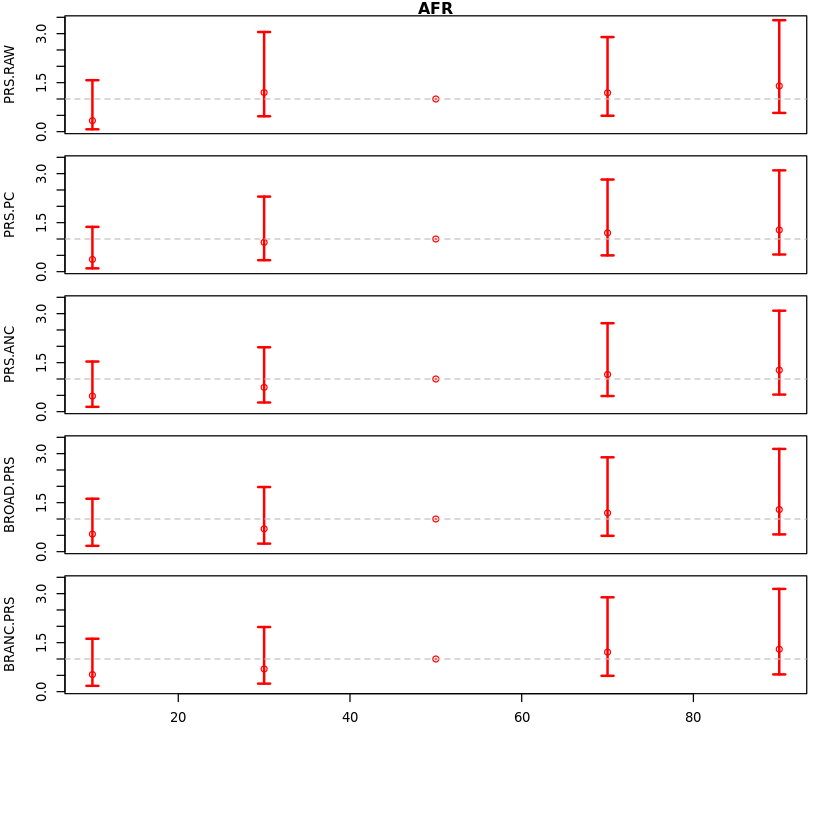

In [46]:
plot.quant.OR(df.raw =out.table.raw.afr ,df.pc = out.table.PC.afr, df.anc = out.table.ANC.afr,
              df.broad = out.table.BROAD.afr, df.branc=out.table.BRANC.afr,main.title="AFR",color="red")
out.table <- data.table(rbind(afr.prs.raw.count,afr.prs.pc.count,afr.prs.anc.count,afr.prs.broad.count,afr.prs.branc.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

Warning message in arrows(x0 = mid.quant, y0 = log(df.raw[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.pc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.anc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.broad[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.branc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”


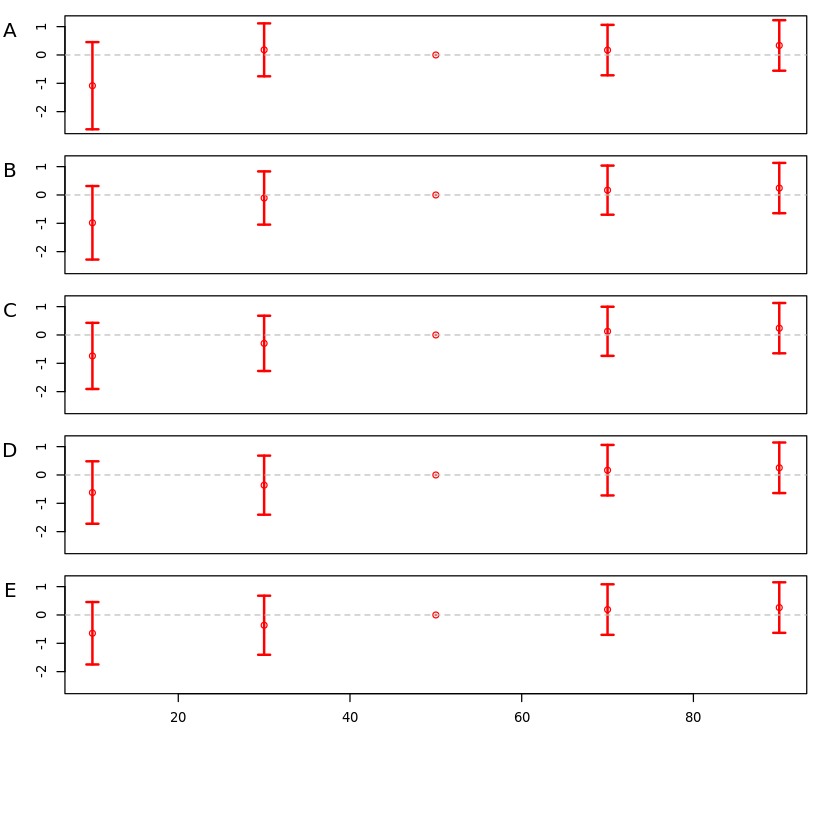

In [50]:
plot.quant.logOR(df.raw =out.table.raw.afr ,df.pc = out.table.PC.afr, df.anc = out.table.ANC.afr,
              df.broad = out.table.BROAD.afr, df.branc=out.table.BRANC.afr,main.title="AFR",color="red")

In [33]:
amr.prs.raw.count
amr.prs.pc.count
amr.prs.anc.count
amr.prs.broad.count
amr.prs.branc.count
rbind(amr.prs.raw.count,amr.prs.pc.count,amr.prs.anc.count,amr.prs.broad.count,amr.prs.branc.count)

[1] 5 6 1 4

[1] 7 4 3 2

[1] 8 3 3 2

[1] 7 4 3 2

[1] 8 3 3 2

amr.prs.raw.count,5,6,1,4
amr.prs.pc.count,7,4,3,2
amr.prs.anc.count,8,3,3,2
amr.prs.broad.count,7,4,3,2
amr.prs.branc.count,8,3,3,2


Warning message in arrows(x0 = mid.quant, y0 = df.raw[, 2], x1 = mid.quant, y1 = df.raw[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.pc[, 2], x1 = mid.quant, y1 = df.pc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.anc[, 2], x1 = mid.quant, y1 = df.anc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”


V1,V2,V3,V4
<int>,<int>,<int>,<int>
5,6,1,4
7,4,3,2
8,3,3,2
7,4,3,2
8,3,3,2


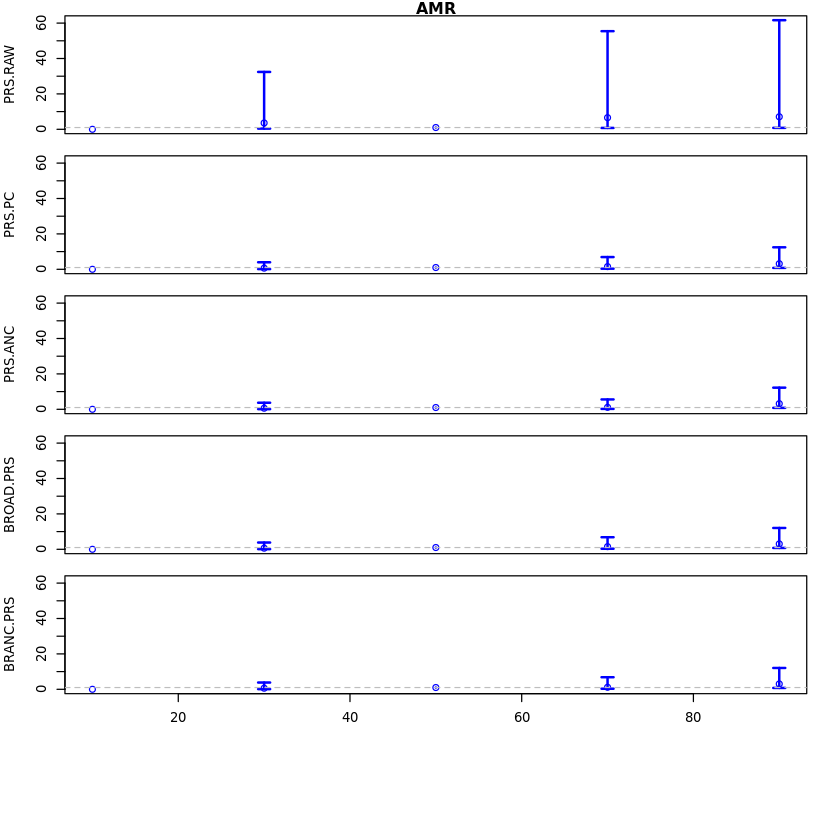

In [47]:
plot.quant.OR(df.raw =out.table.raw.amr ,df.pc = out.table.PC.amr, df.anc = out.table.ANC.amr,
              df.broad = out.table.BROAD.amr, df.branc=out.table.BRANC.amr,main.title="AMR",color="blue")
(out.table <- data.table(rbind(amr.prs.raw.count,amr.prs.pc.count,amr.prs.anc.count,amr.prs.broad.count,amr.prs.branc.count)))
#setnames(out.table,c("T5","T4","T3","T2","T1"))
#setcolorder(out.table,c("T1","T2","T3","T4","T5"))
#out.table

Warning message in arrows(x0 = mid.quant, y0 = log(df.raw[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.pc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.anc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.broad[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.branc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”


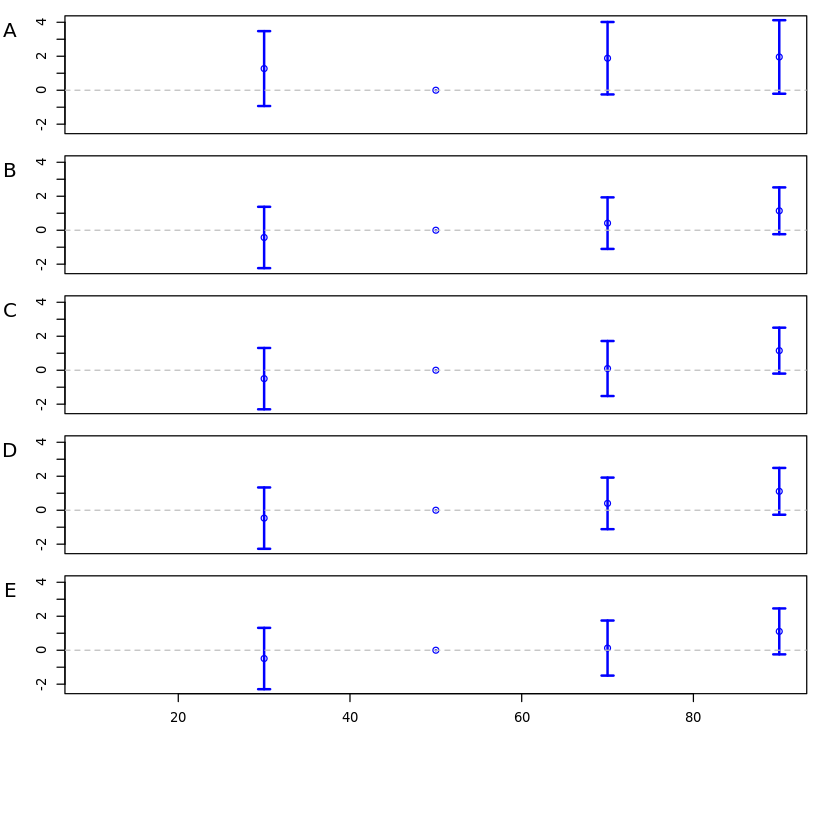

In [51]:
plot.quant.logOR(df.raw =out.table.raw.amr ,df.pc = out.table.PC.amr, df.anc = out.table.ANC.amr,
              df.broad = out.table.BROAD.amr, df.branc=out.table.BRANC.amr,main.title="AMR",color="blue")

In [47]:
df.raw =out.table.raw.amr 
df.pc = out.table.PC.amr
df.anc = out.table.ANC.amr
df.broad = out.table.BROAD.amr
df.branc=out.table.BRANC.amr
#plot.quant.logOR <- function(df.raw,df.pc,df.anc,df.broad,df.branc,main.title="",color="black"){
    mid.quant <- c(10,30,50,70,90)
    (min.check <- c(df.raw[,2], df.pc[,2], df.anc[,2], df.broad[,2],df.branc[,2]))
    (max.check <- c(df.raw[,3], df.pc[,3], df.anc[,3], df.broad[,3],df.branc[,3]))
min.check[is.finite(min.check) & min.check>0]
max.check[is.finite(max.check)]
    (min.y <- log(min(min.check[is.finite(min.check) & min.check>0])))
    (max.y <- log(max(max.check[is.finite(max.check) & max.check>0])))
#    par(mfrow=c(6,1), mar= c(0.4, 4.1,1, 2.1))
#    plot(mid.quant,log(df.raw[,1]),type="p", ylim=c(min.y, max.y), main=main.title, xlab="", ylab="PRS.RAW",xaxt='n',col=color)
#    arrows(x0=mid.quant,y0=log(df.raw[,2]),x1=mid.quant,y1=log(df.raw[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
#    abline(h=0, lty=2, col="gray")
#    plot(mid.quant,log(df.pc[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="PRS.PC",xaxt='n',col=color)
#    arrows(x0=mid.quant,y0=log(df.pc[,2]),x1=mid.quant,y1=log(df.pc[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
#    abline(h=0, lty=2, col="gray")
#    plot(mid.quant,log(df.anc[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="", ylab="PRS.ANC",xaxt='n',col=color)
#    arrows(x0=mid.quant,y0=log(df.anc[,2]),x1=mid.quant,y1=log(df.anc[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
#    abline(h=0, lty=2, col="gray")
#    plot(mid.quant,log(df.broad[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="BROAD.PRS",xaxt='n',col=color)
#    arrows(x0=mid.quant,y0=log(df.broad[,2]),x1=mid.quant,y1=log(df.broad[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
#    abline(h=0, lty=2, col="gray")
#    plot(mid.quant,log(df.branc[,1]),type="p", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="BRANC.PRS",col=color)
#    arrows(x0=mid.quant,y0=log(df.broad[,2]),x1=mid.quant,y1=log(df.broad[,3]),col=color,code=3,angle=90,length=1/20,lwd=2)
#    abline(h=0, lty=2, col="gray")

#}


[1] 0.0000000 0.3943077 1.0000000 0.7796341 0.8129927 0.0000000 0.1072214
 [8] 1.0000000 0.3323509 0.7907514 0.0000000 0.1001537 1.0000000 0.2185339
[15] 0.8192133 0.0000000 0.1032179 1.0000000 0.3278031 0.7667201 0.0000000
[22] 0.1007977 1.0000000 0.2245262 0.7837796

[1]       Inf 32.403174  1.000000 55.431557 61.633163       Inf  3.964254
 [8]  1.000000  6.912134 12.426433       Inf  3.704491  1.000000  5.580756
[15] 12.228701       Inf  3.817692  1.000000  6.824143 12.056625       Inf
[22]  3.729640  1.000000  5.738894 11.690650

[1] 0.3943077 1.0000000 0.7796341 0.8129927 0.1072214 1.0000000 0.3323509
 [8] 0.7907514 0.1001537 1.0000000 0.2185339 0.8192133 0.1032179 1.0000000
[15] 0.3278031 0.7667201 0.1007977 1.0000000 0.2245262 0.7837796

[1] 32.403174  1.000000 55.431557 61.633163  3.964254  1.000000  6.912134
 [8] 12.426433  3.704491  1.000000  5.580756 12.228701  3.817692  1.000000
[15]  6.824143 12.056625  3.729640  1.000000  5.738894 11.690650

[1] -2.30105

[1] 4.1212

Warning message in arrows(x0 = mid.quant, y0 = df.raw[, 2], x1 = mid.quant, y1 = df.raw[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.pc[, 2], x1 = mid.quant, y1 = df.pc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.anc[, 2], x1 = mid.quant, y1 = df.anc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”


T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
18,32,30,39,85
17,33,29,39,86
21,31,33,34,85
15,33,31,41,84
18,33,34,37,82


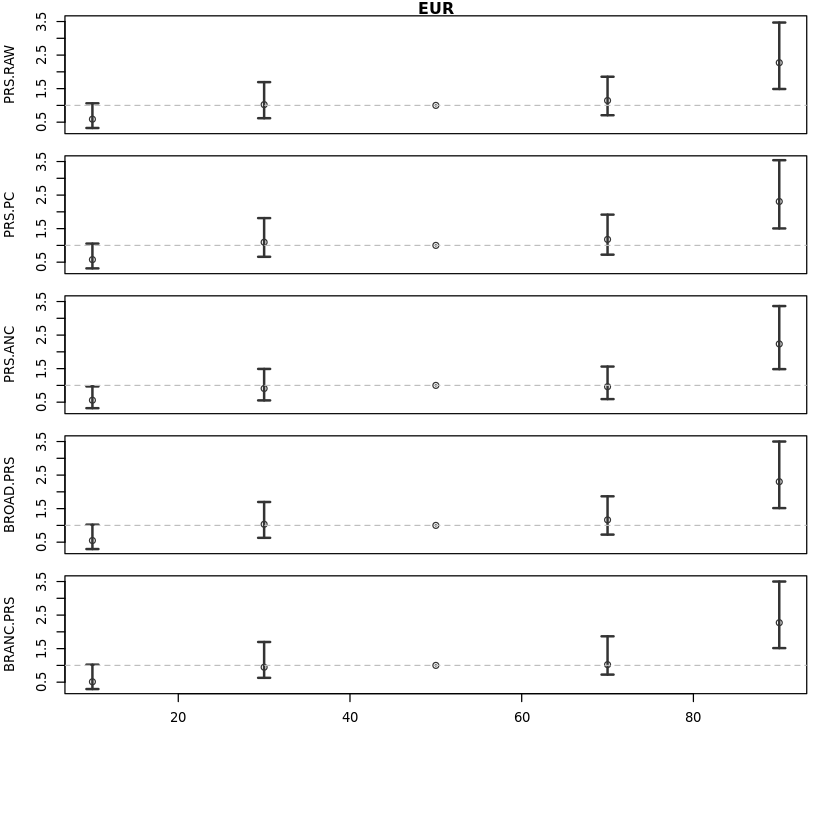

In [48]:
plot.quant.OR(df.raw =out.table.raw.eur ,df.pc = out.table.PC.eur, df.anc = out.table.ANC.eur,
              df.broad = out.table.BROAD.eur, df.branc=out.table.BRANC.eur,main.title="EUR",color="gray20")
out.table <- data.table(rbind(eur.prs.raw.count,eur.prs.pc.count,eur.prs.anc.count,eur.prs.broad.count,eur.prs.branc.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

Warning message in arrows(x0 = mid.quant, y0 = log(df.raw[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.pc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.anc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.broad[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.branc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”


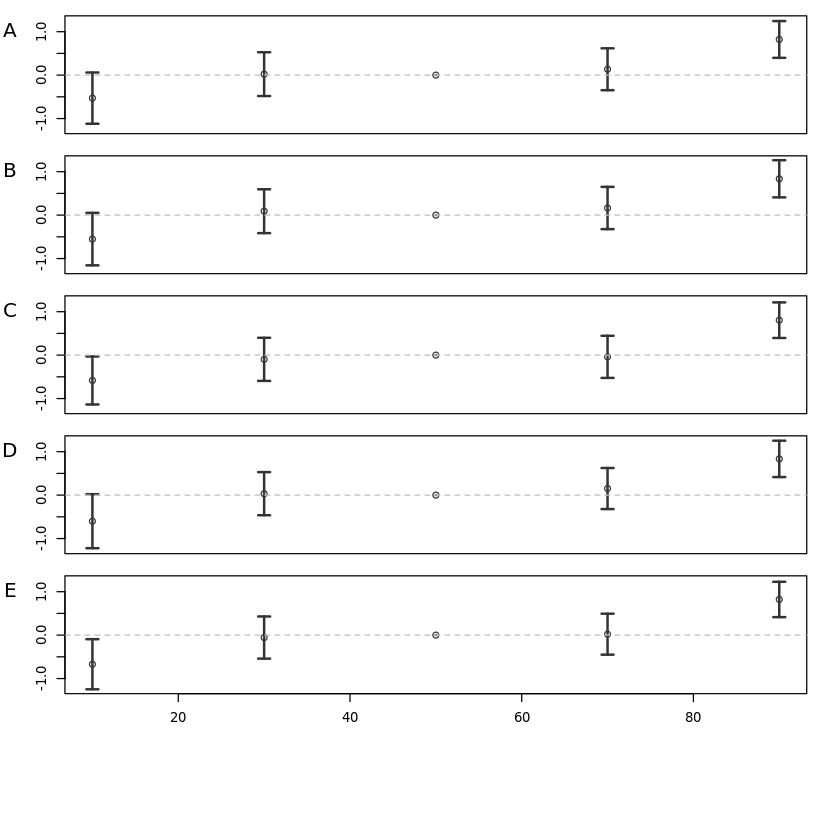

In [52]:
plot.quant.logOR(df.raw =out.table.raw.eur ,df.pc = out.table.PC.eur, df.anc = out.table.ANC.eur,
              df.broad = out.table.BROAD.eur, df.branc=out.table.BRANC.eur,main.title="EUR",color="gray20")

Warning message in arrows(x0 = mid.quant, y0 = df.raw[, 2], x1 = mid.quant, y1 = df.raw[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.pc[, 2], x1 = mid.quant, y1 = df.pc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.anc[, 2], x1 = mid.quant, y1 = df.anc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”


T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
10,3,4,3,3
8,4,5,3,3
4,4,3,5,7
8,3,6,3,3
3,5,3,6,6


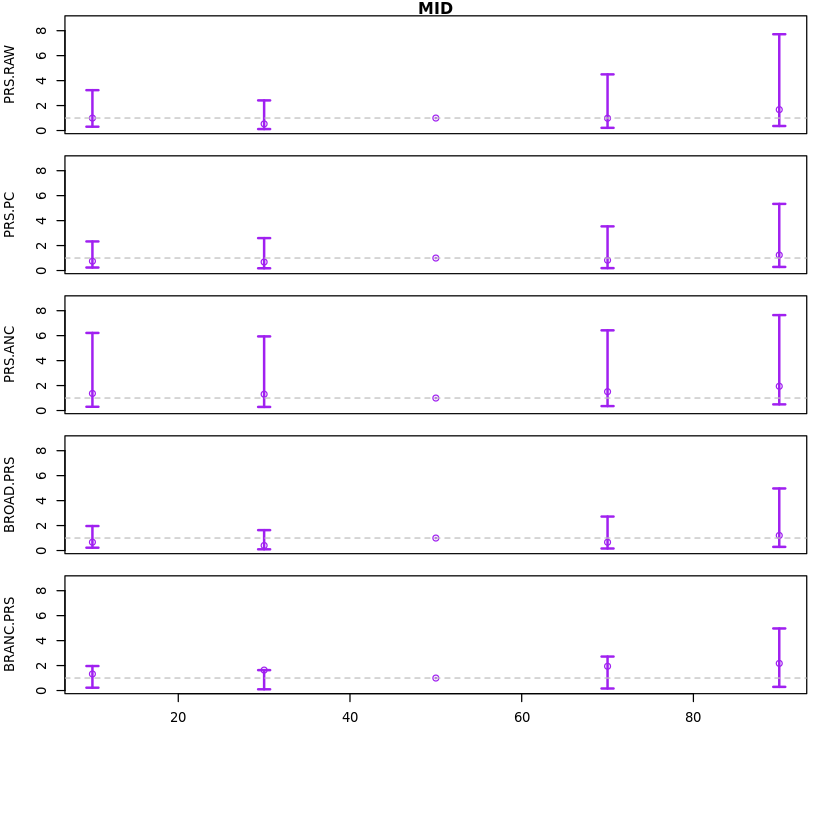

In [49]:
plot.quant.OR(df.raw =out.table.raw.mid ,df.pc = out.table.PC.mid, df.anc = out.table.ANC.mid,
              df.broad = out.table.BROAD.mid, df.branc=out.table.BRANC.mid,main.title="MID",color="purple")
out.table <- data.table(rbind(mid.prs.raw.count,mid.prs.pc.count,mid.prs.anc.count,mid.prs.broad.count,mid.prs.branc.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

Warning message in arrows(x0 = mid.quant, y0 = log(df.raw[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.pc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.anc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.broad[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.branc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”


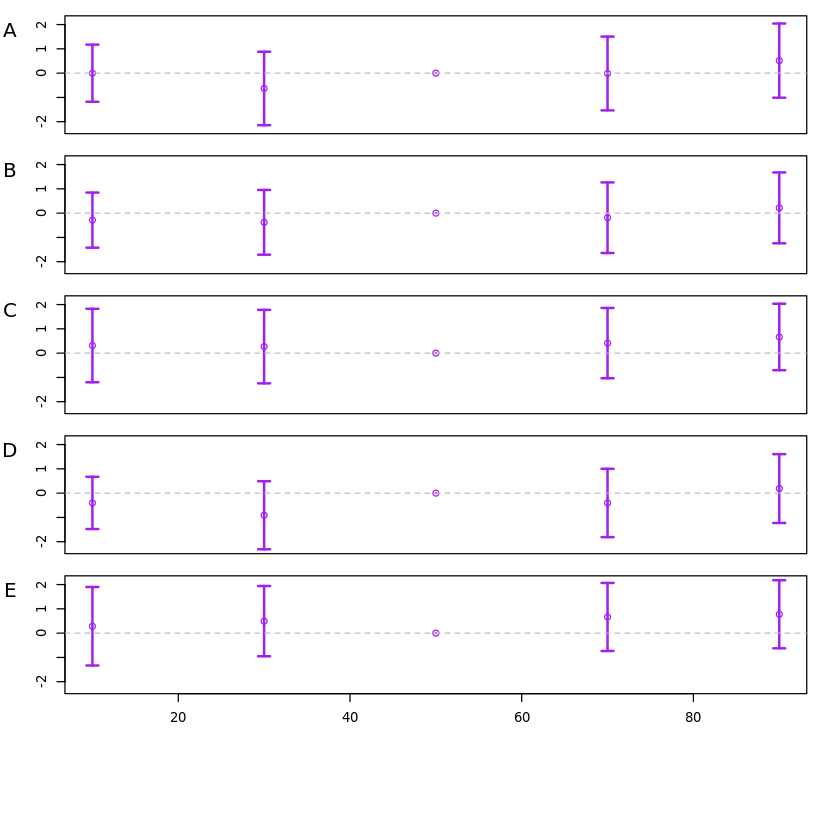

In [53]:
plot.quant.logOR(df.raw =out.table.raw.mid ,df.pc = out.table.PC.mid, df.anc = out.table.ANC.mid,
              df.broad = out.table.BROAD.mid, df.branc=out.table.BRANC.mid,main.title="MID",color="purple")

Warning message in arrows(x0 = mid.quant, y0 = df.raw[, 2], x1 = mid.quant, y1 = df.raw[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.pc[, 2], x1 = mid.quant, y1 = df.pc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.anc[, 2], x1 = mid.quant, y1 = df.anc[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = df.broad[, 2], x1 = mid.quant, y1 = df.broad[, :
“zero-length arrow is of indeterminate angle and so skipped”


T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
8,7,16,9,17
8,7,15,12,15
8,5,10,14,20
8,6,17,10,16
8,5,11,16,17


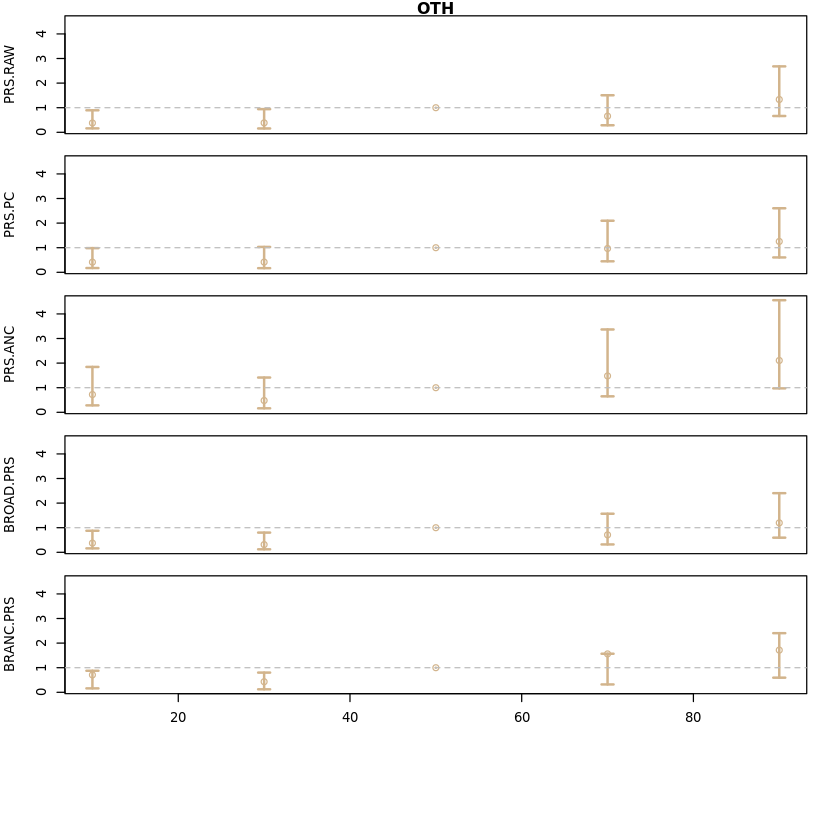

In [50]:
plot.quant.OR(df.raw =out.table.raw.oth ,df.pc = out.table.PC.oth, df.anc = out.table.ANC.oth,
              df.broad = out.table.BROAD.oth, df.branc=out.table.BRANC.oth,main.title="OTH",color="tan")
out.table <- data.table(rbind(oth.prs.raw.count,oth.prs.pc.count,oth.prs.anc.count,oth.prs.broad.count,oth.prs.branc.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

Warning message in arrows(x0 = mid.quant, y0 = log(df.raw[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.pc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.anc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.broad[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x0 = mid.quant, y0 = log(df.branc[, 2]), x1 = mid.quant, :
“zero-length arrow is of indeterminate angle and so skipped”


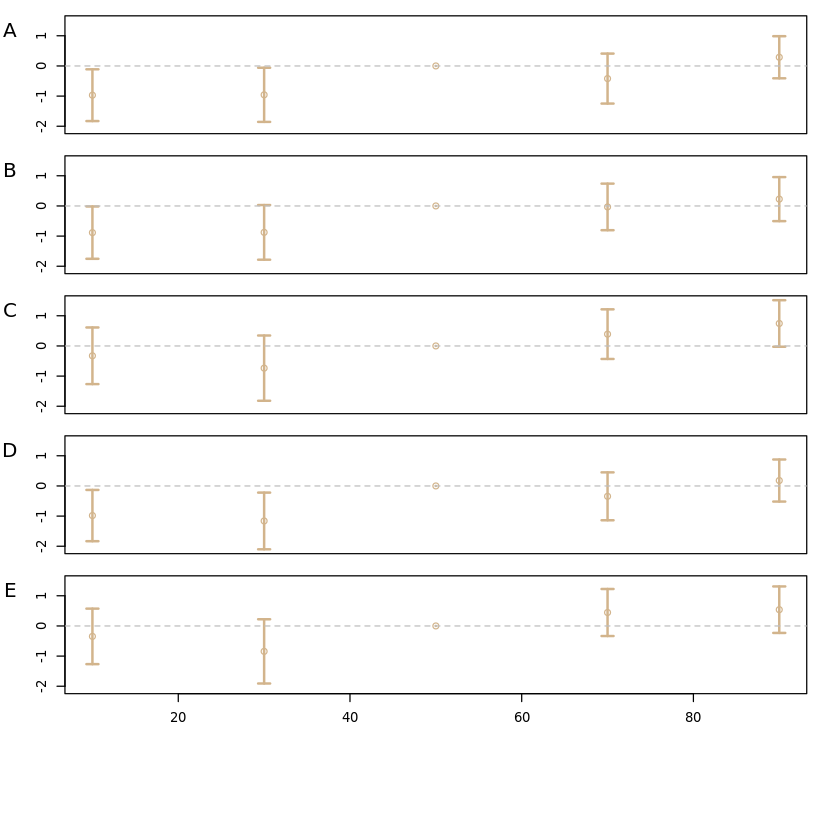

In [54]:
plot.quant.logOR(df.raw =out.table.raw.oth ,df.pc = out.table.PC.oth, df.anc = out.table.ANC.oth,
              df.broad = out.table.BROAD.oth, df.branc=out.table.BRANC.oth,main.title="OTH",color="tan")

T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
2,6,4,11,10
3,5,5,10,10
2,6,4,11,10
3,5,4,9,12


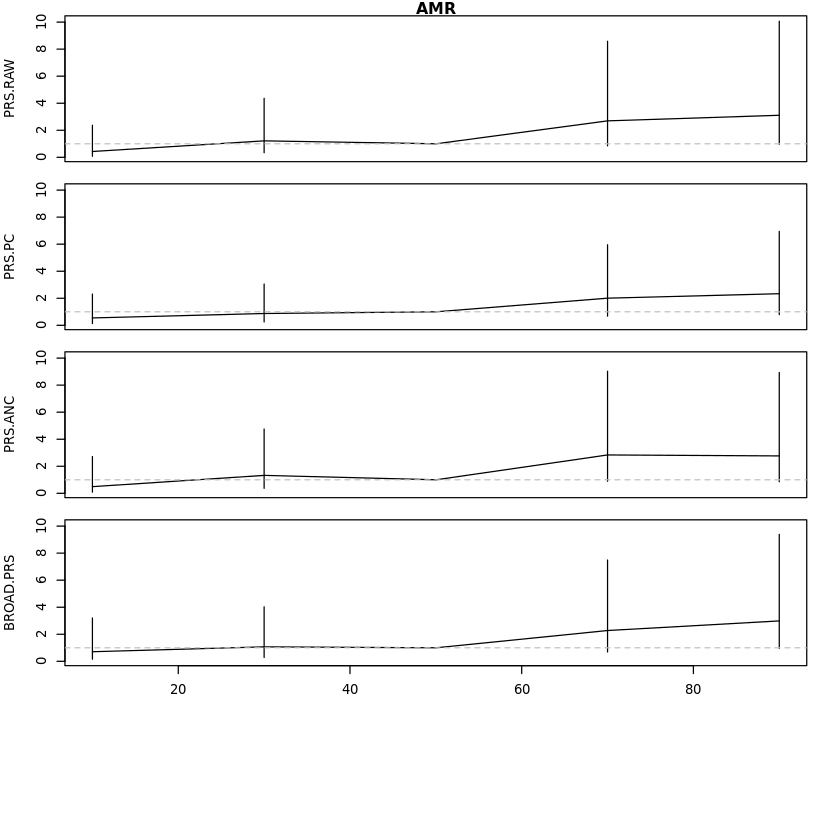

In [118]:
plot.quant.OR(df.raw =out.table.raw.amr ,df.pc = out.table.PC.amr, df.anc = out.table.ANC.amr,
              df.broad = out.table.BROAD.amr, main.title="AMR")
out.table <- data.table(rbind(amr.prs.raw.count,amr.prs.pc.count,amr.prs.anc.count,amr.prs.broad.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
28,33,39,42,83
24,32,37,47,85
26,33,36,46,84
18,30,29,46,102


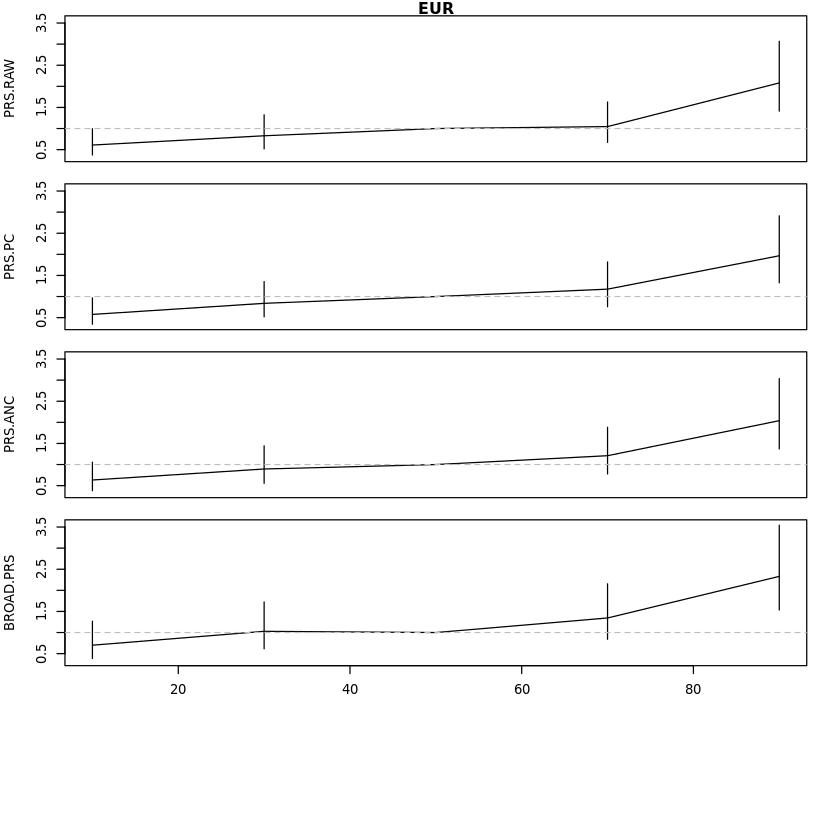

In [119]:
plot.quant.OR(df.raw =out.table.raw.eur ,df.pc = out.table.PC.eur, df.anc = out.table.ANC.eur,
              df.broad = out.table.BROAD.eur, main.title="EUR")
out.table <- data.table(rbind(eur.prs.raw.count,eur.prs.pc.count,eur.prs.anc.count,eur.prs.broad.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

T1,T2,T3,T4,T5
<int>,<int>,<int>,<int>,<int>
6,7,9,5,14
5,5,9,5,17
5,5,9,6,16
5,6,8,5,17


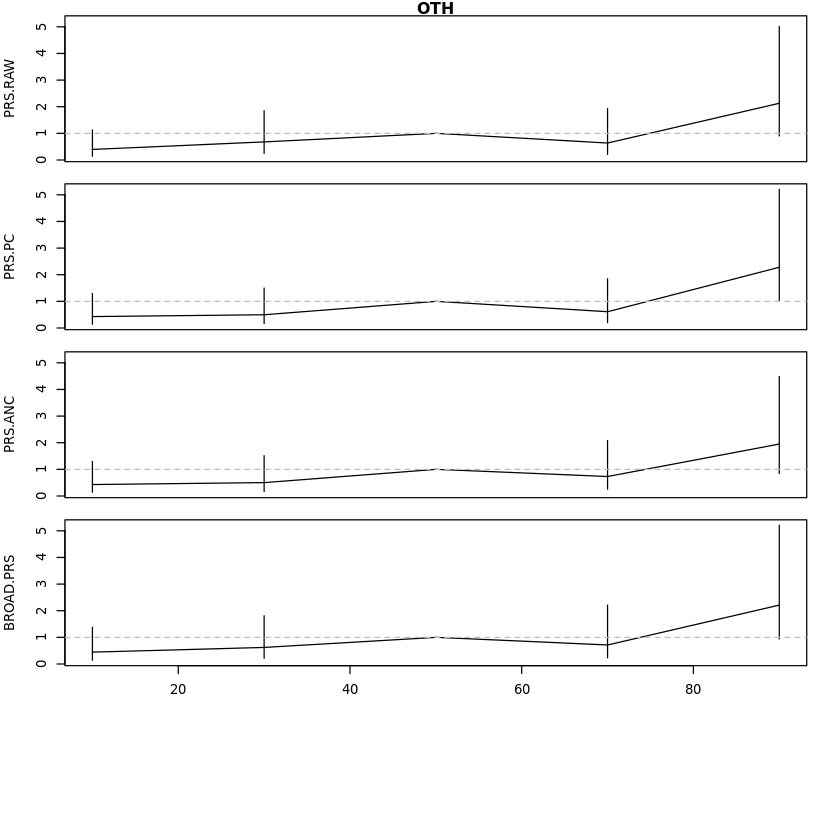

In [120]:
plot.quant.OR(df.raw =out.table.raw.oth ,df.pc = out.table.PC.oth, df.anc = out.table.ANC.oth,
              df.broad = out.table.BROAD.oth, main.title="OTH")
out.table <- data.table(rbind(oth.prs.raw.count,oth.prs.pc.count,oth.prs.anc.count,oth.prs.broad.count))
setnames(out.table,c("T5","T4","T3","T2","T1"))
setcolorder(out.table,c("T1","T2","T3","T4","T5"))
out.table

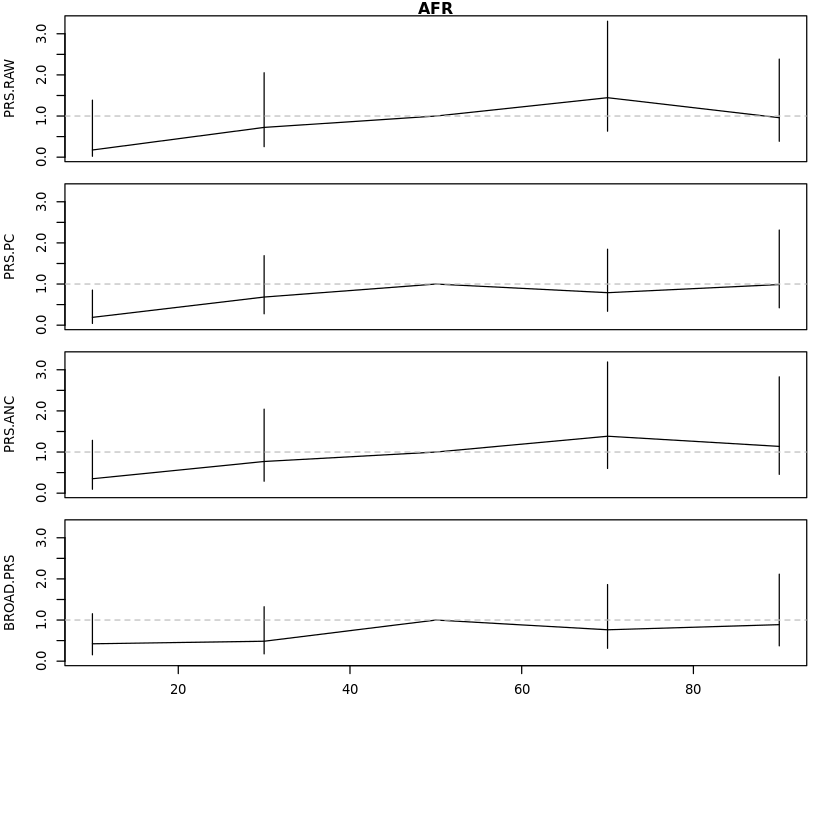

In [95]:

min.y <- min(out.table.raw.afr[,2], out.table.PC.afr[,2], out.table.ANC.afr[,2], out.table.BROAD.afr[,2])
max.y <- max(out.table.raw.afr[,3], out.table.PC.afr[,3], out.table.ANC.afr[,3], out.table.BROAD.afr[,3])
par(mfrow=c(5,1), mar= c(0.4, 4.1,1, 2.1))
plot(mid.quant,out.table.raw.afr[,1],type="l", ylim=c(min.y, max.y), main="AFR", xlab="", ylab="PRS.RAW",xaxt='n')
segments(x0=mid.quant,y0=out.table.raw.afr[,2],x1=mid.quant,y1=out.table.raw.afr[,3])
abline(h=1, lty=2, col="gray")
plot(mid.quant,out.table.PC.afr[,1],type="l", ylim=c(min.y, max.y), main="", xlab="", ylab="PRS.PC",xaxt='n')
segments(x0=mid.quant,y0=out.table.PC.afr[,2],x1=mid.quant,y1=out.table.PC.afr[,3])
abline(h=1, lty=2, col="gray")
plot(mid.quant,out.table.ANC.afr[,1],type="l", ylim=c(min.y, max.y), main="", xlab="", ylab="PRS.ANC",xaxt='n')
segments(x0=mid.quant,y0=out.table.ANC.afr[,2],x1=mid.quant,y1=out.table.ANC.afr[,3])
abline(h=1, lty=2, col="gray")
plot(mid.quant,out.table.BROAD.afr[,1],type="l", ylim=c(min.y, max.y), main="", xlab="Quantiles", ylab="BROAD.PRS")
segments(x0=mid.quant,y0=out.table.BROAD.afr[,2],x1=mid.quant,y1=out.table.BROAD.afr[,3])
abline(h=1, lty=2, col="gray")


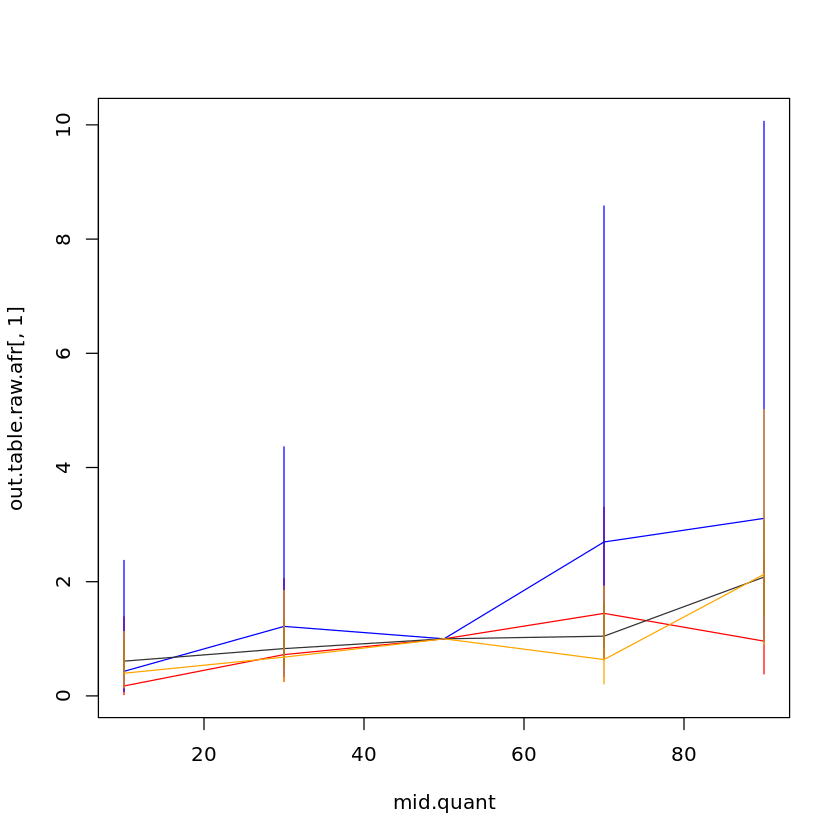

In [66]:
# I think it is best to do plots for each ancestry separately, across the four types
min.y <- min(out.table.raw.afr[,2], out.table.raw.amr[,2], out.table.raw.eur[,2], out.table.raw.oth[,2])
max.y <- max(out.table.raw.afr[,3], out.table.raw.amr[,3], out.table.raw.eur[,3], out.table.raw.oth[,3])

plot(mid.quant,out.table.raw.afr[,1],type="l", col="red", ylim=c(min.y, max.y))
segments(x0=mid.quant,y0=out.table.raw.afr[,2],x1=mid.quant,y1=out.table.raw.afr[,3], col="red")
lines(mid.quant,out.table.raw.amr[,1],type="l", col="blue", ylim=c(min.y, max.y))
segments(x0=mid.quant,y0=out.table.raw.amr[,2],x1=mid.quant,y1=out.table.raw.amr[,3], col="blue")
lines(mid.quant,out.table.raw.eur[,1],type="l", col="gray20", ylim=c(min.y, max.y))
segments(x0=mid.quant,y0=out.table.raw.eur[,2],x1=mid.quant,y1=out.table.raw.eur[,3], col="gray20")
lines(mid.quant,out.table.raw.oth[,1],type="l", col="orange", ylim=c(min.y, max.y))
segments(x0=mid.quant,y0=out.table.raw.oth[,2],x1=mid.quant,y1=out.table.raw.oth[,3], col="orange")



OR1,CI1.low,CI1.upp,OR2,CI2.low,CI2.upp
0.5092648,0.3384740,0.7662353,0.5085336,0.3375056,0.7662287
0.7831405,0.5408143,1.1340474,0.7936932,0.5472768,1.1510609
1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
1.1344567,0.8097026,1.5894628,1.1405382,0.8126521,1.6007187
1.8696130,1.3724826,2.5468103,1.8880366,1.3828840,2.5777161


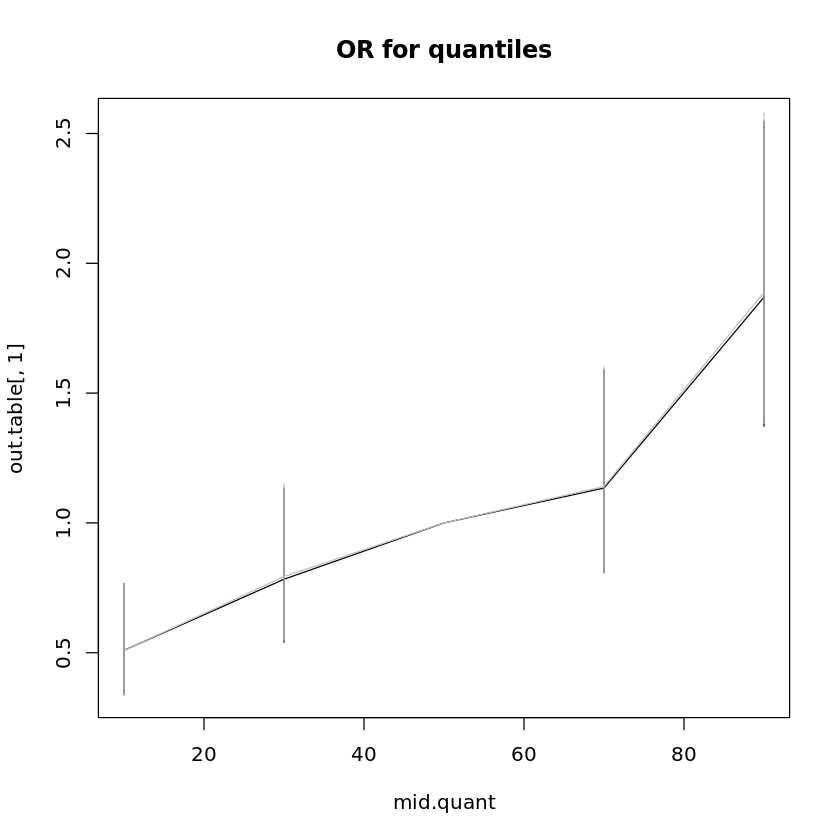

In [61]:
# check that my function works
get.OR.quants <- function(subset.dt)
    {
    glm1 <- summary(glm(CRC.status ~ T1 + T2 + T4 + T5, data=subset.dt,family="binomial"))
    glm2 <- summary(glm(CRC.status ~ T1 + T2 + T4 + T5 + sex + censored.age, data=subset.dt,family="binomial"))
    beta1 <-  c(glm1$coef["T1",1],glm1$coef["T2",1],0,glm1$coef["T4",1],glm1$coef["T5",1])
    beta2 <- c(glm2$coef["T1",1],glm2$coef["T2",1],0,glm2$coef["T4",1],glm2$coef["T5",1])
    OR1 <- exp(beta1)
    OR2 <- exp(beta2)
    SD1 <- c(glm1$coef["T1",2],glm1$coef["T2",2],0, glm1$coef["T4",2],glm1$coef["T5",2]) 
    SD2 <- c(glm2$coef["T1",2],glm2$coef["T2",2],0, glm2$coef["T4",2],glm2$coef["T5",2])
    CI1.low <- (exp(beta1 + (SD1* qnorm(0.025)))) 
    CI1.upp <- (exp(beta1 + (SD1* qnorm(0.975))))
    CI2.low <- (exp(beta2 + (SD2* qnorm(0.025)))) 
    CI2.upp <- (exp(beta2 + (SD2* qnorm(0.975))))
    
    cbind(OR1,CI1.low,CI1.upp, OR2,CI2.low,CI2.upp)
    
}

subset.dt <- merge.dt[][!(merge.dt$CSET1==1 & merge.dt$CSET3==0)]
subset.dt[,T1:=T1.PRS]
subset.dt[,T2:=T2.PRS]
subset.dt[,T3:=T3.PRS]
subset.dt[,T4:=T4.PRS]
subset.dt[,T5:=T5.PRS]

(out.table <- (get.OR.quants(subset.dt)))
mid.quant <- c(10,30,50,70,90)


plot(mid.quant,out.table[,1],type="l", ylim=c(min(out.table[,2]),max(out.table[,3])), main="OR for quantiles")
segments(x0=mid.quant,y0=out.table[,2],x1=mid.quant,y1=out.table[,3], col="black")

lines(mid.quant,out.table[,4],col="gray", ylim=c(min(out.table[,5]),max(out.table[,6])))
segments(x0=mid.quant,y0=out.table[,5],x1=mid.quant,y1=out.table[,6], col="gray")

In [ ]:
(glm1 <- summary(glm(CRC.status ~ T1 + T2 + T4 + T5, data=subset.dt,family="binomial")))
(beta1 <-  c(glm1$coef["T1",1],glm1$coef["T2",1],glm1$coef["T4",1],glm1$coef["T5",1]))
(OR1 <- exp(beta1))
(SD1 <- c(glm1$coef["T1",2],glm1$coef["T2",2],glm1$coef["T4",2],glm1$coef["T5",2]))
qnorm(c(0.025,0.975))
SD1* rep(qnorm(c(0.025,0.975)),4)
#(CI1 <- (exp(beta1 + (SD1* rep(qnorm(c(0.025,0.975)),4)))))
#paste(CI1[1],CI1[2],sep=",")
(CI1.low <- (exp(beta1 + (SD1* qnorm(0.025)))) ) 
(CI1.upp <- (exp(beta1 + (SD1* qnorm(0.975)))) )
paste(CI1.low,CI1.upp,sep=",")
cbind(OR1,paste(CI1.low,CI1.upp,sep=","))

# Compare actual upper percentiles to expected percentiles within ancestries using all participants

In [17]:
cutoffs <- c(0.90, 0.925, 0.95)
qnorm(cutoffs)

[1] 1.281552 1.439531 1.644854

In [23]:
keep.ancestry <- "AFR"
(counts.AFR.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.AFR.norm.PRS <- round(100*counts.AFR.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.AFR.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.AFR.norm.PRS.ADJ.PC <- round(100*counts.AFR.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.AFR.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.AFR.norm.PRS.ADJ.ANC <- round(100*counts.AFR.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.AFR.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.AFR.PRS.BR.AOU1 <- round(100*counts.AFR.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.AFR.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.AFR.PRS.BR.ANC.AOU1 <- round(100*counts.AFR.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 2064 1470  915

[1] 9.22 6.57 4.09

[1] 1692 1212  722

[1] 7.56 5.41 3.23

[1] 1675 1214  709

[1] 7.48 5.42 3.17

[1] 2203 1603 1061

[1] 9.84 7.16 4.74

[1] 2119 1553 1022

[1] 9.47 6.94 4.57

In [26]:
# possible to get the variance using the binomial test?
keep.ancestry="AFR"
(btest <- binom.test(x=2064,n=length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]), p=0.1))
names(btest)
btest$estimate
btest$conf.int



	Exact binomial test

data:  2064 and length(merge.dt$norm.PRS[merge.dt$my.ancestry == keep.ancestry])
number of successes = 2064, number of trials = 22385, p-value =
8.796e-05
alternative hypothesis: true probability of success is not equal to 0.1
95 percent confidence interval:
 0.08844538 0.09607009
sample estimates:
probability of success 
             0.0922046 


[1] "statistic"   "parameter"   "p.value"     "conf.int"    "estimate"   
[6] "null.value"  "alternative" "method"      "data.name"

probability of success 
             0.0922046

[1] 0.08844538 0.09607009
attr(,"conf.level")
[1] 0.95

In [31]:
#how do I create a function to incorporate the binom.test and make it easy?
total <- length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry])
prop <- 0.1
count <- length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])])
round(binom.test(x=count,n=total,p=prop)$estimate,2)
round(binom.test(x=count,n=total,p=prop)$conf.int,2)


probability of success 
                  0.09

[1] 0.09 0.10
attr(,"conf.level")
[1] 0.95

In [17]:
get.observed.freq <- function(subset.dt, cutoff)
    {
    #cutoff <- 0.9
    (total <- length(subset.dt$my.prs))
    (count <- length(subset.dt$my.prs[subset.dt$my.prs > qnorm(cutoff)]))
    (prop <- 1 - cutoff)
    obs.freq <- round(100*binom.test(x=count,n=total,p=prop)$estimate,2)
    ci.freq <- round(100*binom.test(x=count,n=total,p=prop)$conf.int,2)
    c(obs.freq, ci.freq)
    }

In [24]:
keep.ancestry="AFR"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.AFR.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.AFR.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.AFR.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.AFR.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.AFR.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(AFR.actuals <- cbind(actual.AFR.norm[,1], actual.AFR.norm.ADJ.PC[,1],actual.AFR.BR.AOU1[,1], 
                     actual.AFR.norm.ADJ.ANC[,1], 
                     actual.AFR.BR.ANC.AOU1[,1]))
(AFR.lower <- cbind(actual.AFR.norm[,2], actual.AFR.norm.ADJ.PC[,2],actual.AFR.BR.AOU1[,2], 
                     actual.AFR.norm.ADJ.ANC[,2], 
                     actual.AFR.BR.ANC.AOU1[,2]))
(AFR.upper <- cbind(actual.AFR.norm[,3], actual.AFR.norm.ADJ.PC[,3],actual.AFR.BR.AOU1[,3], 
                     actual.AFR.norm.ADJ.ANC[,3], 
                     actual.AFR.BR.ANC.AOU1[,3]))



[1] 22385

9.22,8.84,9.61
6.57,6.25,6.90
4.09,3.83,4.36


[1] 22385

7.56,7.22,7.91
5.41,5.12,5.72
3.23,3.00,3.47


[1] 22385

7.48,7.14,7.84
5.42,5.13,5.73
3.17,2.94,3.41


[1] 22385

9.84,9.45,10.24
7.16,6.83,7.51
4.74,4.47,5.03


[1] 22385

9.47,9.09,9.86
6.94,6.61,7.28
4.57,4.30,4.85


9.22,7.56,9.84,7.48,9.47
6.57,5.41,7.16,5.42,6.94
4.09,3.23,4.74,3.17,4.57


8.84,7.22,9.45,7.14,9.09
6.25,5.12,6.83,5.13,6.61
3.83,3.00,4.47,2.94,4.30


9.61,7.91,10.24,7.84,9.86
6.90,5.72,7.51,5.73,7.28
4.36,3.47,5.03,3.41,4.85


In [25]:
keep.ancestry="AMR"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.AMR.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.AMR.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.AMR.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.AMR.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.AMR.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(AMR.actuals <- cbind(actual.AMR.norm[,1], actual.AMR.norm.ADJ.PC[,1],actual.AMR.BR.AOU1[,1], 
                     actual.AMR.norm.ADJ.ANC[,1], 
                     actual.AMR.BR.ANC.AOU1[,1]))
(AMR.lower <- cbind(actual.AMR.norm[,2], actual.AMR.norm.ADJ.PC[,2],actual.AMR.BR.AOU1[,2], 
                     actual.AMR.norm.ADJ.ANC[,2], 
                     actual.AMR.BR.ANC.AOU1[,2]))
(AMR.upper <- cbind(actual.AMR.norm[,3], actual.AMR.norm.ADJ.PC[,3],actual.AMR.BR.AOU1[,3], 
                     actual.AMR.norm.ADJ.ANC[,3], 
                     actual.AMR.BR.ANC.AOU1[,3]))



[1] 9382

7.57,7.04,8.12
5.61,5.15,6.09
3.70,3.33,4.10


[1] 9382

9.05,8.48,9.65
6.74,6.24,7.26
4.52,4.11,4.96


[1] 9382

9.61,9.02,10.23
7.24,6.72,7.78
4.97,4.54,5.43


[1] 9382

9.21,8.63,9.81
6.89,6.38,7.42
4.69,4.27,5.14


[1] 9382

10.03,9.43,10.66
7.66,7.13,8.22
5.35,4.90,5.83


7.57,9.05,9.21,9.61,10.03
5.61,6.74,6.89,7.24,7.66
3.70,4.52,4.69,4.97,5.35


7.04,8.48,8.63,9.02,9.43
5.15,6.24,6.38,6.72,7.13
3.33,4.11,4.27,4.54,4.90


8.12,9.65,9.81,10.23,10.66
6.09,7.26,7.42,7.78,8.22
4.10,4.96,5.14,5.43,5.83


In [26]:
keep.ancestry="EAS"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.EAS.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.EAS.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.EAS.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.EAS.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.EAS.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(EAS.actuals <- cbind(actual.EAS.norm[,1], actual.EAS.norm.ADJ.PC[,1],actual.EAS.BR.AOU1[,1], 
                     actual.EAS.norm.ADJ.ANC[,1], 
                     actual.EAS.BR.ANC.AOU1[,1]))
(EAS.lower <- cbind(actual.EAS.norm[,2], actual.EAS.norm.ADJ.PC[,2],actual.EAS.BR.AOU1[,2], 
                     actual.EAS.norm.ADJ.ANC[,2], 
                     actual.EAS.BR.ANC.AOU1[,2]))
(EAS.upper <- cbind(actual.EAS.norm[,3], actual.EAS.norm.ADJ.PC[,3],actual.EAS.BR.AOU1[,3], 
                     actual.EAS.norm.ADJ.ANC[,3], 
                     actual.EAS.BR.ANC.AOU1[,3]))



[1] 2069

11.74,10.39,13.21
8.70,7.52,10.00
5.51,4.57,6.58


[1] 2069

10.39,9.11,11.79
7.10,6.04,8.30
4.69,3.82,5.69


[1] 2069

10.78,9.47,12.19
7.68,6.57,8.92
5.12,4.21,6.16


[1] 2069

8.46,7.29,9.74
5.90,4.92,7.00
3.67,2.90,4.58


[1] 2069

8.22,7.07,9.48
5.80,4.83,6.90
3.62,2.86,4.52


11.74,10.39,8.46,10.78,8.22
8.70,7.10,5.90,7.68,5.80
5.51,4.69,3.67,5.12,3.62


10.39,9.11,7.29,9.47,7.07
7.52,6.04,4.92,6.57,4.83
4.57,3.82,2.90,4.21,2.86


13.21,11.79,9.74,12.19,9.48
10.00,8.30,7.00,8.92,6.90
6.58,5.69,4.58,6.16,4.52


In [27]:
keep.ancestry="EUR"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.EUR.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.EUR.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.EUR.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.EUR.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.EUR.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(EUR.actuals <- cbind(actual.EUR.norm[,1], actual.EUR.norm.ADJ.PC[,1],actual.EUR.BR.AOU1[,1], 
                     actual.EUR.norm.ADJ.ANC[,1], 
                     actual.EUR.BR.ANC.AOU1[,1]))
(EUR.lower <- cbind(actual.EUR.norm[,2], actual.EUR.norm.ADJ.PC[,2],actual.EUR.BR.AOU1[,2], 
                     actual.EUR.norm.ADJ.ANC[,2], 
                     actual.EUR.BR.ANC.AOU1[,2]))
(EUR.upper <- cbind(actual.EUR.norm[,3], actual.EUR.norm.ADJ.PC[,3],actual.EUR.BR.AOU1[,3], 
                     actual.EUR.norm.ADJ.ANC[,3], 
                     actual.EUR.BR.ANC.AOU1[,3]))



[1] 44099

11.94,11.64,12.25
9.14,8.88,9.42
6.39,6.16,6.62


[1] 44099

12.32,12.02,12.63
9.42,9.15,9.70
6.62,6.39,6.86


[1] 44099

10.99,10.70,11.29
8.38,8.13,8.65
5.82,5.60,6.04


[1] 44099

11.20,10.91,11.50
8.39,8.14,8.66
5.71,5.49,5.93


[1] 44099

10.15,9.87,10.44
7.69,7.45,7.95
5.22,5.01,5.43


11.94,12.32,11.20,10.99,10.15
9.14,9.42,8.39,8.38,7.69
6.39,6.62,5.71,5.82,5.22


11.64,12.02,10.91,10.70,9.87
8.88,9.15,8.14,8.13,7.45
6.16,6.39,5.49,5.60,5.01


12.25,12.63,11.50,11.29,10.44
9.42,9.70,8.66,8.65,7.95
6.62,6.86,5.93,6.04,5.43


In [28]:
keep.ancestry="MID"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.MID.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.MID.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.MID.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.MID.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.MID.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(MID.actuals <- cbind(actual.MID.norm[,1], actual.MID.norm.ADJ.PC[,1],actual.MID.BR.AOU1[,1], 
                     actual.MID.norm.ADJ.ANC[,1], 
                     actual.MID.BR.ANC.AOU1[,1]))
(MID.lower <- cbind(actual.MID.norm[,2], actual.MID.norm.ADJ.PC[,2],actual.MID.BR.AOU1[,2], 
                     actual.MID.norm.ADJ.ANC[,2], 
                     actual.MID.BR.ANC.AOU1[,2]))
(MID.upper <- cbind(actual.MID.norm[,3], actual.MID.norm.ADJ.PC[,3],actual.MID.BR.AOU1[,3], 
                     actual.MID.norm.ADJ.ANC[,3], 
                     actual.MID.BR.ANC.AOU1[,3]))



[1] 4056

3.33,2.80,3.93
2.39,1.94,2.91
1.48,1.13,1.90


[1] 4056

3.85,3.28,4.48
3.01,2.50,3.58
1.85,1.46,2.31


[1] 4056

12.01,11.02,13.05
9.66,8.77,10.62
6.76,6.00,7.57


[1] 4056

3.33,2.80,3.93
2.37,1.92,2.88
1.43,1.09,1.84


[1] 4056

9.57,8.68,10.51
6.98,6.21,7.81
4.34,3.73,5.01


3.33,3.85,3.33,12.01,9.57
2.39,3.01,2.37,9.66,6.98
1.48,1.85,1.43,6.76,4.34


2.80,3.28,2.80,11.02,8.68
1.94,2.50,1.92,8.77,6.21
1.13,1.46,1.09,6.00,3.73


3.93,4.48,3.93,13.05,10.51
2.91,3.58,2.88,10.62,7.81
1.90,2.31,1.84,7.57,5.01


In [29]:
keep.ancestry="OTH"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.OTH.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.OTH.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.OTH.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.OTH.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.OTH.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(OTH.actuals <- cbind(actual.OTH.norm[,1], actual.OTH.norm.ADJ.PC[,1],actual.OTH.BR.AOU1[,1], 
                     actual.OTH.norm.ADJ.ANC[,1], 
                     actual.OTH.BR.ANC.AOU1[,1]))
(OTH.lower <- cbind(actual.OTH.norm[,2], actual.OTH.norm.ADJ.PC[,2],actual.OTH.BR.AOU1[,2], 
                     actual.OTH.norm.ADJ.ANC[,2], 
                     actual.OTH.BR.ANC.AOU1[,2]))
(OTH.upper <- cbind(actual.OTH.norm[,3], actual.OTH.norm.ADJ.PC[,3],actual.OTH.BR.AOU1[,3], 
                     actual.OTH.norm.ADJ.ANC[,3], 
                     actual.OTH.BR.ANC.AOU1[,3]))



[1] 15505

7.87,7.46,8.31
5.68,5.32,6.06
3.73,3.44,4.04


[1] 15505

7.98,7.56,8.42
5.89,5.53,6.28
3.82,3.53,4.14


[1] 15505

9.76,9.30,10.24
7.31,6.91,7.73
5.04,4.70,5.39


[1] 15505

7.82,7.41,8.26
5.72,5.36,6.10
3.64,3.35,3.94


[1] 15505

9.19,8.74,9.66
6.87,6.48,7.28
4.71,4.38,5.05


7.87,7.98,7.82,9.76,9.19
5.68,5.89,5.72,7.31,6.87
3.73,3.82,3.64,5.04,4.71


7.46,7.56,7.41,9.30,8.74
5.32,5.53,5.36,6.91,6.48
3.44,3.53,3.35,4.70,4.38


8.31,8.42,8.26,10.24,9.66
6.06,6.28,6.10,7.73,7.28
4.04,4.14,3.94,5.39,5.05


In [30]:
keep.ancestry="SAS"
subset.dt <- merge.dt[merge.dt$my.ancestry==keep.ancestry]


subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.SAS.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.SAS.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.SAS.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.SAS.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.SAS.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(SAS.actuals <- cbind(actual.SAS.norm[,1], actual.SAS.norm.ADJ.PC[,1],actual.SAS.BR.AOU1[,1], 
                     actual.SAS.norm.ADJ.ANC[,1], 
                     actual.SAS.BR.ANC.AOU1[,1]))
(SAS.lower <- cbind(actual.SAS.norm[,2], actual.SAS.norm.ADJ.PC[,2],actual.SAS.BR.AOU1[,2], 
                     actual.SAS.norm.ADJ.ANC[,2], 
                     actual.SAS.BR.ANC.AOU1[,2]))
(SAS.upper <- cbind(actual.SAS.norm[,3], actual.SAS.norm.ADJ.PC[,3],actual.SAS.BR.AOU1[,3], 
                     actual.SAS.norm.ADJ.ANC[,3], 
                     actual.SAS.BR.ANC.AOU1[,3]))



[1] 760

7.37,5.61,9.46
5.39,3.90,7.25
4.21,2.90,5.89


[1] 760

18.82,16.10,21.78
14.87,12.41,17.60
10.00,7.96,12.36


[1] 760

10.00,7.96,12.36
8.03,6.19,10.19
6.18,4.58,8.14


[1] 760

13.68,11.32,16.33
10.53,8.44,12.93
7.76,5.96,9.90


[1] 760

12.24,9.99,14.78
9.47,7.49,11.78
7.50,5.73,9.61


7.37,18.82,13.68,10.00,12.24
5.39,14.87,10.53,8.03,9.47
4.21,10.00,7.76,6.18,7.50


5.61,16.10,11.32,7.96,9.99
3.90,12.41,8.44,6.19,7.49
2.90,7.96,5.96,4.58,5.73


9.46,21.78,16.33,12.36,14.78
7.25,17.60,12.93,10.19,11.78
5.89,12.36,9.90,8.14,9.61


In [18]:
subset.dt <- merge.dt[][merge.dt$is.admixed==1]

subset.dt$my.prs <- subset.dt$norm.PRS
length(subset.dt$my.prs)
(actual.admixed.norm <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.PC
length(subset.dt$my.prs)
(actual.admixed.norm.ADJ.PC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$norm.PRS.ADJ.ANC
length(subset.dt$my.prs)
(actual.admixed.norm.ADJ.ANC <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.AOU1
length(subset.dt$my.prs)
(actual.admixed.BR.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))

subset.dt$my.prs <- subset.dt$PRS.BR.ANC.AOU1
length(subset.dt$my.prs)
(actual.admixed.BR.ANC.AOU1 <- t(matrix(c(get.observed.freq(subset.dt=subset.dt,cutoff=0.9),get.observed.freq(subset.dt=subset.dt,cutoff=0.925),
                     get.observed.freq(subset.dt=subset.dt,cutoff=0.95)),ncol=3)))
(admixed.actuals <- cbind(actual.admixed.norm[,1], actual.admixed.norm.ADJ.PC[,1],actual.admixed.BR.AOU1[,1], 
                     actual.admixed.norm.ADJ.ANC[,1], 
                     actual.admixed.BR.ANC.AOU1[,1]))
(admixed.lower <- cbind(actual.admixed.norm[,2], actual.admixed.norm.ADJ.PC[,2],actual.admixed.BR.AOU1[,2], 
                     actual.admixed.norm.ADJ.ANC[,2], 
                     actual.admixed.BR.ANC.AOU1[,2]))
(admixed.upper <- cbind(actual.admixed.norm[,3], actual.admixed.norm.ADJ.PC[,3],actual.admixed.BR.AOU1[,3], 
                     actual.admixed.norm.ADJ.ANC[,3], 
                     actual.admixed.BR.ANC.AOU1[,3]))



[1] 6421

8.58,7.91,9.29
6.37,5.78,6.99
4.22,3.74,4.74


[1] 6421

8.35,7.68,9.05
6.31,5.72,6.93
4.08,3.61,4.59


[1] 6421

10.51,9.77,11.29
7.82,7.17,8.50
5.56,5.01,6.15


[1] 6421

8.53,7.86,9.24
6.45,5.86,7.08
4.16,3.68,4.68


[1] 6421

10.17,9.44,10.94
7.55,6.92,8.23
5.47,4.92,6.05


8.58,8.35,8.53,10.51,10.17
6.37,6.31,6.45,7.82,7.55
4.22,4.08,4.16,5.56,5.47


7.91,7.68,7.86,9.77,9.44
5.78,5.72,5.86,7.17,6.92
3.74,3.61,3.68,5.01,4.92


9.29,9.05,9.24,11.29,10.94
6.99,6.93,7.08,8.50,8.23
4.74,4.59,4.68,6.15,6.05


In [19]:
plot.obs.exp.ci.clean <- function(horiz.axis=c(1:5), actuals.mat, lower.mat, upper.mat, my.ancestry="", col="black")
{
    matplot(horiz.axis,t(actuals.mat), type="n", main=my.ancestry, xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
    axis(1, at=1:5, labels=c("RAW", "PC_μ","PC.AOU_μσ","AD_μ","AD.AOU_μσ"))
    matpoints(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col=col, pch=1)
    matlines(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col=col)
    arrows(x0=1,y0=lower.mat[,1],x1=1,y1=upper.mat[,1],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=2,y0=lower.mat[,2],x1=2,y1=upper.mat[,2],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=3,y0=lower.mat[,3],x1=3,y1=upper.mat[,3],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=4,y0=lower.mat[,4],x1=4,y1=upper.mat[,4],col=col,lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=5,y0=lower.mat[,5],x1=5,y1=upper.mat[,5],col=col,lwd=2,code=3,angle=90,length=1/10)
    abline(h=5,lwd=2,lty=3)
    abline(h=7.5,lwd=3, lty=2)
    abline(h=10,lwd=4,lty=1)
}

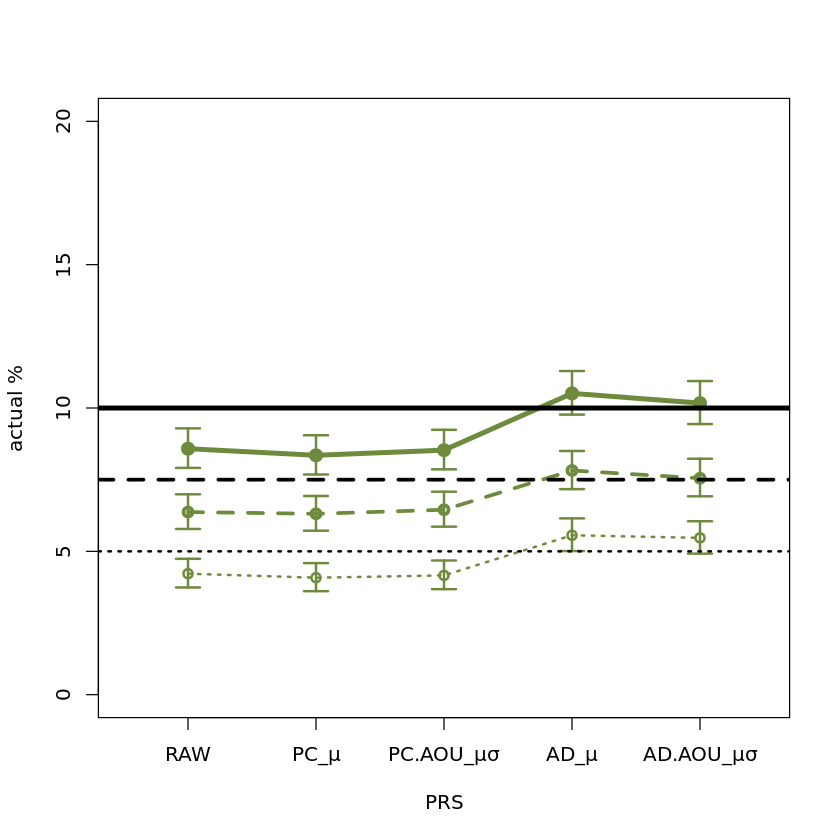

In [22]:
plot.obs.exp.ci.clean(actuals.mat=admixed.actuals,lower.mat=admixed.lower, upper.mat=admixed.upper, my.ancestry="",
                col="darkolivegreen4")
#mtext("H", 2, adj=1, padj=0, line=3, las=2,at=19)

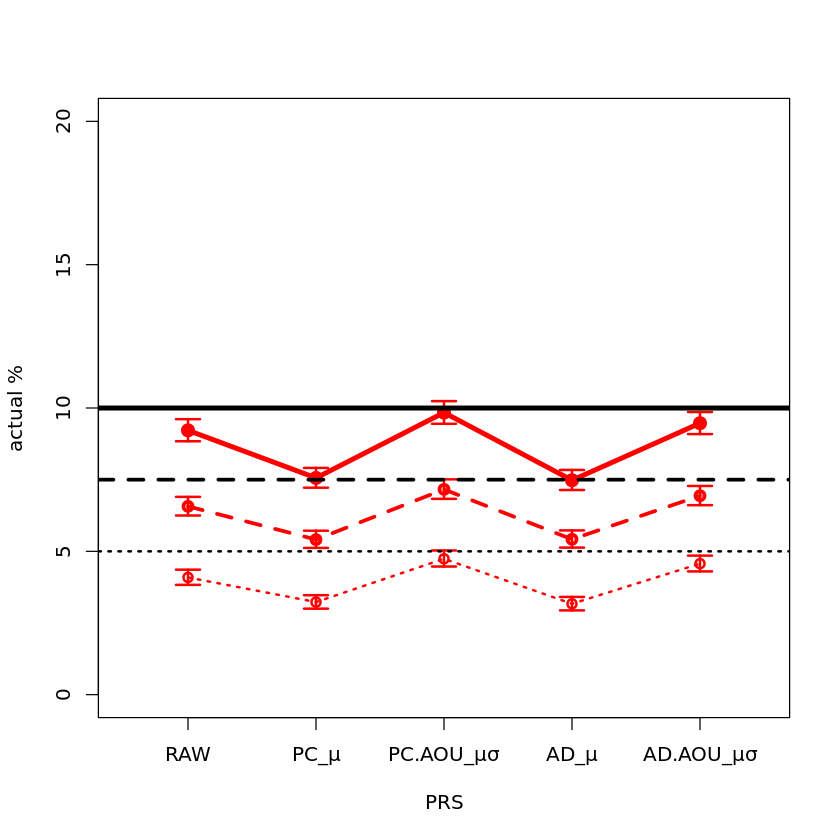

In [31]:
plot.obs.exp.ci.clean(actuals.mat=AFR.actuals,lower.mat=AFR.lower, upper.mat=AFR.upper, my.ancestry="",col="red")

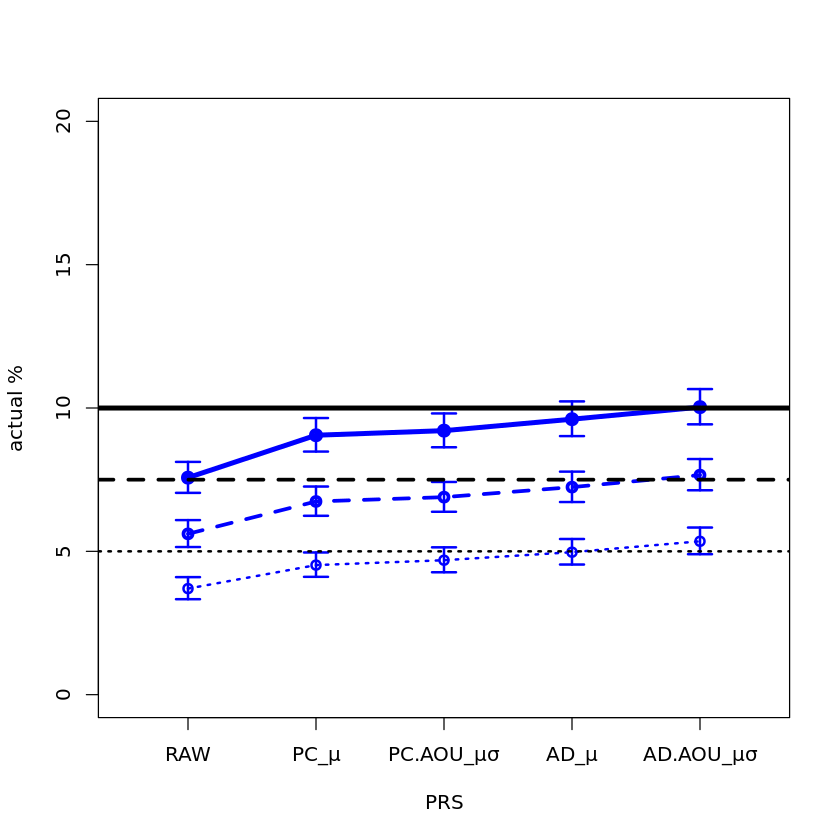

In [32]:
plot.obs.exp.ci.clean(actuals.mat=AMR.actuals,lower.mat=AMR.lower, upper.mat=AMR.upper, my.ancestry="",col="blue")

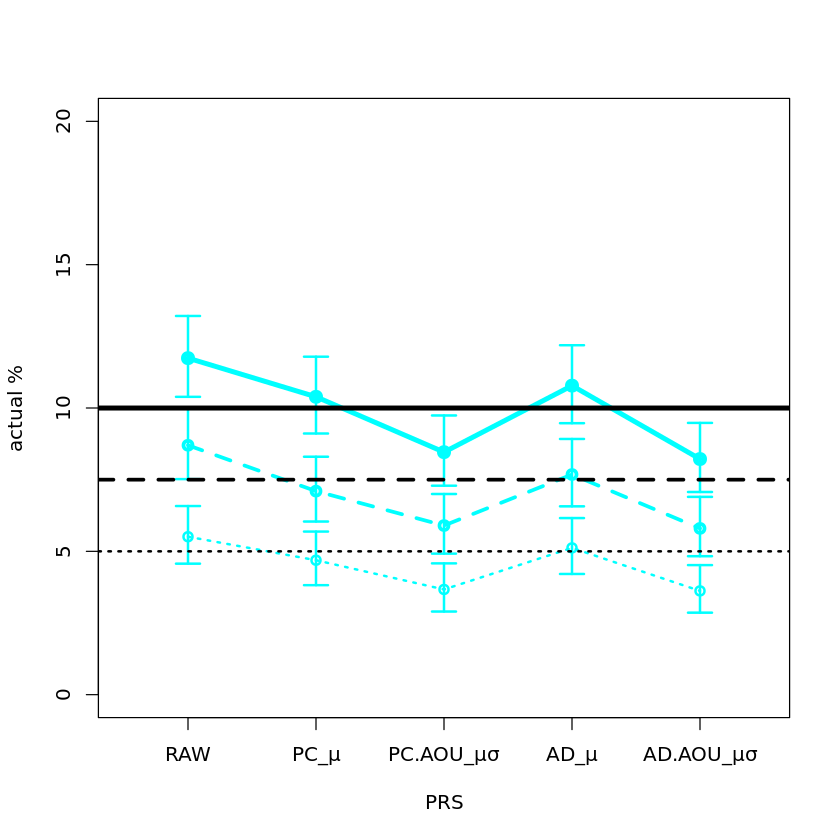

In [33]:
plot.obs.exp.ci.clean(actuals.mat=EAS.actuals,lower.mat=EAS.lower, upper.mat=EAS.upper, my.ancestry="",col="cyan")

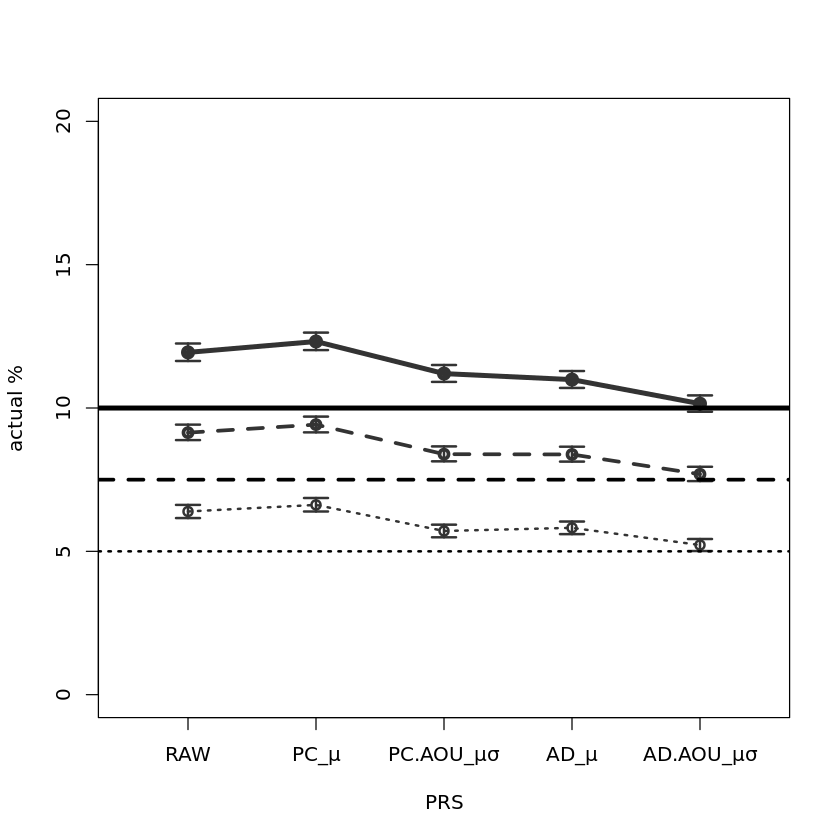

In [34]:
plot.obs.exp.ci.clean(actuals.mat=EUR.actuals,lower.mat=EUR.lower, upper.mat=EUR.upper, my.ancestry="",col="gray20")

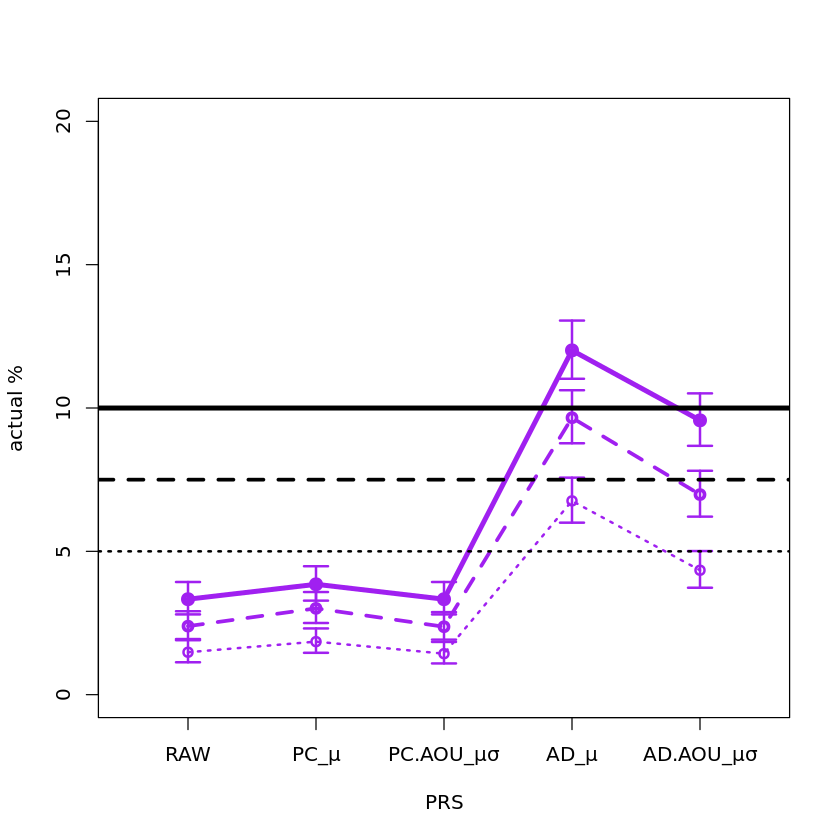

In [35]:
plot.obs.exp.ci.clean(actuals.mat=MID.actuals,lower.mat=MID.lower, upper.mat=MID.upper, my.ancestry="",col="purple")

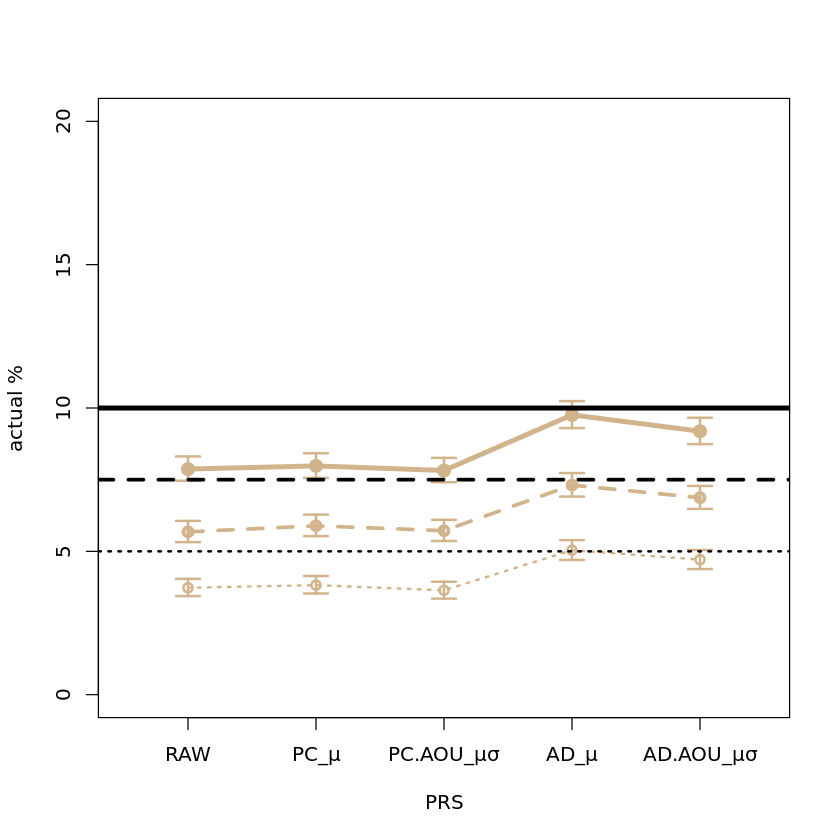

In [36]:
plot.obs.exp.ci.clean(actuals.mat=OTH.actuals,lower.mat=OTH.lower, upper.mat=OTH.upper, my.ancestry="",col="tan")

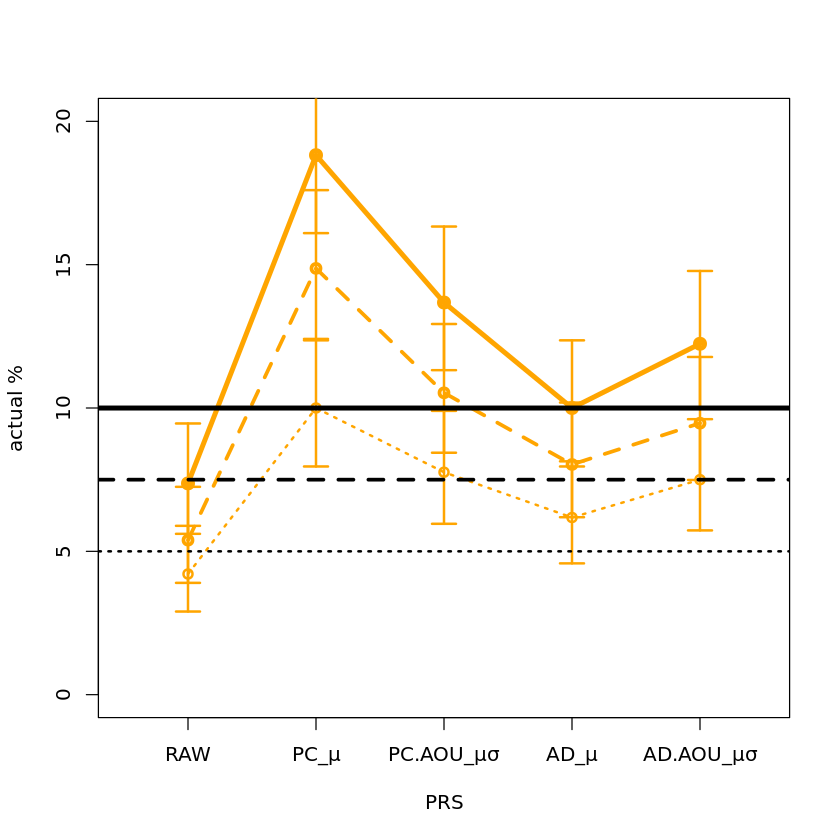

In [37]:
plot.obs.exp.ci.clean(actuals.mat=SAS.actuals,lower.mat=SAS.lower, upper.mat=SAS.upper, my.ancestry="",col="orange")

In [34]:
(layout.matrix <- matrix(c(0,2,4,6,1,3,5,7), nrow=4, ncol=2))
layout(mat = layout.matrix,
       heights = c(2,2,2,2), # Heights of the  rows
       widths = c(2, 2)) # Widths of the two columns

0,1
2,3
4,5
6,7


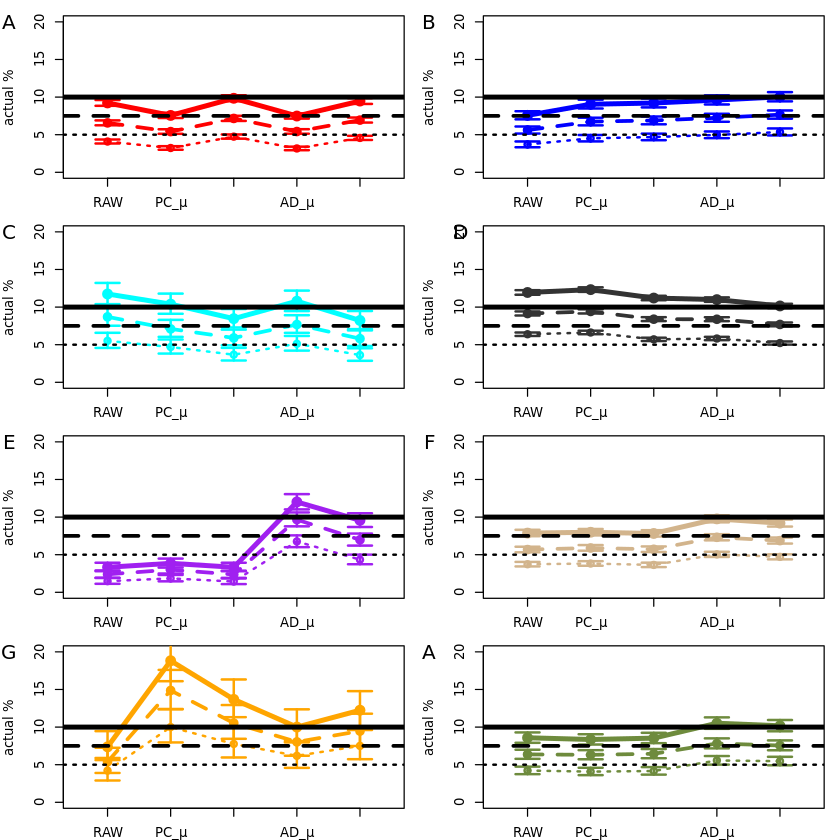

In [48]:
# plot all of them onto a single plot, including letters in the 
# too difficult. I will need to do this separately for all of them
par(mfrow=c(4,2))
#(layout.matrix <- matrix(c(0,2,4,6,1,3,5,7), nrow=4, ncol=2))
#layout(mat = layout.matrix,
#       heights = c(2,2,2,2), # Heights of the  rows
#       widths = c(2, 2)) # Widths of the two columns
par(mar = c(2, 4, 1, 1))
plot.obs.exp.ci.clean(actuals.mat=AFR.actuals,lower.mat=AFR.lower, upper.mat=AFR.upper, my.ancestry="",col="red")
mtext("A", 2, adj=1, padj=0, line=3, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=AMR.actuals,lower.mat=AMR.lower, upper.mat=AMR.upper, my.ancestry="",col="blue")
mtext("B", 2, adj=1, padj=0, line=3, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=EAS.actuals,lower.mat=EAS.lower, upper.mat=EAS.upper, my.ancestry="",col="cyan")
mtext("C", 2, adj=1, padj=0, line=3, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=EUR.actuals,lower.mat=EUR.lower, upper.mat=EUR.upper, my.ancestry="",col="gray20")
mtext("D", 2, adj=1, padj=0, line=1, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=MID.actuals,lower.mat=MID.lower, upper.mat=MID.upper, my.ancestry="",col="purple")
mtext("E", 2, adj=1, padj=0, line=3, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=OTH.actuals,lower.mat=OTH.lower, upper.mat=OTH.upper, my.ancestry="",col="tan")
mtext("F", 2, adj=1, padj=0, line=3, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=SAS.actuals,lower.mat=SAS.lower, upper.mat=SAS.upper, my.ancestry="",col="orange")
mtext("G", 2, adj=1, padj=0, line=3, las=2,at=19)
plot.obs.exp.ci.clean(actuals.mat=admixed.actuals,lower.mat=admixed.lower, upper.mat=admixed.upper, my.ancestry="",
                col="darkolivegreen4")
mtext("H", 2, adj=1, padj=0, line=3, las=2,at=19)

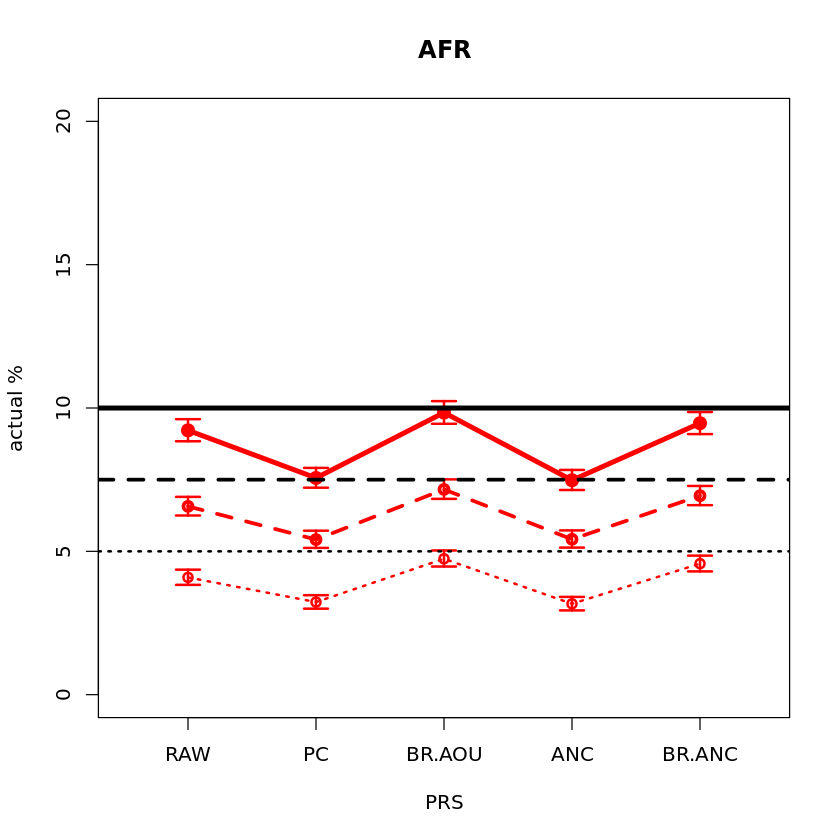

In [91]:
plot.obs.exp.ci(actuals.mat=AFR.actuals,lower.mat=AFR.lower, upper.mat=AFR.upper, my.ancestry="AFR",col="red")

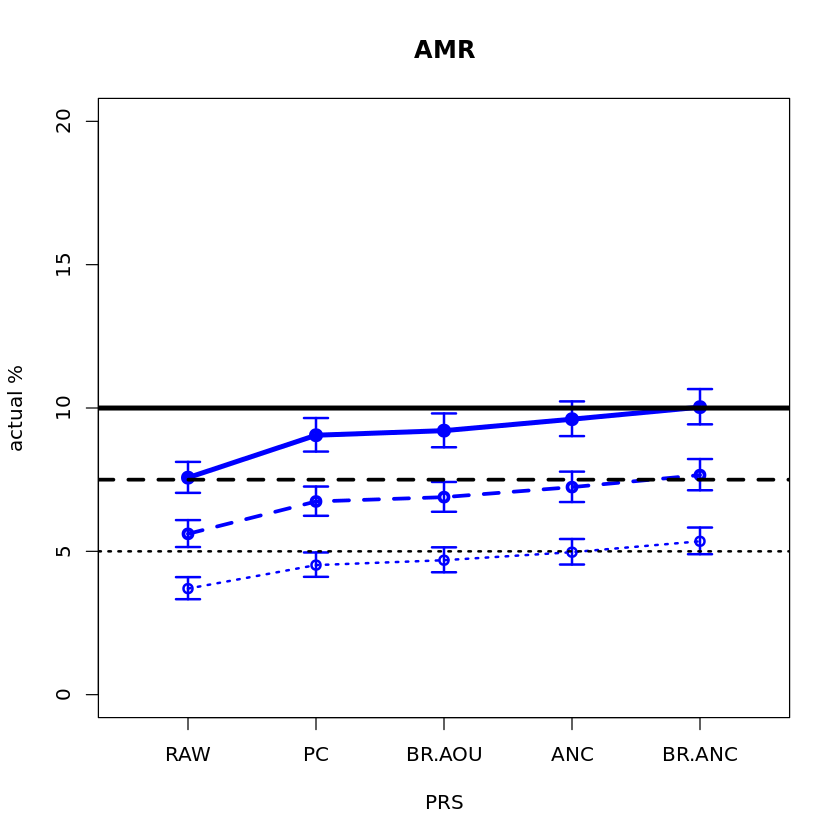

In [90]:
plot.obs.exp.ci(actuals.mat=AMR.actuals,lower.mat=AMR.lower, upper.mat=AMR.upper, my.ancestry="AMR",col="blue")

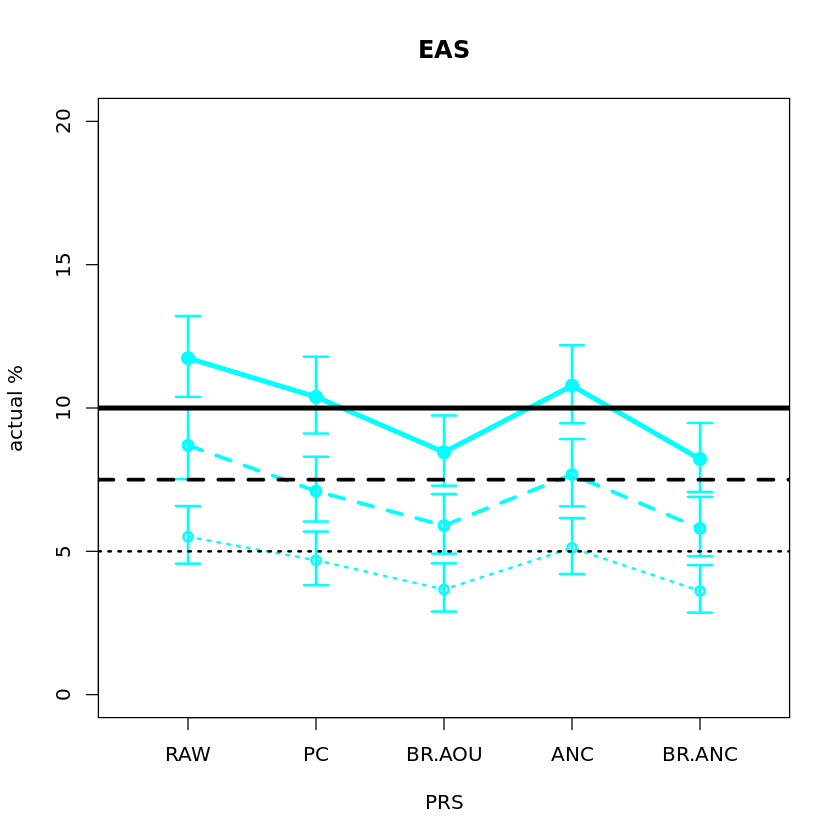

In [89]:
plot.obs.exp.ci(actuals.mat=EAS.actuals,lower.mat=EAS.lower, upper.mat=EAS.upper, my.ancestry="EAS",col="cyan")

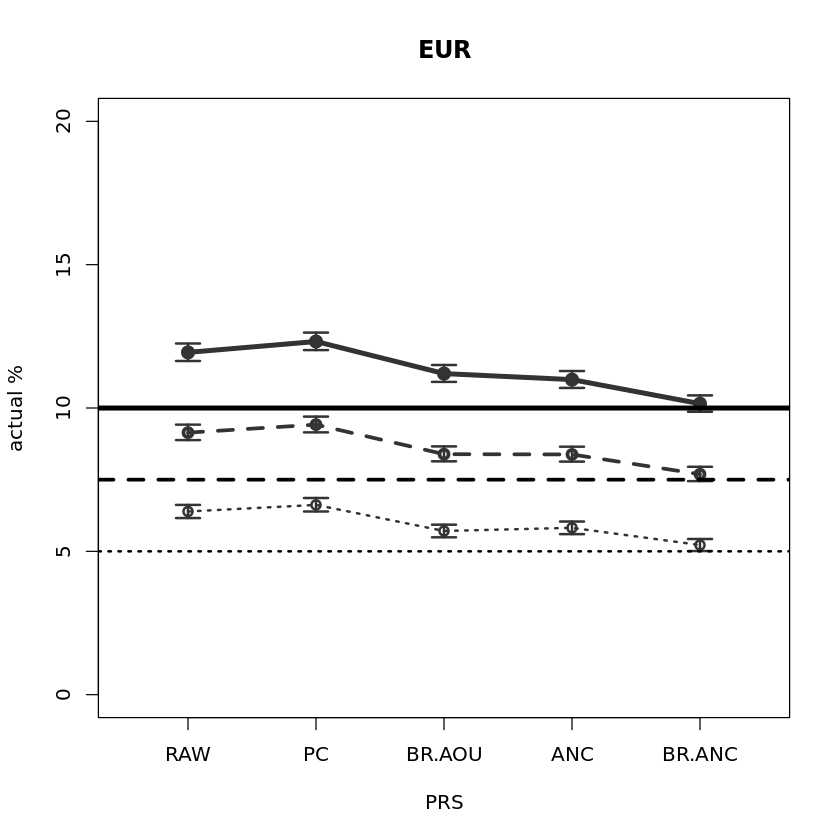

In [88]:
plot.obs.exp.ci(actuals.mat=EUR.actuals,lower.mat=EUR.lower, upper.mat=EUR.upper, my.ancestry="EUR",col="gray20")

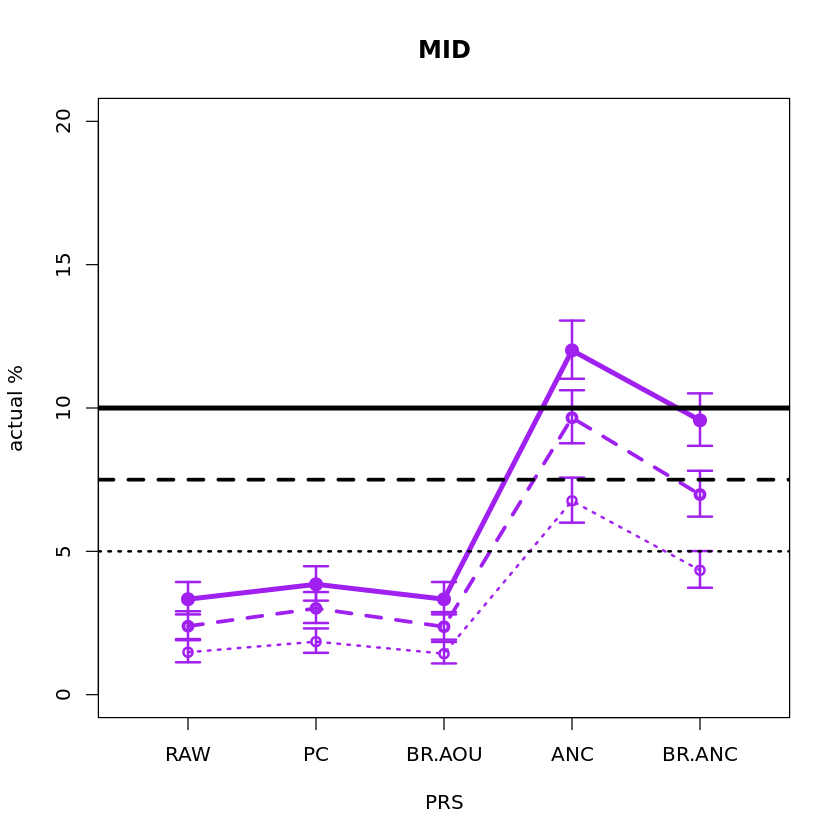

In [87]:
plot.obs.exp.ci(actuals.mat=MID.actuals,lower.mat=MID.lower, upper.mat=MID.upper, my.ancestry="MID",col="purple")

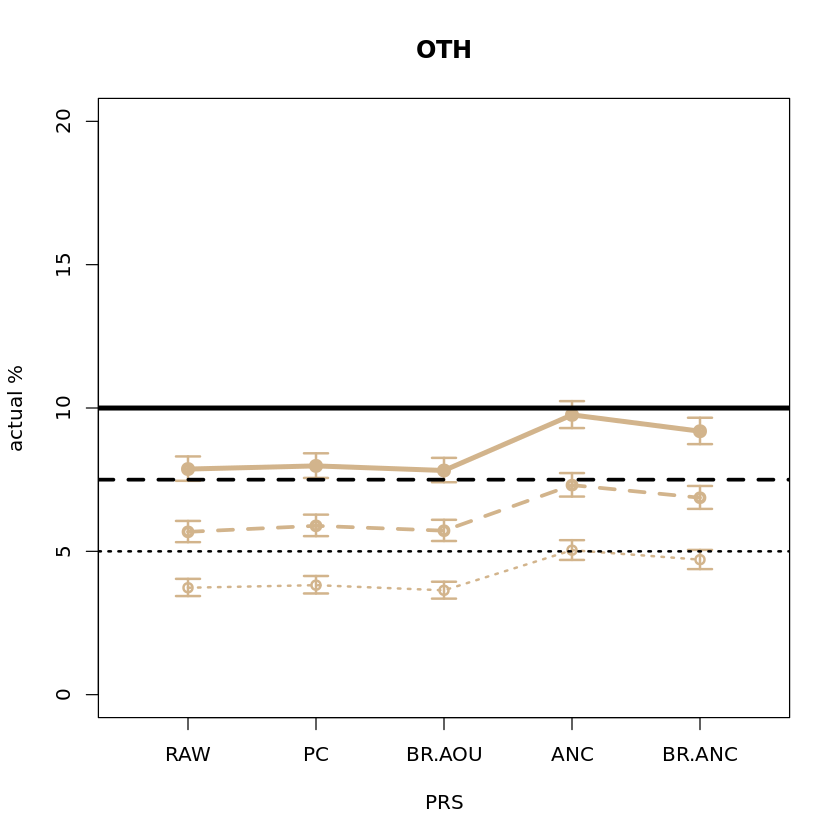

In [86]:
plot.obs.exp.ci(actuals.mat=OTH.actuals,lower.mat=OTH.lower, upper.mat=OTH.upper, my.ancestry="OTH",col="tan")

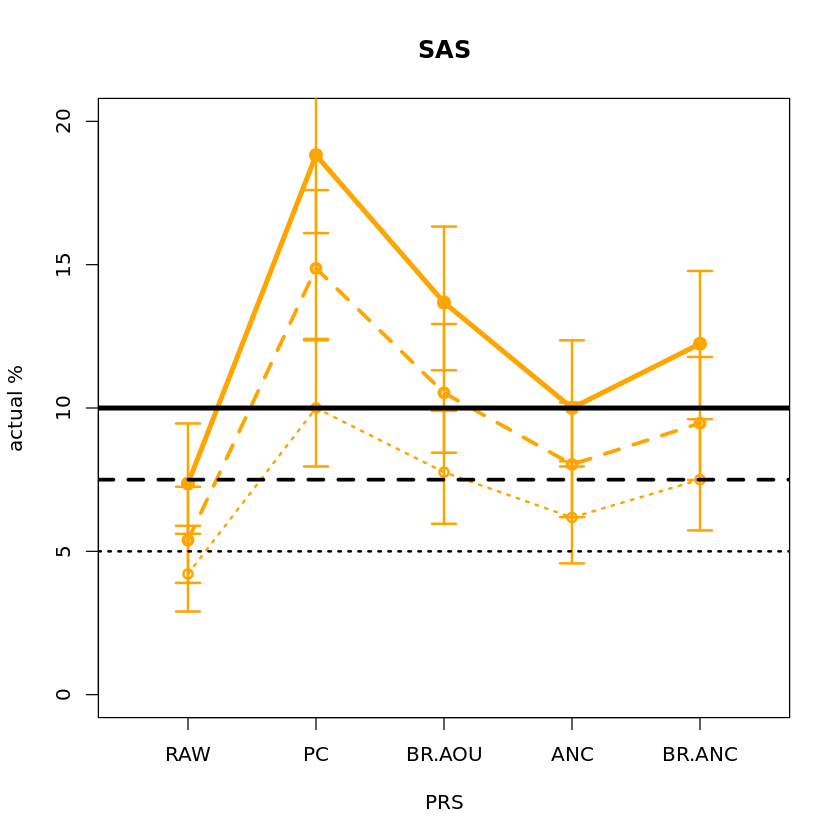

In [85]:
plot.obs.exp.ci(actuals.mat=SAS.actuals,lower.mat=SAS.lower, upper.mat=SAS.upper, my.ancestry="SAS",col="orange")

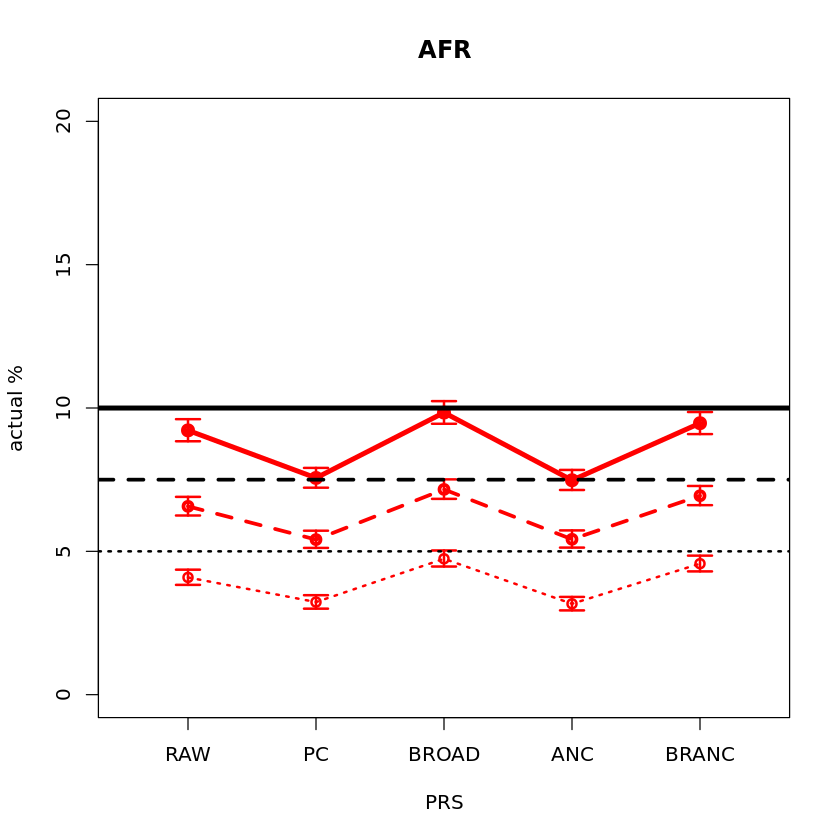

In [75]:
# how do I plot this data the way I want?
horiz.axis <- c(1:5)
actuals.mat <- AFR.actuals
my.ancestry="AFR"
#plot.obs.exp <- function(horiz.axis=c(1:5), actuals.mat, my.ancestry="", col="black")
#{
    matplot(horiz.axis,t(actuals.mat), type="n",main=my.ancestry, xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
    axis(1, at=1:5, labels=c("RAW", "PC","BROAD","ANC","BRANC"))
    matlines(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col="red")
    matpoints(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col="red", pch=1)
    #segments(x0=1,y0=AFR.lower[,1],x1=1,y1=AFR.upper[,1],col="red",lwd=2)
    #segments(x0=2,y0=AFR.lower[,2],x1=2,y1=AFR.upper[,2],col="red",lwd=2)
    #segments(x0=3,y0=AFR.lower[,3],x1=3,y1=AFR.upper[,3],col="red",lwd=2)
    #segments(x0=4,y0=AFR.lower[,4],x1=4,y1=AFR.upper[,4],col="red",lwd=2)
    #segments(x0=5,y0=AFR.lower[,5],x1=5,y1=AFR.upper[,5],col="red",lwd=2)
    arrows(x0=1,y0=AFR.lower[,1],x1=1,y1=AFR.upper[,1],col="red",lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=2,y0=AFR.lower[,2],x1=2,y1=AFR.upper[,2],col="red",lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=3,y0=AFR.lower[,3],x1=3,y1=AFR.upper[,3],col="red",lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=4,y0=AFR.lower[,4],x1=4,y1=AFR.upper[,4],col="red",lwd=2,code=3,angle=90,length=1/10)
    arrows(x0=5,y0=AFR.lower[,5],x1=5,y1=AFR.upper[,5],col="red",lwd=2,code=3,angle=90,length=1/10)

    abline(h=5,lwd=2,lty=3)
    abline(h=7.5,lwd=3, lty=2)
    abline(h=10,lwd=4,lty=1)
#}

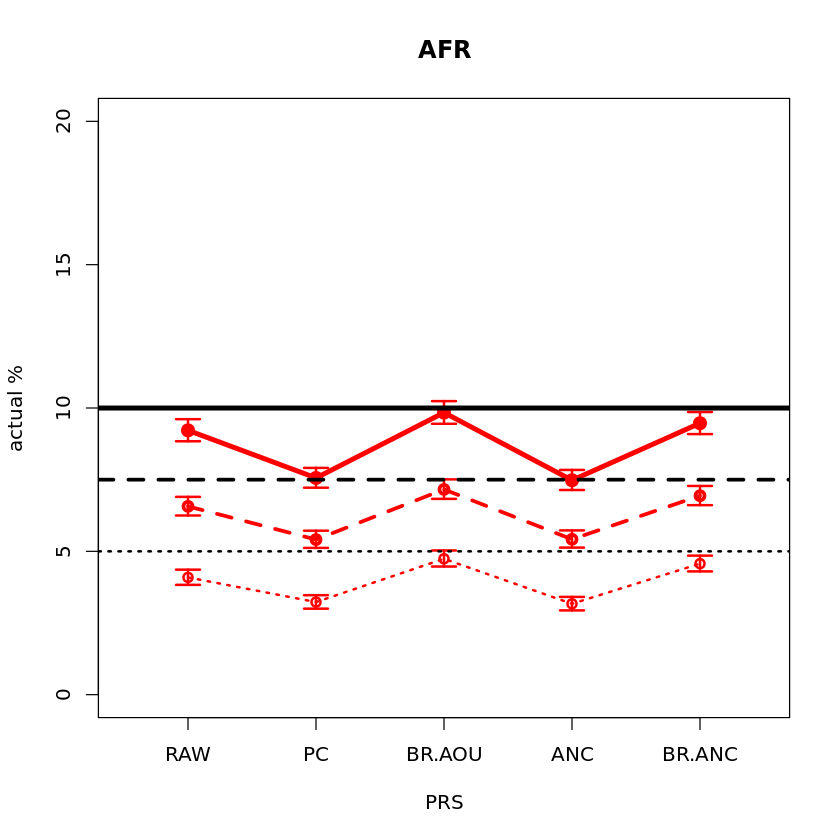

In [78]:
plot.obs.exp.ci(actuals.mat=AFR.actuals,lower.mat=AFR.lower, upper.mat=AFR.upper, my.ancestry="AFR",col="red")

In [56]:
keep.ancestry <- "AMR"
(counts.AMR.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.AMR.norm.PRS <- round(100*counts.AMR.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.AMR.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.AMR.norm.PRS.ADJ.PC <- round(100*counts.AMR.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.AMR.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.AMR.norm.PRS.ADJ.ANC <- round(100*counts.AMR.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.AMR.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.AMR.PRS.BR.AOU1 <- round(100*counts.AMR.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.AMR.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.AMR.PRS.BR.ANC.AOU1 <- round(100*counts.AMR.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 710 526 347

[1] 7.57 5.61 3.70

[1] 849 632 424

[1] 9.05 6.74 4.52

[1] 902 679 466

[1] 9.61 7.24 4.97

[1] 864 646 440

[1] 9.21 6.89 4.69

[1] 941 719 502

[1] 10.03  7.66  5.35

In [57]:
keep.ancestry <- "EAS"
(counts.EAS.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.EAS.norm.PRS <- round(100*counts.EAS.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.EAS.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.EAS.norm.PRS.ADJ.PC <- round(100*counts.EAS.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.EAS.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.EAS.norm.PRS.ADJ.ANC <- round(100*counts.EAS.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.EAS.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.EAS.PRS.BR.AOU1 <- round(100*counts.EAS.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.EAS.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.EAS.PRS.BR.ANC.AOU1 <- round(100*counts.EAS.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 243 180 114

[1] 11.74  8.70  5.51

[1] 215 147  97

[1] 10.39  7.10  4.69

[1] 223 159 106

[1] 10.78  7.68  5.12

[1] 175 122  76

[1] 8.46 5.90 3.67

[1] 170 120  75

[1] 8.22 5.80 3.62

In [58]:
keep.ancestry <- "EUR"
(counts.EUR.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.EUR.norm.PRS <- round(100*counts.EUR.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.EUR.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.EUR.norm.PRS.ADJ.PC <- round(100*counts.EUR.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.EUR.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.EUR.norm.PRS.ADJ.ANC <- round(100*counts.EUR.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.EUR.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.EUR.PRS.BR.AOU1 <- round(100*counts.EUR.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.EUR.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.EUR.PRS.BR.ANC.AOU1 <- round(100*counts.EUR.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 5265 4032 2816

[1] 11.94  9.14  6.39

[1] 5434 4155 2921

[1] 12.32  9.42  6.62

[1] 4848 3697 2565

[1] 10.99  8.38  5.82

[1] 4941 3702 2516

[1] 11.20  8.39  5.71

[1] 4477 3393 2300

[1] 10.15  7.69  5.22

In [46]:
keep.ancestry <- "MID"
(counts.MID.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.MID.norm.PRS <- round(100*counts.MID.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.MID.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.MID.norm.PRS.ADJ.PC <- round(100*counts.MID.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.MID.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.MID.norm.PRS.ADJ.ANC <- round(100*counts.MID.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.MID.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.MID.PRS.BR.AOU1 <- round(100*counts.MID.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.MID.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.MID.PRS.BR.ANC.AOU1 <- round(100*counts.MID.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 24 21 11

[1] 2.84 2.49 1.30

[1] 31 22 15

[1] 3.67 2.61 1.78

[1] 103  82  52

[1] 12.20  9.72  6.16

[1] 23 21 11

[1] 2.73 2.49 1.30

[1] 81 53 32

[1] 9.60 6.28 3.79

In [59]:
keep.ancestry <- "OTH"
(counts.OTH.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.OTH.norm.PRS <- round(100*counts.OTH.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.OTH.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.OTH.norm.PRS.ADJ.PC <- round(100*counts.OTH.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.OTH.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.OTH.norm.PRS.ADJ.ANC <- round(100*counts.OTH.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.OTH.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.OTH.PRS.BR.AOU1 <- round(100*counts.OTH.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.OTH.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.OTH.PRS.BR.ANC.AOU1 <- round(100*counts.OTH.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 1221  881  578

[1] 7.87 5.68 3.73

[1] 1237  914  593

[1] 7.98 5.89 3.82

[1] 1513 1134  781

[1] 9.76 7.31 5.04

[1] 1213  887  564

[1] 7.82 5.72 3.64

[1] 1425 1065  730

[1] 9.19 6.87 4.71

In [60]:
keep.ancestry <- "SAS"
(counts.SAS.norm.PRS <- c(length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS > qnorm(cutoffs[3])])))
(actuals.SAS.norm.PRS <- round(100*counts.SAS.norm.PRS/length(merge.dt$norm.PRS[merge.dt$my.ancestry==keep.ancestry]),2)) 

(counts.SAS.norm.PRS.ADJ.PC <- c(length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.PC > qnorm(cutoffs[3])])))
(actuals.SAS.norm.PRS.ADJ.PC <- round(100*counts.SAS.norm.PRS.ADJ.PC/length(merge.dt$norm.PRS.ADJ.PC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.SAS.norm.PRS.ADJ.ANC <- c(length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[1])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[2])]),
                 length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry & merge.dt$norm.PRS.ADJ.ANC > qnorm(cutoffs[3])])))
(actuals.SAS.norm.PRS.ADJ.ANC <- round(100*counts.SAS.norm.PRS.ADJ.ANC/length(merge.dt$norm.PRS.ADJ.ANC[merge.dt$my.ancestry==keep.ancestry]),2))  

(counts.SAS.PRS.BR.AOU1 <- c(length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.AOU1 > qnorm(cutoffs[3])])))
(actuals.SAS.PRS.BR.AOU1 <- round(100*counts.SAS.PRS.BR.AOU1/length(merge.dt$PRS.BR.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))

(counts.SAS.PRS.BR.ANC.AOU1 <- c(length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[1])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[2])]),
                 length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry & merge.dt$PRS.BR.ANC.AOU1 > qnorm(cutoffs[3])])))
(actuals.SAS.PRS.BR.ANC.AOU1 <- round(100*counts.SAS.PRS.BR.ANC.AOU1/length(merge.dt$PRS.BR.ANC.AOU1[merge.dt$my.ancestry==keep.ancestry]),2))



[1] 56 41 32

[1] 7.37 5.39 4.21

[1] 143 113  76

[1] 18.82 14.87 10.00

[1] 76 61 47

[1] 10.00  8.03  6.18

[1] 104  80  59

[1] 13.68 10.53  7.76

[1] 93 72 57

[1] 12.24  9.47  7.50

In [87]:
AFR.actuals <- cbind(actuals.AFR.norm.PRS, actuals.AFR.norm.PRS.ADJ.PC,actuals.AFR.PRS.BR.AOU1, 
                     actuals.AFR.norm.PRS.ADJ.ANC, 
                     actuals.AFR.PRS.BR.ANC.AOU1)
AMR.actuals <- cbind(actuals.AMR.norm.PRS, actuals.AMR.norm.PRS.ADJ.PC,actuals.AMR.PRS.BR.AOU1,
                     actuals.AMR.norm.PRS.ADJ.ANC, 
                     actuals.AMR.PRS.BR.ANC.AOU1)
EAS.actuals <- cbind(actuals.EAS.norm.PRS, actuals.EAS.norm.PRS.ADJ.PC,actuals.EAS.PRS.BR.AOU1,
                     actuals.EAS.norm.PRS.ADJ.ANC, 
                     actuals.EAS.PRS.BR.ANC.AOU1)
EUR.actuals <- cbind(actuals.EUR.norm.PRS, actuals.EUR.norm.PRS.ADJ.PC,actuals.EUR.PRS.BR.AOU1,
                     actuals.EUR.norm.PRS.ADJ.ANC, 
                     actuals.EUR.PRS.BR.ANC.AOU1)
MID.actuals <- cbind(actuals.MID.norm.PRS, actuals.MID.norm.PRS.ADJ.PC,actuals.MID.PRS.BR.AOU1,
                     actuals.MID.norm.PRS.ADJ.ANC, 
                     actuals.MID.PRS.BR.ANC.AOU1)
OTH.actuals <- cbind(actuals.OTH.norm.PRS, actuals.OTH.norm.PRS.ADJ.PC,actuals.OTH.PRS.BR.AOU1,
                     actuals.OTH.norm.PRS.ADJ.ANC, 
                     actuals.OTH.PRS.BR.ANC.AOU1)
SAS.actuals <- cbind(actuals.SAS.norm.PRS, actuals.SAS.norm.PRS.ADJ.PC,actuals.SAS.PRS.BR.AOU1,
                     actuals.SAS.norm.PRS.ADJ.ANC, 
                     actuals.SAS.PRS.BR.ANC.AOU1)

In [62]:
horiz.axis <- c(1,2,3,4,5)

In [ ]:
# to do: create a function for the plot, change the order so that it is in raw, PC, BROAD, ANC, BRANC.
# This might help make the comparisons easier to see. 
# changing the order requires that I input the matrix in the order I want

In [89]:
plot.obs.exp <- function(horiz.axis=c(1:5), actuals.mat, my.ancestry="", col="black")
{
    matplot(horiz.axis,t(actuals.mat), type="n", main=my.ancestry, xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
    axis(1, at=1:5, labels=c("RAW", "PC","BROAD","ANC","BRANC"))
    matlines(horiz.axis, t(actuals.mat), lwd=c(4, 3, 2), col=col)
    abline(h=5,lwd=2,lty=3)
    abline(h=7.5,lwd=3, lty=2)
    abline(h=10,lwd=4,lty=1)
}

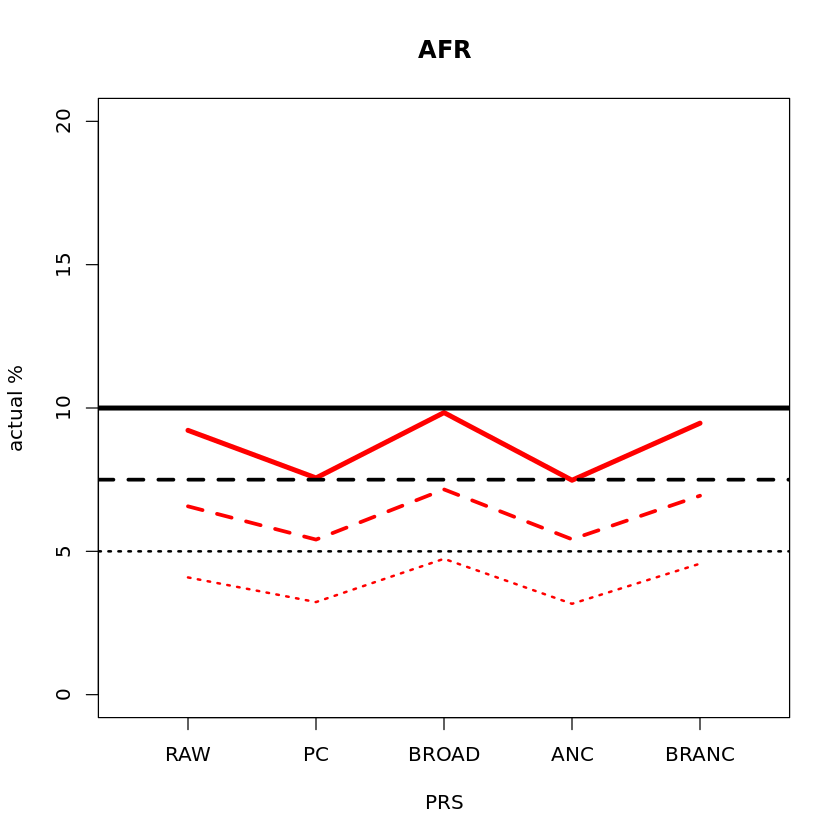

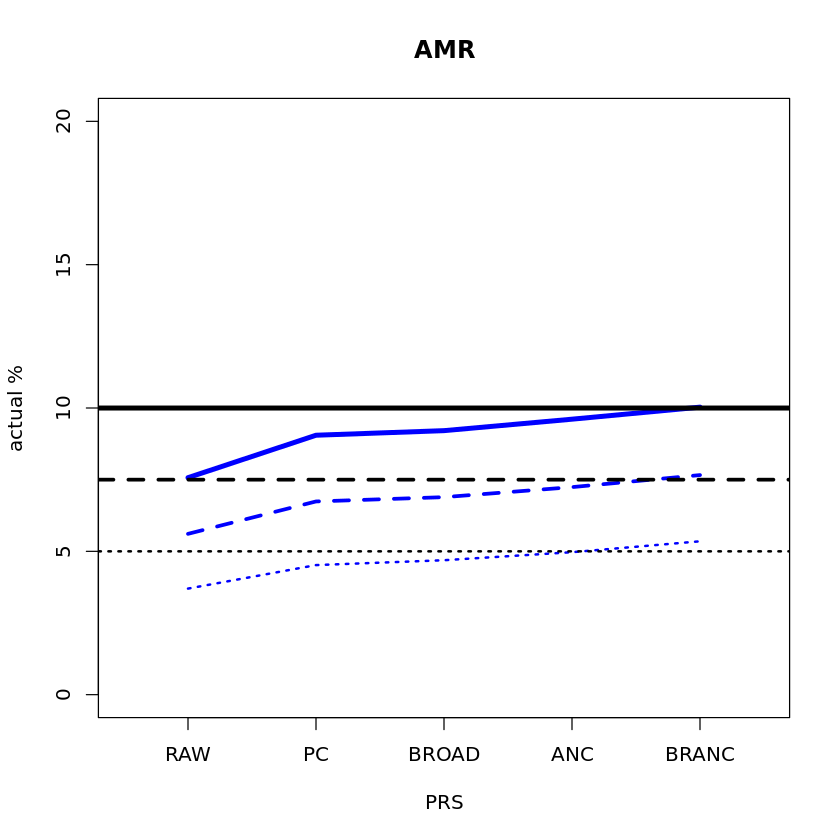

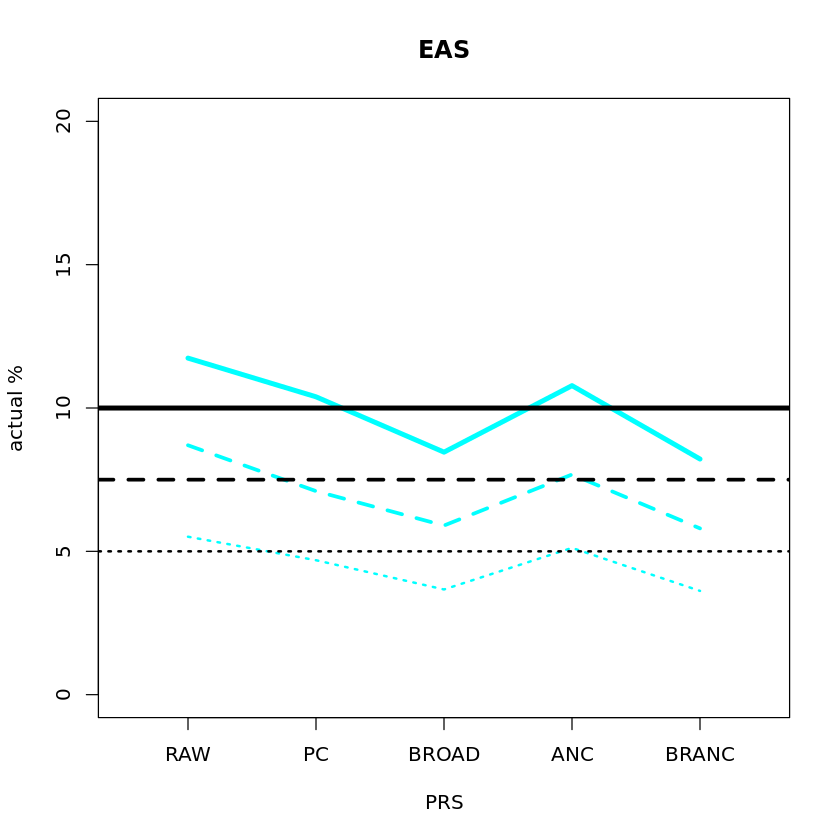

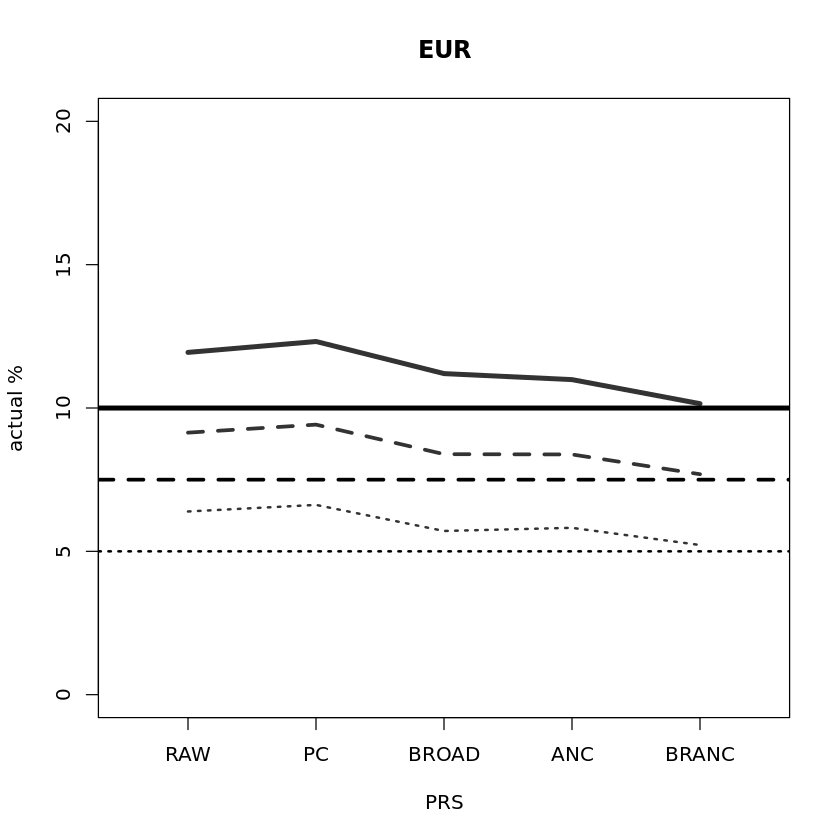

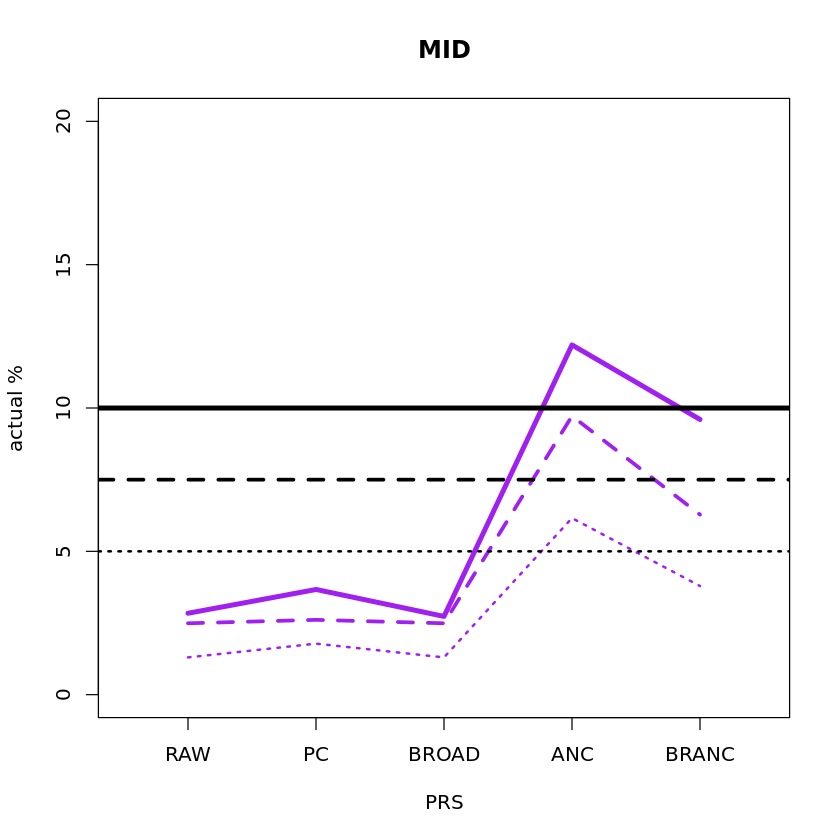

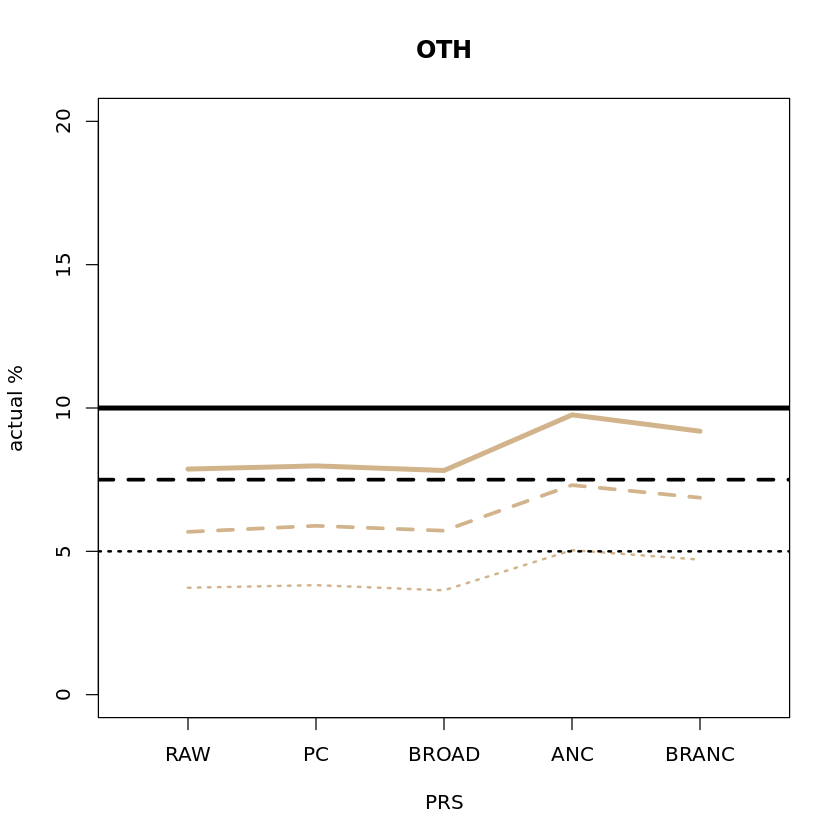

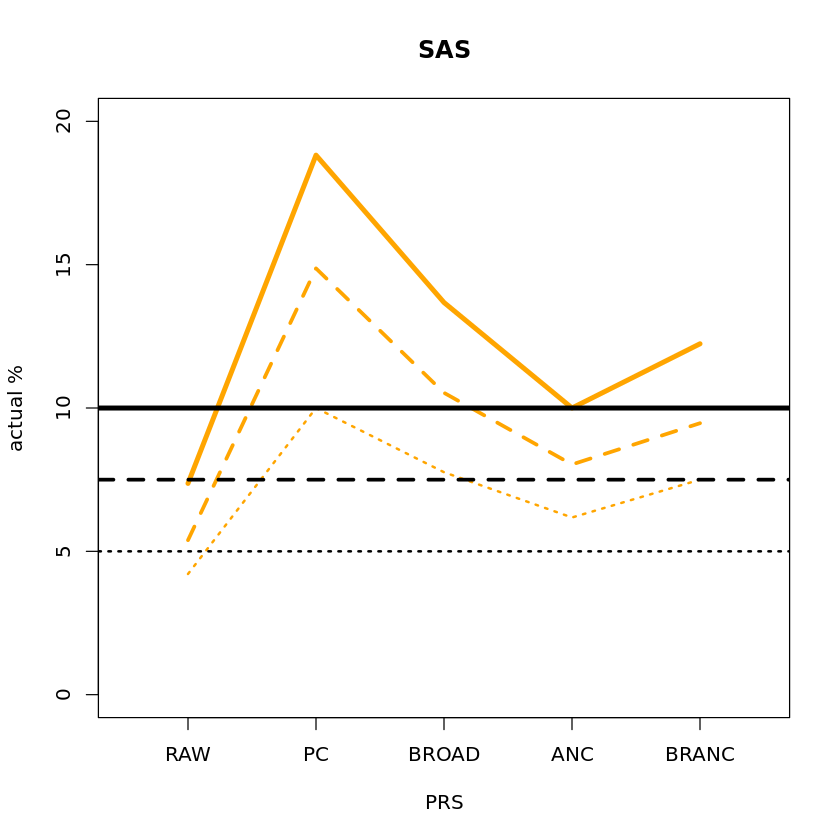

In [91]:
plot.obs.exp(actuals.mat=AFR.actuals,my.ancestry="AFR", col="red")
plot.obs.exp(actuals.mat=AMR.actuals,my.ancestry="AMR", col="blue")
plot.obs.exp(actuals.mat=EAS.actuals,my.ancestry="EAS", col="cyan")
plot.obs.exp(actuals.mat=EUR.actuals,my.ancestry="EUR", col="gray20")
plot.obs.exp(actuals.mat=MID.actuals,my.ancestry="MID", col="purple")
plot.obs.exp(actuals.mat=OTH.actuals,my.ancestry="OTH", col="tan")
plot.obs.exp(actuals.mat=SAS.actuals,my.ancestry="SAS", col="orange")

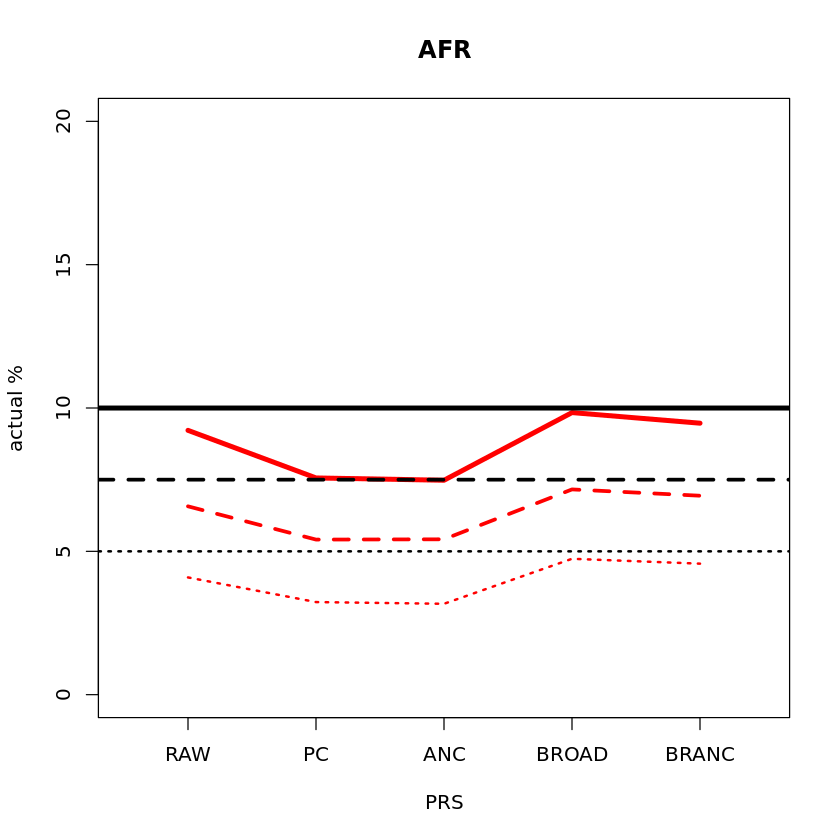

In [86]:
matplot(horiz.axis,t(AFR.actuals), type="n", main="AFR", xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(AFR.actuals), lwd=c(4, 3, 2), col="red")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

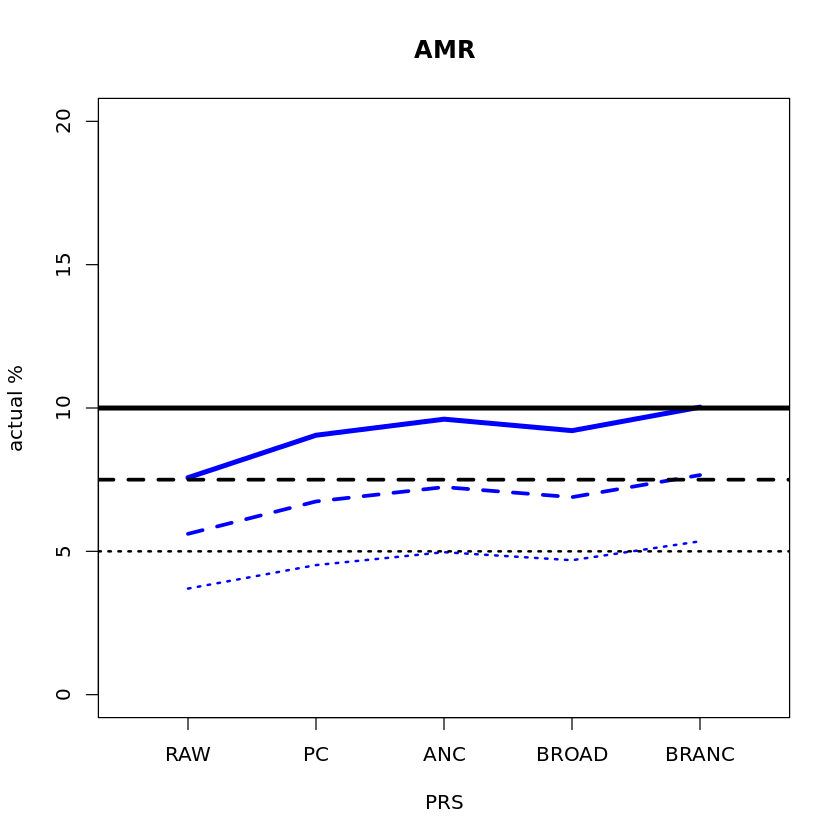

In [85]:
matplot(horiz.axis,t(AMR.actuals), type="n", main="AMR", xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(AMR.actuals), lwd=c(4, 3, 2), col="blue")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

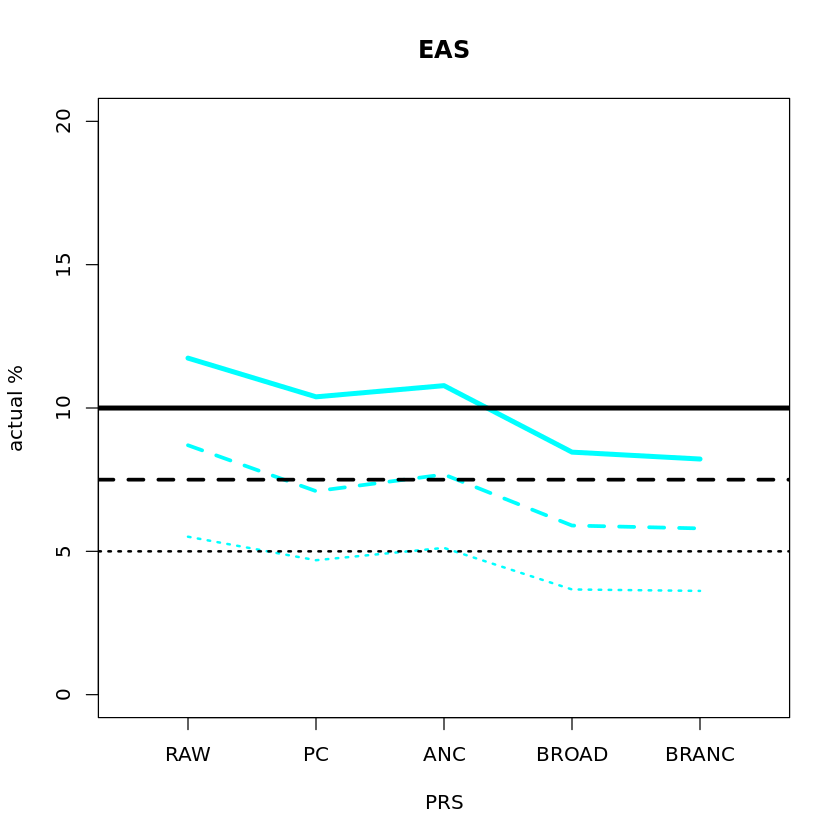

In [84]:
matplot(horiz.axis,t(EAS.actuals), type="n", main="EAS", xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(EAS.actuals), lwd=c(4, 3, 2), col="cyan")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

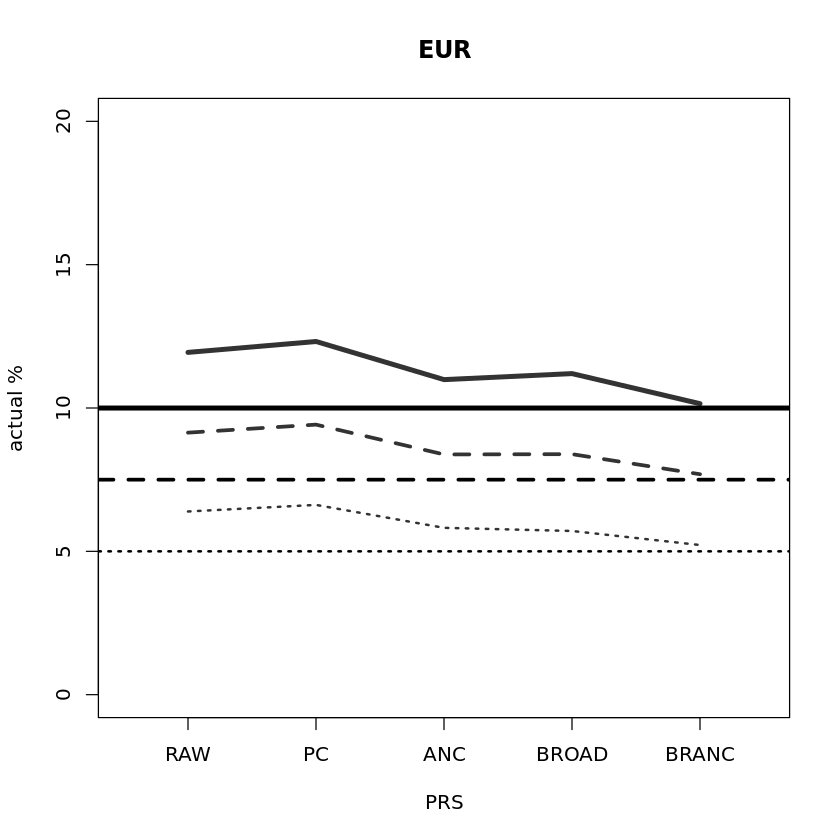

In [83]:
matplot(horiz.axis,t(EUR.actuals), type="n", main="EUR", xlab="PRS", ylab="actual %", xaxt = "n", 
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(EUR.actuals), lwd=c(4, 3, 2), col="gray20")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

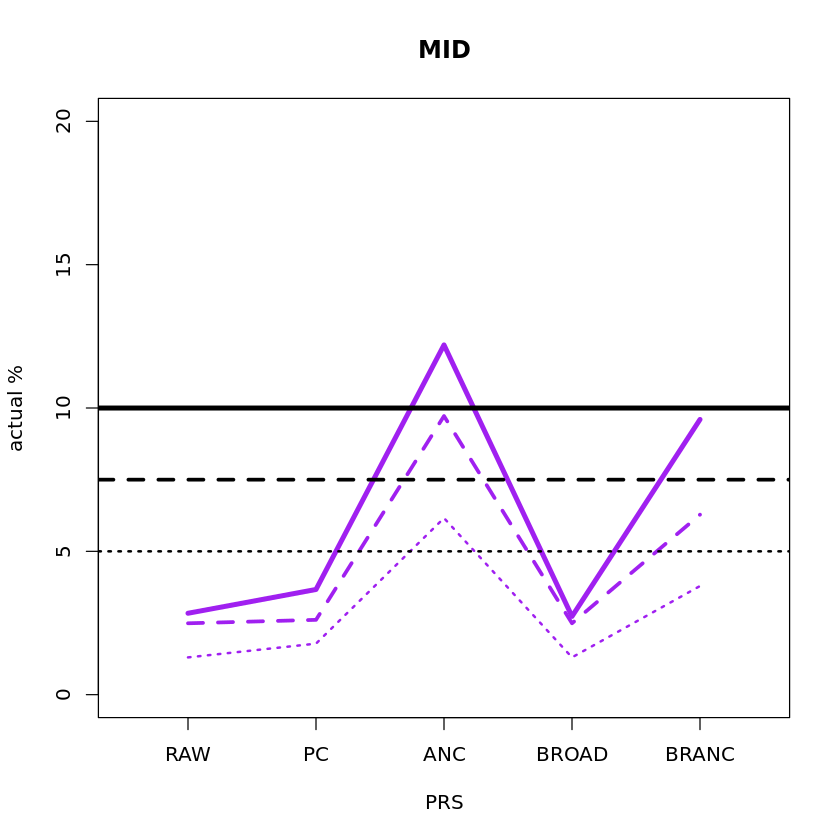

In [82]:
matplot(horiz.axis,t(MID.actuals), type="n", main="MID", xlab="PRS", ylab="actual %", xaxt = "n",
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(MID.actuals), lwd=c(4, 3, 2), col="purple")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

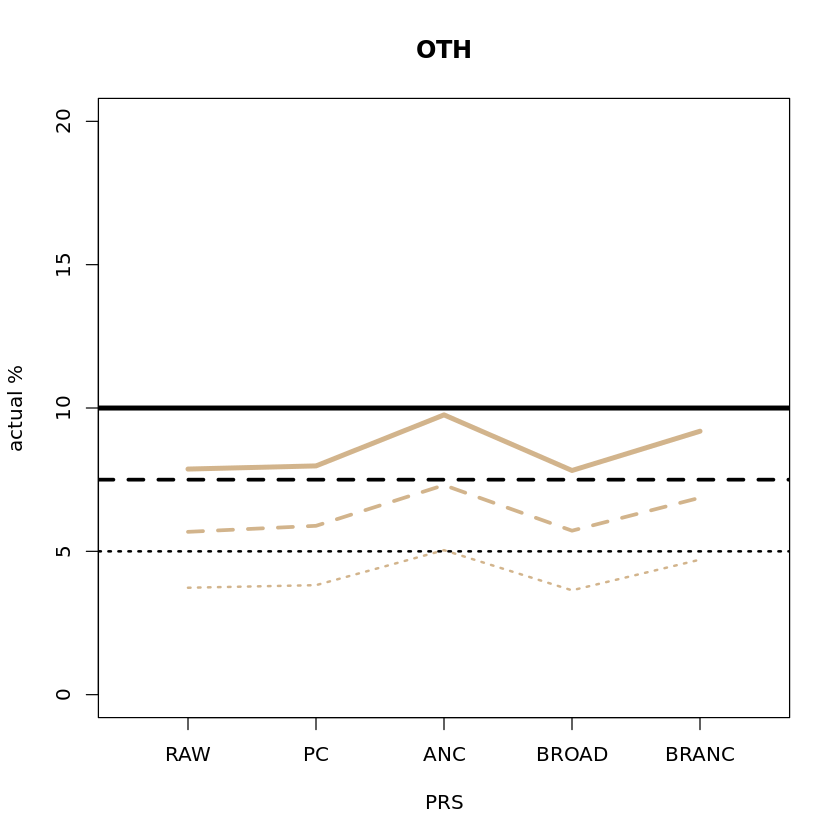

In [81]:
matplot(horiz.axis,t(OTH.actuals), type="n", main="OTH", xlab="PRS", ylab="actual %", xaxt = "n",
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(OTH.actuals), lwd=c(4, 3, 2), col="tan")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

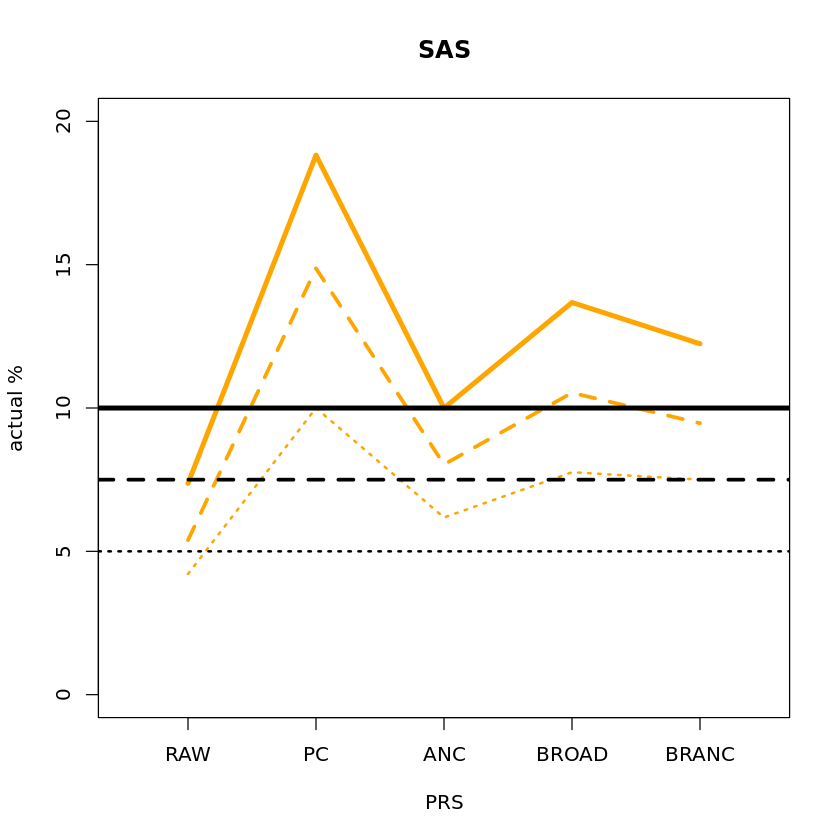

In [80]:
matplot(horiz.axis,t(SAS.actuals), type="n", main="SAS", xlab="PRS", ylab="actual %", xaxt = "n",
        xlim=c(0.5, 5.5),ylim=c(0,20))
axis(1, at=1:5, labels=c("RAW", "PC","ANC","BROAD","BRANC"))
matlines(horiz.axis, t(SAS.actuals), lwd=c(4, 3, 2), col="orange")
abline(h=5,lwd=2,lty=3)
abline(h=7.5,lwd=3, lty=2)
abline(h=10,lwd=4,lty=1)

# Set up the lists for the AUC comparisons

list := Compare all cases (CSET1) with all controls

list2 := Compare clean cases (CSET3) with screened controls

list3 := Compare all cases with (CSET1) with screened controls

In [28]:
# create empty list to contain the tables for each ancestry which should be in the order:
# AFR, AMR, EAS, EUR, MID, OTH, SAS
basic.auc.list <- vector(mode = "list", length = 4) # For AUC without adjusting the AUC for censored age, sex
adj.auc.list <- vector(mode = "list", length = 4) # For AUC adjusted for censored age and sex



In [29]:
# list2 contains comparisons between CSET3 and controls.A
basic.auc.list2 <- vector(mode = "list", length = 4) # For AUC without adjusting the AUC for censored age, sex
adj.auc.list2 <- vector(mode = "list", length = 4) # For AUC adjusted for censored age and sex

In [30]:
# list3 contains comparisons between CSET1 and all controls
basic.auc.list3 <- vector(mode = "list", length = 4) # For AUC without adjusting the AUC for censored age, sex
adj.auc.list3 <- vector(mode = "list", length = 4) # For AUC adjusted for censored age and sex

In [31]:
# set the iterator so that I can add to the list easily
ancestry.iter <- 0

In [30]:
# for each ancestry, iterate up one. keeping this cell separate in case I have to rerun other cells within an ancestry
ancestry.iter <- ancestry.iter + 1

**get the length of the subset for all ancestries**

In [34]:

# what comparisons do I want to make? Do, I want to compare just within ethnic groups? 
# do I want to standardize to mean 0, s.d. 1 using everyone and then split into ancestry groups? 
# or do I standardize after splitting into ancestry groups? 
# If I am considering the AUC then I don't need to worry about the standardization, I think.
# how do I want to make this into a function
keep.ancestry <- "AFR"
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry]
length(subset.dt$PRS)
attach(subset.dt)
# can I get into table format? Why am I getting negative values? 
(auc.1 <- data.table(rbind(
    pROC::ci.auc(CRC.status,PRS),
    pROC::ci.auc(CRC.status,PRS.ADJ.PC),
    pROC::ci.auc(CRC.status,PRS.ADJ.ANC),
    pROC::ci.auc(CRC.status,BROAD.PRS)
    )) )
detach(subset.dt)
header.names <- c("lower","AUC","upper")
setnames(auc.1,header.names)
auc.1[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.1[,PRS:=c("RAW.PRS","ADJ.PC","ADJ.ANC","BROAD")]
auc.1.table <- data.table(as.data.frame(auc.1) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.1.table,c("PRS","AUC","CI")))



[1] 22368

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



V1,V2,V3
<dbl>,<dbl>,<dbl>
0.5172831,0.5780356,0.6387881
0.5179828,0.5774706,0.6369583
0.5180763,0.5786903,0.6393043
0.5192165,0.5789701,0.6387236


PRS,AUC,CI
<chr>,<dbl>,<chr>
RAW.PRS,0.58,"0.52, 0.64"
ADJ.PC,0.58,"0.52, 0.64"
ADJ.ANC,0.58,"0.52, 0.64"
BROAD,0.58,"0.52, 0.64"


In [35]:
# can I update the column names at this point (except for the PRS column)
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.1.table)[c(2,3)]))
setnames(auc.1.table, names(auc.1.table)[c(2,3)], new.labels)
names(auc.1.table)

[1] "AFR.AUC" "AFR.CI"

[1] "PRS"     "AFR.AUC" "AFR.CI"

In [36]:
# add table to list
basic.auc.list[[ancestry.iter]] <- auc.1.table
str(basic.auc.list)

List of 7
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  3 variables:
  ..$ PRS    : chr [1:4] "RAW.PRS" "ADJ.PC" "ADJ.ANC" "BROAD"
  ..$ AFR.AUC: num [1:4] 0.58 0.58 0.58 0.58
  ..$ AFR.CI : chr [1:4] "0.52, 0.64" "0.52, 0.64" "0.52, 0.64" "0.52, 0.64"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  3 variables:
  ..$ PRS    : chr [1:4] "RAW.PRS" "ADJ.PC" "ADJ.ANC" "BROAD"
  ..$ AFR.AUC: num [1:4] 0.58 0.58 0.58 0.58
  ..$ AFR.CI : chr [1:4] "0.52, 0.64" "0.52, 0.64" "0.52, 0.64" "0.52, 0.64"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL
 $ : NULL
 $ : NULL
 $ : NULL
 $ : NULL


In [104]:
#names(subset.dt)
#lm.controls <- lm(my.PRS ~ sex + censored.age, data=subset.dt[][subset.dt$CRC.status==0])
#summary(lm.controls)
#subset.dt$prs.adj.age.sex <- (subset.dt$my.PRS - (lm.controls$coef[1] + lm.controls$coef["sex"] * subset.dt$sex 
#                                 + lm.controls$coef["censored.age"] * subset.dt$censored.age)) / sd(lm.controls$residuals)
#describe(subset.dt$prs.adj.age.sex)
#head(subset.dt[,list(my.PRS, sex, censored.age,prs.adj.age.sex)][is.na(subset.dt$prs.adj.age.sex)])
#auc.adjusted(subset.dt)

**this cell had a fix. need to remove all missing sex. Will beed to update for all ancestries**

In [39]:
# check the auc adjust function
# and remove the ~10K participants that are missing censored age. So the basic AUC will have larger sample size at this time
#keep.ancestry <- "AFR"
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & !is.na(merge.dt$censored.age) & !is.na(merge.dt$sex)]
length(subset.dt$PRS)
describe(subset.dt$sex)
subset.dt[,my.PRS:=PRS]
(auc.prs.raw <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.PC]
(auc.prs.adj.pc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.ANC]
(auc.prs.adj.anc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=BROAD.PRS]
(auc.prs.broad <- auc.adjusted(subset.dt))


[1] 21009

subset.dt$sex 
       n  missing distinct     Info      Sum     Mean      Gmd 
   21009        0        2    0.735     9028   0.4297   0.4901 


[1] 0.5821182

[1] 0.5771833

[1] 0.581967

[1] 0.5774333

**Number of iterations was set to 500 in Section 2, Function**

In [40]:
# can I iterate over the function to get a bootstrap C.I. for each of the adjusted PRSs?
# keep this part separate from table creation and getting the auc because it can take a long time
#niter <- 10
n <- length(subset.dt$CRC.status)
for(i in 1:niter)
    {
    sp=sample(1:n,n,replace=T)  
    subset.dt[,PRS:=PRS]
    auc.prs.raw <- c(auc.prs.raw, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.PC]
    auc.prs.adj.pc <- c(auc.prs.adj.pc, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.ANC]
    auc.prs.adj.anc <- c(auc.prs.adj.anc, auc.adjusted(subset.dt[sp,]))    
    subset.dt[,my.PRS:=BROAD.PRS]
    auc.prs.broad <- c(auc.prs.broad, auc.adjusted(subset.dt[sp,]))    
}
# Maybe make the below a function as well so I don't have to write stuff over and over
(ci.auc.prs.raw=c(auc.prs.raw[1] - 1.96*sd(auc.prs.raw), auc.prs.raw[1] + 1.96*sd(auc.prs.raw)))
(ci.auc.prs.adj.pc=c(auc.prs.adj.pc[1] - 1.96*sd(auc.prs.adj.pc), auc.prs.adj.pc[1] + 1.96*sd(auc.prs.adj.pc)))
(ci.auc.prs.adj.anc=c(auc.prs.adj.anc[1] - 1.96*sd(auc.prs.adj.anc), auc.prs.adj.anc[1] + 1.96*sd(auc.prs.adj.anc)))
(ci.auc.broad=c(auc.prs.broad[1] - 1.96*sd(auc.prs.broad), auc.prs.broad[1] + 1.96*sd(auc.prs.broad)))

# check the CI function
auc.boot.ci(auc.prs.raw)
auc.boot.ci(auc.prs.adj.pc)
auc.boot.ci(auc.prs.adj.anc)
auc.boot.ci(auc.prs.adj.anc)



[1] 0.5083466 0.6558897

[1] 0.5034139 0.6509527

[1] 0.5081956 0.6557385

[1] 0.5036638 0.6512028

[1] 0.5083466 0.6558897

[1] 0.5034139 0.6509527

[1] 0.5081956 0.6557385

[1] 0.5081956 0.6557385

In [27]:
#make into a table
auc.adj <- c(auc.prs.raw[1], auc.prs.adj.pc[1], auc.prs.adj.anc[1],auc.prs.broad[1])
auc.2 <- data.table(
    cbind(auc.adj, rbind(auc.boot.ci(auc.prs.raw), auc.boot.ci(auc.prs.adj.pc), auc.boot.ci(auc.prs.adj.anc), auc.boot.ci(auc.prs.adj.anc) ))
    )
header.names <- c("lower","AUC","upper")
setnames(auc.2,header.names)
auc.2[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.2[,PRS:=c("PRS.RAW","ADJ.PC","ADJ.ANC","BROAD")]
auc.2.table <- data.table(as.data.frame(auc.2) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.2.table,c("PRS","AUC","CI")))

PRS,AUC,CI
<chr>,<dbl>,<chr>
PRS.RAW,0.50,"0.58, 0.67"
ADJ.PC,0.49,"0.58, 0.66"
ADJ.ANC,0.50,"0.58, 0.67"
BROAD,0.50,"0.58, 0.67"


In [28]:
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.2.table)[c(2,3)]))
setnames(auc.2.table, names(auc.2.table)[c(2,3)], new.labels)
names(auc.2.table)

[1] "AFR.AUC" "AFR.CI"

[1] "PRS"     "AFR.AUC" "AFR.CI"

In [29]:
adj.auc.list[[ancestry.iter]] <- auc.2.table
str(adj.auc.list)

List of 7
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  3 variables:
  ..$ PRS    : chr [1:4] "PRS.RAW" "ADJ.PC" "ADJ.ANC" "BROAD"
  ..$ AFR.AUC: num [1:4] 0.5 0.49 0.5 0.5
  ..$ AFR.CI : chr [1:4] "0.58, 0.67" "0.58, 0.66" "0.58, 0.67" "0.58, 0.67"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL
 $ : NULL
 $ : NULL
 $ : NULL
 $ : NULL
 $ : NULL


# Calculation for all participants, CSET3 vs controls.A

In [32]:
keep.ancestry <- "ALL"
subset.dt <- merge.dt[][(merge.dt$CSET3==1 | merge.dt$SCREENED==1)]
length(subset.dt$PRS)
attach(subset.dt)
# can I get into table format? Why am I getting negative values? 
(auc.1 <- data.table(rbind(
    pROC::ci.auc(CRC.status,PRS),
    pROC::ci.auc(CRC.status,PRS.ADJ.PC),
    pROC::ci.auc(CRC.status,PRS.ADJ.ANC),
    pROC::ci.auc(CRC.status,BROAD.PRS)
    )) )
detach(subset.dt)
header.names <- c("lower","AUC","upper")
setnames(auc.1,header.names)
auc.1[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.1[,PRS:=c("RAW.PRS","ADJ.PC","ADJ.ANC","BROAD")]
auc.1.table <- data.table(as.data.frame(auc.1) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.1.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.1.table)[c(2,3)]))
setnames(auc.1.table, names(auc.1.table)[c(2,3)], new.labels)
#names(auc.1.table)
(auc.1.table[,PRS:=NULL])


# check the auc adjust function
# The basic AUC will have larger sample size at this time
subset.dt <- merge.dt[][(merge.dt$CSET3==1 | merge.dt$SCREENED==1) &
                        !is.na(merge.dt$censored.age) &
                        merge.dt$censored.age <=91  & !is.na(merge.dt$sex)]
length(subset.dt$PRS)
subset.dt[,my.PRS:=PRS]
(auc.prs.raw <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.PC]
(auc.prs.adj.pc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.ANC]
(auc.prs.adj.anc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=BROAD.PRS]
(auc.prs.broad <- auc.adjusted(subset.dt))


n <- length(subset.dt$CRC.status)
for(i in 1:niter)
    {
    sp=sample(1:n,n,replace=T)  
    subset.dt[,PRS:=PRS]
    auc.prs.raw <- c(auc.prs.raw, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.PC]
    auc.prs.adj.pc <- c(auc.prs.adj.pc, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.ANC]
    auc.prs.adj.anc <- c(auc.prs.adj.anc, auc.adjusted(subset.dt[sp,]))    
    subset.dt[,my.PRS:=BROAD.PRS]
    auc.prs.broad <- c(auc.prs.broad, auc.adjusted(subset.dt[sp,]))    
}

# check the CI function
auc.boot.ci(auc.prs.raw)
auc.boot.ci(auc.prs.adj.pc)
auc.boot.ci(auc.prs.adj.anc)
auc.boot.ci(auc.prs.adj.anc)



#make into a table
auc.adj <- c(auc.prs.raw[1], auc.prs.adj.pc[1], auc.prs.adj.anc[1],auc.prs.broad[1])
auc.2 <- data.table(
    cbind(auc.adj, rbind(auc.boot.ci(auc.prs.raw), auc.boot.ci(auc.prs.adj.pc), auc.boot.ci(auc.prs.adj.anc), auc.boot.ci(auc.prs.adj.anc) ))
    )
header.names <- c("AUC","lower","upper")
setnames(auc.2,header.names)
auc.2[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.2[,PRS:=c("PRS.RAW","ADJ.PC","ADJ.ANC","BROAD")]
auc.2.table <- data.table(as.data.frame(auc.2) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.2.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.2.table)[c(2,3)]))
setnames(auc.2.table, names(auc.2.table)[c(2,3)], new.labels)
(auc.2.table[,PRS:=NULL])




[1] 12726

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



V1,V2,V3
<dbl>,<dbl>,<dbl>
0.5942980,0.6241225,0.6539470
0.5970656,0.6267599,0.6564542
0.5966058,0.6265494,0.6564930
0.5988175,0.6283961,0.6579748


PRS,AUC,CI
<chr>,<dbl>,<chr>
RAW.PRS,0.62,"0.59, 0.65"
ADJ.PC,0.63,"0.6, 0.66"
ADJ.ANC,0.63,"0.6, 0.66"
BROAD,0.63,"0.6, 0.66"


[1] "ALL.AUC" "ALL.CI"

[1] 12578

[1] 0.6258673

[1] 0.6291475

[1] 0.6287646

[1] 0.6280973

[1] 0.5970803 0.6546544

[1] 0.6003608 0.6579341

[1] 0.5999780 0.6575511

[1] 0.5999780 0.6575511

PRS,AUC,CI
<chr>,<dbl>,<chr>
PRS.RAW,0.63,"0.6, 0.65"
ADJ.PC,0.63,"0.6, 0.66"
ADJ.ANC,0.63,"0.6, 0.66"
BROAD,0.63,"0.6, 0.66"


[1] "ALL.AUC" "ALL.CI"

# Calculations for AFR subset, CSET3 vs controls.A

In [34]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "AFR"
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1)]
length(subset.dt$PRS)
attach(subset.dt)
# can I get into table format? Why am I getting negative values? 
(auc.1 <- data.table(rbind(
    pROC::ci.auc(CRC.status,PRS),
    pROC::ci.auc(CRC.status,PRS.ADJ.PC),
    pROC::ci.auc(CRC.status,PRS.ADJ.ANC),
    pROC::ci.auc(CRC.status,BROAD.PRS)
    )) )
detach(subset.dt)
header.names <- c("lower","AUC","upper")
setnames(auc.1,header.names)
auc.1[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.1[,PRS:=c("RAW.PRS","ADJ.PC","ADJ.ANC","BROAD")]
auc.1.table <- data.table(as.data.frame(auc.1) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.1.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.1.table)[c(2,3)]))
setnames(auc.1.table, names(auc.1.table)[c(2,3)], new.labels)
#names(auc.1.table)
auc.1.table[,PRS:=NULL]

# add table to list
basic.auc.list2[[ancestry.iter]] <- auc.1.table
str(basic.auc.list2)


# check the auc adjust function
# The basic AUC will have larger sample size at this time
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1) &
                        !is.na(merge.dt$censored.age) &
                        merge.dt$censored.age <=91  & !is.na(merge.dt$sex)]
length(subset.dt$PRS)
subset.dt[,my.PRS:=PRS]
(auc.prs.raw <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.PC]
(auc.prs.adj.pc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.ANC]
(auc.prs.adj.anc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=BROAD.PRS]
(auc.prs.broad <- auc.adjusted(subset.dt))


n <- length(subset.dt$CRC.status)
for(i in 1:niter)
    {
    sp=sample(1:n,n,replace=T)  
    subset.dt[,PRS:=PRS]
    auc.prs.raw <- c(auc.prs.raw, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.PC]
    auc.prs.adj.pc <- c(auc.prs.adj.pc, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.ANC]
    auc.prs.adj.anc <- c(auc.prs.adj.anc, auc.adjusted(subset.dt[sp,]))    
    subset.dt[,my.PRS:=BROAD.PRS]
    auc.prs.broad <- c(auc.prs.broad, auc.adjusted(subset.dt[sp,]))    
}
# Maybe make the below a function as well so I don't have to write stuff over and over
(ci.auc.prs.raw=c(auc.prs.raw[1] - 1.96*sd(auc.prs.raw), auc.prs.raw[1] + 1.96*sd(auc.prs.raw)))
(ci.auc.prs.adj.pc=c(auc.prs.adj.pc[1] - 1.96*sd(auc.prs.adj.pc), auc.prs.adj.pc[1] + 1.96*sd(auc.prs.adj.pc)))
(ci.auc.prs.adj.anc=c(auc.prs.adj.anc[1] - 1.96*sd(auc.prs.adj.anc), auc.prs.adj.anc[1] + 1.96*sd(auc.prs.adj.anc)))
(ci.auc.broad=c(auc.prs.broad[1] - 1.96*sd(auc.prs.broad), auc.prs.broad[1] + 1.96*sd(auc.prs.broad)))

# check the CI function
auc.boot.ci(auc.prs.raw)
auc.boot.ci(auc.prs.adj.pc)
auc.boot.ci(auc.prs.adj.anc)
auc.boot.ci(auc.prs.adj.anc)



#make into a table
auc.adj <- c(auc.prs.raw[1], auc.prs.adj.pc[1], auc.prs.adj.anc[1],auc.prs.broad[1])
auc.2 <- data.table(
    cbind(auc.adj, rbind(auc.boot.ci(auc.prs.raw), auc.boot.ci(auc.prs.adj.pc), auc.boot.ci(auc.prs.adj.anc), auc.boot.ci(auc.prs.adj.anc) ))
    )
header.names <- c("AUC","lower","upper")
setnames(auc.2,header.names)
auc.2[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.2[,PRS:=c("PRS.RAW","ADJ.PC","ADJ.ANC","BROAD")]
auc.2.table <- data.table(as.data.frame(auc.2) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.2.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.2.table)[c(2,3)]))
setnames(auc.2.table, names(auc.2.table)[c(2,3)], new.labels)
auc.2.table[,PRS:=NULL]


adj.auc.list2[[ancestry.iter]] <- auc.2.table
str(adj.auc.list2)

[1] 1

[1] 2109

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



V1,V2,V3
<dbl>,<dbl>,<dbl>
0.5140557,0.5929343,0.6718130
0.5089501,0.5857235,0.6624969
0.5136815,0.5922777,0.6708740
0.5095908,0.5872440,0.6648972


PRS,AUC,CI
<chr>,<dbl>,<chr>
RAW.PRS,0.59,"0.51, 0.67"
ADJ.PC,0.59,"0.51, 0.66"
ADJ.ANC,0.59,"0.51, 0.67"
BROAD,0.59,"0.51, 0.66"


[1] "AFR.AUC" "AFR.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.59 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.51, 0.67" "0.51, 0.66" "0.51, 0.67" "0.51, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL
 $ : NULL
 $ : NULL


[1] 2069

[1] 0.5879915

[1] 0.5804503

[1] 0.587981

[1] 0.586016

[1] 0.5013782 0.6746047

[1] 0.4938396 0.6670609

[1] 0.5013677 0.6745942

[1] 0.4994039 0.6726280

[1] 0.5013782 0.6746047

[1] 0.4938396 0.6670609

[1] 0.5013677 0.6745942

[1] 0.5013677 0.6745942

PRS,AUC,CI
<chr>,<dbl>,<chr>
PRS.RAW,0.59,"0.5, 0.67"
ADJ.PC,0.58,"0.49, 0.67"
ADJ.ANC,0.59,"0.5, 0.67"
BROAD,0.59,"0.5, 0.67"


[1] "AFR.AUC" "AFR.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.58 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.5, 0.67" "0.49, 0.67" "0.5, 0.67" "0.5, 0.67"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL
 $ : NULL
 $ : NULL


# Calculations for AMR subset, CSET3 vs controls.A

In [35]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "AMR"
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1)]
length(subset.dt$PRS)
attach(subset.dt)
# can I get into table format? Why am I getting negative values? 
(auc.1 <- data.table(rbind(
    pROC::ci.auc(CRC.status,PRS),
    pROC::ci.auc(CRC.status,PRS.ADJ.PC),
    pROC::ci.auc(CRC.status,PRS.ADJ.ANC),
    pROC::ci.auc(CRC.status,BROAD.PRS)
    )) )
detach(subset.dt)
header.names <- c("lower","AUC","upper")
setnames(auc.1,header.names)
auc.1[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.1[,PRS:=c("RAW.PRS","ADJ.PC","ADJ.ANC","BROAD")]
auc.1.table <- data.table(as.data.frame(auc.1) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.1.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.1.table)[c(2,3)]))
setnames(auc.1.table, names(auc.1.table)[c(2,3)], new.labels)
#names(auc.1.table)
auc.1.table[,PRS:=NULL]

# add table to list
basic.auc.list2[[ancestry.iter]] <- auc.1.table
str(basic.auc.list2)


# check the auc adjust function
# The basic AUC will have larger sample size at this time
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1) &
                        !is.na(merge.dt$censored.age) &
                        merge.dt$censored.age <=91  & !is.na(merge.dt$sex)]
length(subset.dt$PRS)
subset.dt[,my.PRS:=PRS]
(auc.prs.raw <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.PC]
(auc.prs.adj.pc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.ANC]
(auc.prs.adj.anc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=BROAD.PRS]
(auc.prs.broad <- auc.adjusted(subset.dt))


n <- length(subset.dt$CRC.status)
for(i in 1:niter)
    {
    sp=sample(1:n,n,replace=T)  
    subset.dt[,PRS:=PRS]
    auc.prs.raw <- c(auc.prs.raw, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.PC]
    auc.prs.adj.pc <- c(auc.prs.adj.pc, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.ANC]
    auc.prs.adj.anc <- c(auc.prs.adj.anc, auc.adjusted(subset.dt[sp,]))    
    subset.dt[,my.PRS:=BROAD.PRS]
    auc.prs.broad <- c(auc.prs.broad, auc.adjusted(subset.dt[sp,]))    
}


# check the CI function
auc.boot.ci(auc.prs.raw)
auc.boot.ci(auc.prs.adj.pc)
auc.boot.ci(auc.prs.adj.anc)
auc.boot.ci(auc.prs.adj.anc)



#make into a table
auc.adj <- c(auc.prs.raw[1], auc.prs.adj.pc[1], auc.prs.adj.anc[1],auc.prs.broad[1])
auc.2 <- data.table(
    cbind(auc.adj, rbind(auc.boot.ci(auc.prs.raw), auc.boot.ci(auc.prs.adj.pc), auc.boot.ci(auc.prs.adj.anc), auc.boot.ci(auc.prs.adj.anc) ))
    )
header.names <- c("AUC","lower","upper")
setnames(auc.2,header.names)
auc.2[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.2[,PRS:=c("PRS.RAW","ADJ.PC","ADJ.ANC","BROAD")]
auc.2.table <- data.table(as.data.frame(auc.2) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.2.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.2.table)[c(2,3)]))
setnames(auc.2.table, names(auc.2.table)[c(2,3)], new.labels)
auc.2.table[,PRS:=NULL]


adj.auc.list2[[ancestry.iter]] <- auc.2.table
str(adj.auc.list2)

[1] 2

[1] 1337

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



V1,V2,V3
<dbl>,<dbl>,<dbl>
0.5701827,0.6586029,0.7470231
0.5702426,0.6581846,0.7461266
0.5706299,0.6587888,0.7469477
0.5748246,0.6621119,0.7493992


PRS,AUC,CI
<chr>,<dbl>,<chr>
RAW.PRS,0.66,"0.57, 0.75"
ADJ.PC,0.66,"0.57, 0.75"
ADJ.ANC,0.66,"0.57, 0.75"
BROAD,0.66,"0.57, 0.75"


[1] "AMR.AUC" "AMR.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.59 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.51, 0.67" "0.51, 0.66" "0.51, 0.67" "0.51, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AMR.AUC: num [1:4] 0.66 0.66 0.66 0.66
  ..$ AMR.CI : chr [1:4] "0.57, 0.75" "0.57, 0.75" "0.57, 0.75" "0.57, 0.75"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL
 $ : NULL


[1] 1329

[1] 0.6539894

[1] 0.6478421

[1] 0.6539922

[1] 0.6519775

[1] 0.5626768 0.7453019

[1] 0.5565280 0.7391562

[1] 0.5626797 0.7453048

[1] 0.5626797 0.7453048

PRS,AUC,CI
<chr>,<dbl>,<chr>
PRS.RAW,0.65,"0.56, 0.75"
ADJ.PC,0.65,"0.56, 0.74"
ADJ.ANC,0.65,"0.56, 0.75"
BROAD,0.65,"0.56, 0.75"


[1] "AMR.AUC" "AMR.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.58 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.5, 0.67" "0.49, 0.67" "0.5, 0.67" "0.5, 0.67"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AMR.AUC: num [1:4] 0.65 0.65 0.65 0.65
  ..$ AMR.CI : chr [1:4] "0.56, 0.75" "0.56, 0.74" "0.56, 0.75" "0.56, 0.75"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL
 $ : NULL


# Calculations for EUR subset, CSET3 vs controls.A

In [36]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "EUR"
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1)]
length(subset.dt$PRS)
attach(subset.dt)
# can I get into table format? Why am I getting negative values? 
(auc.1 <- data.table(rbind(
    pROC::ci.auc(CRC.status,PRS),
    pROC::ci.auc(CRC.status,PRS.ADJ.PC),
    pROC::ci.auc(CRC.status,PRS.ADJ.ANC),
    pROC::ci.auc(CRC.status,BROAD.PRS)
    )) )
detach(subset.dt)
header.names <- c("lower","AUC","upper")
setnames(auc.1,header.names)
auc.1[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.1[,PRS:=c("RAW.PRS","ADJ.PC","ADJ.ANC","BROAD")]
auc.1.table <- data.table(as.data.frame(auc.1) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.1.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.1.table)[c(2,3)]))
setnames(auc.1.table, names(auc.1.table)[c(2,3)], new.labels)
#names(auc.1.table)
auc.1.table[,PRS:=NULL]

# add table to list
basic.auc.list2[[ancestry.iter]] <- auc.1.table
str(basic.auc.list2)


# check the auc adjust function
# The basic AUC will have larger sample size at this time
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1) &
                        !is.na(merge.dt$censored.age) &
                        merge.dt$censored.age <=91  & !is.na(merge.dt$sex)]
length(subset.dt$PRS)
subset.dt[,my.PRS:=PRS]
(auc.prs.raw <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.PC]
(auc.prs.adj.pc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.ANC]
(auc.prs.adj.anc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=BROAD.PRS]
(auc.prs.broad <- auc.adjusted(subset.dt))


n <- length(subset.dt$CRC.status)
for(i in 1:niter)
    {
    sp=sample(1:n,n,replace=T)  
    subset.dt[,PRS:=PRS]
    auc.prs.raw <- c(auc.prs.raw, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.PC]
    auc.prs.adj.pc <- c(auc.prs.adj.pc, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.ANC]
    auc.prs.adj.anc <- c(auc.prs.adj.anc, auc.adjusted(subset.dt[sp,]))    
    subset.dt[,my.PRS:=BROAD.PRS]
    auc.prs.broad <- c(auc.prs.broad, auc.adjusted(subset.dt[sp,]))    
}


# check the CI function
auc.boot.ci(auc.prs.raw)
auc.boot.ci(auc.prs.adj.pc)
auc.boot.ci(auc.prs.adj.anc)
auc.boot.ci(auc.prs.adj.anc)



#make into a table
auc.adj <- c(auc.prs.raw[1], auc.prs.adj.pc[1], auc.prs.adj.anc[1],auc.prs.broad[1])
auc.2 <- data.table(
    cbind(auc.adj, rbind(auc.boot.ci(auc.prs.raw), auc.boot.ci(auc.prs.adj.pc), auc.boot.ci(auc.prs.adj.anc), auc.boot.ci(auc.prs.adj.anc) ))
    )
header.names <- c("AUC","lower","upper")
setnames(auc.2,header.names)
auc.2[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.2[,PRS:=c("PRS.RAW","ADJ.PC","ADJ.ANC","BROAD")]
auc.2.table <- data.table(as.data.frame(auc.2) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.2.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.2.table)[c(2,3)]))
setnames(auc.2.table, names(auc.2.table)[c(2,3)], new.labels)
auc.2.table[,PRS:=NULL]


adj.auc.list2[[ancestry.iter]] <- auc.2.table
str(adj.auc.list2)

[1] 3

[1] 7451

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



V1,V2,V3
<dbl>,<dbl>,<dbl>
0.5843434,0.6225673,0.6607911
0.5851431,0.6230845,0.6610260
0.5844011,0.6225667,0.6607322
0.5845513,0.6227321,0.6609129


PRS,AUC,CI
<chr>,<dbl>,<chr>
RAW.PRS,0.62,"0.58, 0.66"
ADJ.PC,0.62,"0.59, 0.66"
ADJ.ANC,0.62,"0.58, 0.66"
BROAD,0.62,"0.58, 0.66"


[1] "EUR.AUC" "EUR.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.59 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.51, 0.67" "0.51, 0.66" "0.51, 0.67" "0.51, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AMR.AUC: num [1:4] 0.66 0.66 0.66 0.66
  ..$ AMR.CI : chr [1:4] "0.57, 0.75" "0.57, 0.75" "0.57, 0.75" "0.57, 0.75"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ EUR.AUC: num [1:4] 0.62 0.62 0.62 0.62
  ..$ EUR.CI : chr [1:4] "0.58, 0.66" "0.59, 0.66" "0.58, 0.66" "0.58, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL


[1] 7372

[1] 0.62702

[1] 0.6255836

[1] 0.6261805

[1] 0.6269876

[1] 0.5906400 0.6634001

[1] 0.5892037 0.6619635

[1] 0.5898006 0.6625603

[1] 0.5898006 0.6625603

PRS,AUC,CI
<chr>,<dbl>,<chr>
PRS.RAW,0.63,"0.59, 0.66"
ADJ.PC,0.63,"0.59, 0.66"
ADJ.ANC,0.63,"0.59, 0.66"
BROAD,0.63,"0.59, 0.66"


[1] "EUR.AUC" "EUR.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.58 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.5, 0.67" "0.49, 0.67" "0.5, 0.67" "0.5, 0.67"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AMR.AUC: num [1:4] 0.65 0.65 0.65 0.65
  ..$ AMR.CI : chr [1:4] "0.56, 0.75" "0.56, 0.74" "0.56, 0.75" "0.56, 0.75"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ EUR.AUC: num [1:4] 0.63 0.63 0.63 0.63
  ..$ EUR.CI : chr [1:4] "0.59, 0.66" "0.59, 0.66" "0.59, 0.66" "0.59, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ : NULL


# Calculations for OTH subset, CSET3 vs controls.A

In [37]:
(ancestry.iter <- ancestry.iter + 1)
keep.ancestry <- "OTH"
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1)]
length(subset.dt$PRS)
attach(subset.dt)
# can I get into table format? Why am I getting negative values? 
(auc.1 <- data.table(rbind(
    pROC::ci.auc(CRC.status,PRS),
    pROC::ci.auc(CRC.status,PRS.ADJ.PC),
    pROC::ci.auc(CRC.status,PRS.ADJ.ANC),
    pROC::ci.auc(CRC.status,BROAD.PRS)
    )) )
detach(subset.dt)
header.names <- c("lower","AUC","upper")
setnames(auc.1,header.names)
auc.1[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.1[,PRS:=c("RAW.PRS","ADJ.PC","ADJ.ANC","BROAD")]
auc.1.table <- data.table(as.data.frame(auc.1) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.1.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.1.table)[c(2,3)]))
setnames(auc.1.table, names(auc.1.table)[c(2,3)], new.labels)
#names(auc.1.table)
auc.1.table[,PRS:=NULL]

# add table to list
basic.auc.list2[[ancestry.iter]] <- auc.1.table
str(basic.auc.list2)


# check the auc adjust function
# The basic AUC will have larger sample size at this time
subset.dt <- merge.dt[][merge.dt$my.ancestry == keep.ancestry & (merge.dt$CSET3==1 | merge.dt$SCREENED==1) &
                        !is.na(merge.dt$censored.age) &
                        merge.dt$censored.age <=91  & !is.na(merge.dt$sex)]
length(subset.dt$PRS)
subset.dt[,my.PRS:=PRS]
(auc.prs.raw <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.PC]
(auc.prs.adj.pc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=PRS.ADJ.ANC]
(auc.prs.adj.anc <- auc.adjusted(subset.dt))
subset.dt[,my.PRS:=BROAD.PRS]
(auc.prs.broad <- auc.adjusted(subset.dt))


n <- length(subset.dt$CRC.status)
for(i in 1:niter)
    {
    sp=sample(1:n,n,replace=T)  
    subset.dt[,PRS:=PRS]
    auc.prs.raw <- c(auc.prs.raw, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.PC]
    auc.prs.adj.pc <- c(auc.prs.adj.pc, auc.adjusted(subset.dt[sp,]))
    subset.dt[,PRS:=PRS.ADJ.ANC]
    auc.prs.adj.anc <- c(auc.prs.adj.anc, auc.adjusted(subset.dt[sp,]))    
    subset.dt[,my.PRS:=BROAD.PRS]
    auc.prs.broad <- c(auc.prs.broad, auc.adjusted(subset.dt[sp,]))    
}


# check the CI function
auc.boot.ci(auc.prs.raw)
auc.boot.ci(auc.prs.adj.pc)
auc.boot.ci(auc.prs.adj.anc)
auc.boot.ci(auc.prs.adj.anc)



#make into a table
auc.adj <- c(auc.prs.raw[1], auc.prs.adj.pc[1], auc.prs.adj.anc[1],auc.prs.broad[1])
auc.2 <- data.table(
    cbind(auc.adj, rbind(auc.boot.ci(auc.prs.raw), auc.boot.ci(auc.prs.adj.pc), auc.boot.ci(auc.prs.adj.anc), auc.boot.ci(auc.prs.adj.anc) ))
    )
header.names <- c("AUC","lower","upper")
setnames(auc.2,header.names)
auc.2[,(header.names):=round(.SD,2),.SDcols=header.names]
auc.2[,PRS:=c("PRS.RAW","ADJ.PC","ADJ.ANC","BROAD")]
auc.2.table <- data.table(as.data.frame(auc.2) %>%
    unite("CI",lower,upper,sep=", "))
(setcolorder(auc.2.table,c("PRS","AUC","CI")))

# fix the column names
(new.labels <- paste0(paste0(keep.ancestry,"."),names(auc.2.table)[c(2,3)]))
setnames(auc.2.table, names(auc.2.table)[c(2,3)], new.labels)
auc.2.table[,PRS:=NULL]


adj.auc.list2[[ancestry.iter]] <- auc.2.table
str(adj.auc.list2)

[1] 4

[1] 1571

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



V1,V2,V3
<dbl>,<dbl>,<dbl>
0.5570984,0.6478081,0.7385178
0.5510887,0.6429300,0.7347713
0.5424528,0.6350550,0.7276572
0.5560306,0.6478399,0.7396493


PRS,AUC,CI
<chr>,<dbl>,<chr>
RAW.PRS,0.65,"0.56, 0.74"
ADJ.PC,0.64,"0.55, 0.73"
ADJ.ANC,0.64,"0.54, 0.73"
BROAD,0.65,"0.56, 0.74"


[1] "OTH.AUC" "OTH.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.59 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.51, 0.67" "0.51, 0.66" "0.51, 0.67" "0.51, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AMR.AUC: num [1:4] 0.66 0.66 0.66 0.66
  ..$ AMR.CI : chr [1:4] "0.57, 0.75" "0.57, 0.75" "0.57, 0.75" "0.57, 0.75"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ EUR.AUC: num [1:4] 0.62 0.62 0.62 0.62
  ..$ EUR.CI : chr [1:4] "0.58, 0.66" "0.59, 0.66" "0.58, 0.66" "0.58, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ OTH.AUC: num [1:4] 0.65 0.64 0.64 0.65
  ..$ OTH.CI : chr [1:4] "0.56, 0.74" "0.55, 0.73" "0.54, 0.73" "0.56, 0.74"
  ..- attr(*, ".internal.selfref")=<externalptr> 


[1] 1552

[1] 0.6403026

[1] 0.6365244

[1] 0.6236286

[1] 0.6403078

[1] 0.5530040 0.7276012

[1] 0.5492240 0.7238247

[1] 0.5363130 0.7109443

[1] 0.5363130 0.7109443

PRS,AUC,CI
<chr>,<dbl>,<chr>
PRS.RAW,0.64,"0.55, 0.73"
ADJ.PC,0.64,"0.55, 0.72"
ADJ.ANC,0.62,"0.54, 0.71"
BROAD,0.64,"0.54, 0.71"


[1] "OTH.AUC" "OTH.CI"

List of 4
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AFR.AUC: num [1:4] 0.59 0.58 0.59 0.59
  ..$ AFR.CI : chr [1:4] "0.5, 0.67" "0.49, 0.67" "0.5, 0.67" "0.5, 0.67"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ AMR.AUC: num [1:4] 0.65 0.65 0.65 0.65
  ..$ AMR.CI : chr [1:4] "0.56, 0.75" "0.56, 0.74" "0.56, 0.75" "0.56, 0.75"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ EUR.AUC: num [1:4] 0.63 0.63 0.63 0.63
  ..$ EUR.CI : chr [1:4] "0.59, 0.66" "0.59, 0.66" "0.59, 0.66" "0.59, 0.66"
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ :Classes ‘data.table’ and 'data.frame':	4 obs. of  2 variables:
  ..$ OTH.AUC: num [1:4] 0.64 0.64 0.62 0.64
  ..$ OTH.CI : chr [1:4] "0.55, 0.73" "0.55, 0.72" "0.54, 0.71" "0.54, 0.71"
  ..- attr(*, ".internal.selfref")=<externalptr> 


# Paste together tables for CSET3 vs. controls.A

In [39]:
#cbind(basic.auc.list[[1]],basic.auc.list[[2]])
table.unadjusted <- data.table(do.call("cbind", basic.auc.list2))
table.adj <- data.table(do.call("cbind", adj.auc.list2))

all.cols <- names(table.unadjusted)
(CI.cols <- all.cols[all.cols %like% "CI"])
table.unadjusted[,(CI.cols):=lapply(.SD, addparentheses), .SDcols=CI.cols]
as.data.frame(table.unadjusted) %>%
    unite(AFR,c(AFR.AUC,AFR.CI),sep="") %>%
    unite(AMR,c(AMR.AUC,AMR.CI),sep="") %>%
    unite(EUR,c(EUR.AUC,EUR.CI),sep="") %>%
    unite(OTH,c(OTH.AUC,OTH.CI),sep="") 

all.cols <- names(table.adj)
(CI.cols <- all.cols[all.cols %like% "CI"])
table.adj[,(CI.cols):=lapply(.SD, addparentheses), .SDcols=CI.cols]
as.data.frame(table.adj) %>%
    unite(AFR,c(AFR.AUC,AFR.CI),sep="") %>%
    unite(AMR,c(AMR.AUC,AMR.CI),sep="") %>%
    unite(EUR,c(EUR.AUC,EUR.CI),sep="") %>%
    unite(OTH,c(OTH.AUC,OTH.CI),sep="") 

[1] "AFR.CI" "AMR.CI" "EUR.CI" "OTH.CI"

AFR,AMR,EUR,OTH
<chr>,<chr>,<chr>,<chr>
"0.59(0.51, 0.67)","0.66(0.57, 0.75)","0.62(0.58, 0.66)","0.65(0.56, 0.74)"
"0.59(0.51, 0.66)","0.66(0.57, 0.75)","0.62(0.59, 0.66)","0.64(0.55, 0.73)"
"0.59(0.51, 0.67)","0.66(0.57, 0.75)","0.62(0.58, 0.66)","0.64(0.54, 0.73)"
"0.59(0.51, 0.66)","0.66(0.57, 0.75)","0.62(0.58, 0.66)","0.65(0.56, 0.74)"


[1] "AFR.CI" "AMR.CI" "EUR.CI" "OTH.CI"

AFR,AMR,EUR,OTH
<chr>,<chr>,<chr>,<chr>
"0.59(0.5, 0.67)","0.65(0.56, 0.75)","0.63(0.59, 0.66)","0.64(0.55, 0.73)"
"0.58(0.49, 0.67)","0.65(0.56, 0.74)","0.63(0.59, 0.66)","0.64(0.55, 0.72)"
"0.59(0.5, 0.67)","0.65(0.56, 0.75)","0.63(0.59, 0.66)","0.62(0.54, 0.71)"
"0.59(0.5, 0.67)","0.65(0.56, 0.75)","0.63(0.59, 0.66)","0.64(0.54, 0.71)"
